# 🤖 Массовое сравнение LLM моделей для прогнозирования временных рядов

Это комплексное исследование **больших языковых моделей (LLM)** для прогнозирования финансовых временных рядов с использованием walk-forward валидации на множественных тикерах.

## 🎯 Цели исследования:
- **Сравнение производительности** различных LLM архитектур
- **Анализ стабильности** предсказаний на разных активах  
- **Оценка практичности** LLM для финансового прогнозирования
- **Выявление оптимальных** моделей для разных сценариев

## 🤖 Тестируемые LLM модели:

### 🌐 Через OpenRouter API:
1. **GPT-4o-mini** - компактная версия GPT-4o от OpenAI
2. **GPT-o4-mini** - рассуждающая модель от OpenAI  
3. **Gemini-2.5-Pro** - новейшая модель от Google
4. **MiniMax-M1** - рассуждающая модель от MiniMax
5. **LLaMA-4** - модель от Meta
6. **DeepSeek-R1** - рассуждающая модель от DeepSeek
7. **Claude-Haiku** - быстрая модель от Anthropic
8. **Qwen-QwQ** - модель от Alibaba с рассуждением

### 🔗 Прямые API:
9. **DeepSeek-Chat** - специализированная модель от DeepSeek
10. **DeepSeek-Reasoner** - рассуждающая модель (прямой API)
11. **GigaChat** - российская LLM от Сбербанка  
12. **GPT-gen-api** - GPT-4o-mini через gen-api.ru

## 🔬 Инновационная методология:

### 📊 Patch-based подход:
- **Разбиение временного ряда** на патчи размером 5 точек
- **Статистические подсказки**: мин/макс, среднее, стандартное отклонение, изменение в %
- **Контекстные промпты** с финансовой экспертизой
- **Структурированный парсинг** числовых предсказаний

### 🔄 Робастная валидация:
- **Walk-forward валидация** с адаптивным размером окна
- **Массовое тестирование** на всех доступных тикерах
- **Обработка ошибок** и повторные попытки при аномалиях
- **Адаптивные фильтры** против галлюцинаций моделей

### 📈 Комплексные метрики:
- **MAE, MAPE, RMSE** - точность прогнозов
- **Directional Accuracy** - правильность направления движения
- **Скорость выполнения** - практичность для продакшена
- **Надежность** - процент успешных предсказаний

## ⚡ Ключевые преимущества:
- **Zero-shot прогнозирование** без дообучения
- **Интерпретируемость** через естественный язык
- **Гибкость** к различным типам временных рядов
- **Масштабируемость** тестирования

## 🎨 Богатая визуализация:
- **Сравнительные графики** производительности моделей
- **Детальный анализ** предсказаний vs реальных значений
- **Распределение ошибок** и временные характеристики
- **Сводные дашборды** с ключевыми метриками

## 💾 Автоматическое сохранение:
- **Pickle файлы** для полных результатов
- **JSON сводки** для метаданных  
- **CSV таблицы** для удобного анализа
- **Структурированные отчеты** с выводами

---
*Исследование представляет собой первое комплексное сравнение LLM моделей для финансового прогнозирования с фокусом на практическое применение и масштабируемость.*

In [ ]:
!pip install virtualenv

In [ ]:
import virtualenv
import subprocess
import os
import sys

notebook_name = "llms"
virtualenv.cli_run(["venvs/" + notebook_name, "--no-download"])

venv_dir = "venvs/" + notebook_name
python_path = os.path.join(venv_dir, "bin", "python")
display_name = "Python (" + notebook_name + ")"
kernel_name = notebook_name

# Установка ipykernel в venv
subprocess.check_call([os.path.join(venv_dir, "bin", "pip"), "install", "ipykernel"])

# Регистрация ядра
subprocess.check_call([
    python_path, "-m", "ipykernel", "install",
    "--user",
    "--name", kernel_name,
    "--display-name", display_name
])

In [55]:
import sys
print(sys.executable)

/workspace/predictors/univariate/venvs/llms/bin/python


In [ ]:
import subprocess
import os
import sys

# Путь к pip в активном ядре
pip_path = os.path.join(sys.prefix, "bin", "pip")

subprocess.check_call([pip_path, "install", "requests", "langchain", "langchain-gigachat", "matplotlib", "scikit-learn", "pandas", "numpy", "seaborn", "gigachat", "openai"])

In [22]:
import warnings
warnings.filterwarnings('ignore')

import os
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statistics
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import logging
from langchain.schema import HumanMessage, SystemMessage
from langchain_gigachat import GigaChat
from langchain.schema import HumanMessage, SystemMessage


# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Установим читаемый формат для вывода чисел
pd.options.display.float_format = '{:.4f}'.format

print("Библиотеки загружены успешно!")

Библиотеки загружены успешно!


In [56]:
# Конфигурация API ключей (замените на ваши)
API_KEYS = {
    'gen_api': "",
    'openrouter': "",
    'deepseek': "",
    'gigachat': ""
}

def directional_accuracy(actual, predicted):
    """
    Calculates Directional Accuracy by comparing each predicted value's
    direction with the actual value's direction.
    """
    if len(actual) < 2 or len(predicted) < 2:
        return np.nan
    
    actual_direction = np.sign(actual[1:] - actual[:-1])  # Direction of actual values
    predicted_direction = np.sign(predicted[1:] - predicted[:-1])  # Direction of predictions

    # Calculate accuracy
    return np.mean(actual_direction == predicted_direction) * 100

def rmse_score(y_true, y_pred):
    """Корень среднеквадратичной ошибки"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [57]:
def load_data(data_path="../../data/series/"):
    """Загрузка временных рядов из CSV файлов"""
    data_dict = {}
    data_path = Path(data_path)
    
    if not data_path.exists():
        print(f"Папка {data_path} не найдена!")
        return data_dict
    
    for csv_file in data_path.glob("*.csv"):
        try:
            df = pd.read_csv(csv_file)
            if 'timestamp' in df.columns and 'close' in df.columns:
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df = df.set_index('timestamp').sort_index()
                symbol = csv_file.stem
                data_dict[symbol] = df[['close']]
                print(f"Загружен {symbol}: {len(df)} точек")
            else:
                print(f"Пропущен {csv_file.name}: нет колонок 'timestamp' или 'close'")
        except Exception as e:
            print(f"Ошибка загрузки {csv_file.name}: {e}")
    
    return data_dict

# Загрузка данных
data = load_data()
print(f"\nЗагружено временных рядов: {len(data)}")

if len(data) > 0:
    # Выберем первый доступный ряд для демонстрации
    symbol = list(data.keys())[0]
    df = data[symbol]
    print(f"\nИспользуем ряд: {symbol}")
    print(f"Период: {df.index[0]} - {df.index[-1]}")
    print(f"Количество точек: {len(df)}")
    
    # Покажем статистику
    print("\nСтатистика ряда:")
    print(df['close'].describe())
else:
    print("Данные не найдены. Используем синтетический ряд.")
    # Создадим синтетический ряд для демонстрации
    dates = pd.date_range('2020-01-01', periods=200, freq='D')
    np.random.seed(42)
    prices = 100 + np.cumsum(np.random.randn(200) * 0.02)
    df = pd.DataFrame({'close': prices}, index=dates)
    symbol = 'SYNTHETIC'
    print(f"Создан синтетический ряд: {len(df)} точек")

Загружен AFLT: 2375 точек
Загружен LKOH: 2375 точек
Загружен MOEX: 2375 точек
Загружен NVTK: 2373 точек
Загружен PIKK: 2375 точек
Загружен SBER: 2375 точек
Загружен VKCO: 1197 точек
Загружен VTBR: 1722 точек
Загружен X5: 1499 точек
Загружен YDEX: 2339 точек

Загружено временных рядов: 10

Используем ряд: AFLT
Период: 2016-01-01 00:00:00+00:00 - 2025-04-30 00:00:00+00:00
Количество точек: 2375

Статистика ряда:
count   2375.0000
mean      85.2747
std       45.6730
min       22.4400
25%       51.8700
50%       72.6800
75%      107.1500
max      225.0000
Name: close, dtype: float64


In [178]:
def compute_patch_stats(patch):
    """Вычисление статистик для патча временного ряда"""
    ex = float(np.mean(patch))
    dx = float(np.std(patch))
    try:
        mode_val = float(statistics.mode([round(x, 2) for x in patch]))
    except statistics.StatisticsError:
        mode_val = None
    pct = (patch[-1] - patch[0]) / patch[0] * 100 if patch[0] != 0 else 0
    return ex, dx, mode_val, pct

def make_patch_messages(window, patch_size=5):
    """
    Разбить временное окно на неперекрывающиеся патчи patch_size
    и вернуть list system-сообщений по каждому патчу.
    """
    msgs = []
    n_patches = len(window) // patch_size
    
    for i in range(n_patches):
        p = window[i*patch_size:(i+1)*patch_size]
        ex, dx, mode_val, pct = compute_patch_stats(p)
        nums = ", ".join(f"{x:.2f}" for x in p)
        hint = (
            f"min: {min(p):.2f}, max: {max(p):.2f}, "
            f"mean: {ex:.2f}, std: {dx:.2f}, change%: {pct:+.2f}%"
        )
        content = f"Patch {i+1}: [{nums}]\\nHint — {hint}"
        msgs.append({"role": "system", "content": content})
    
    return msgs

def parse_llm_response(response_text):
    """Извлечение числового значения из ответа LLM"""
    try:
        # Поиск первого числа в тексте
        match = re.search(r"[-+]?\d*\.?\d+", str(response_text).strip())
        if match:
            return float(match.group(0))
        else:
            return np.nan
    except (ValueError, AttributeError):
        return np.nan

print("Вспомогательные функции для работы с патчами определены!")

Вспомогательные функции для работы с патчами определены!


In [198]:
class OpenRouterPredictor:
    """Базовый класс для LLM моделей через OpenRouter API"""
    
    def __init__(self, api_key, model_name, max_retries=1, drop_threshold=0.20):
        self.api_key = api_key
        self.model_name = model_name
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/", 
            "X-Title": "Financial Time Series Forecasting"
        }
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold
    
    def predict(self, window, patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        prev_price = window[-1]
        attempt = 0
        
        while True:
            attempt += 1
            
            try:
                # Формируем сообщения по патчам
                msgs = make_patch_messages(window, patch_size)
                
                # Добавляем system prompt
                msgs.insert(0, {
                    "role": "system",
                    "content": (
                        "You are a financial time series forecaster. "
                        "When asked to predict, **return exactly one numeric value** "
                        "and nothing else—no explanations, no units, no commentary."
                    )
                })
                
                # Если не первая попытка - добавляем контекст о проблеме
                if attempt > 1:
                    msgs.insert(1, {
                        "role": "system",
                        "content": (
                            "Note: Previous prediction was unrealistically low. "
                            "Please reconsider market trends and provide a more plausible prediction."
                            "Again, return **only** the next price as a single number."
                        )
                    })
                
                # User prompt
                msgs.append({
                    "role": "user",
                    "content": "Based on these price patches and statistical hints, predict the next closing price value. **Output only the next closing price** as a number."
                })
                
                # Отправляем запрос
                response = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={
                        "model": self.model_name,
                        "messages": msgs,
                        "max_tokens": 500,
                        "temperature": 0.1
                    },
                    timeout=60
                )
                response.raise_for_status()
                #print(response)
                #print(response.json())
                
                # Парсим ответ
                content = response.json()["choices"][0]["message"]["content"]
                pred = parse_llm_response(content)
                
                # Проверка на аномальные значения
                if np.isnan(pred):
                    if attempt >= self.max_retries:
                        return prev_price
                    continue
                
                # Проверка на сильное занижение
                if pred < prev_price * (1 - self.drop_threshold):
                    logger.warning(
                        f"{self.model_name} drop {pred:.2f} < "
                        f"{prev_price*(1-self.drop_threshold):.2f}, retry {attempt}/{self.max_retries}"
                    )
                    if attempt < self.max_retries:
                        continue
                    else:
                        return prev_price
                
                return pred
                
            except Exception as e:
                logger.error(f"{self.model_name} prediction error (attempt {attempt}): {e}")
                if attempt >= self.max_retries:
                    return prev_price
                time.sleep(1)  # Задержка перед повтором

print("Базовый класс OpenRouterPredictor определен!")

Базовый класс OpenRouterPredictor определен!


In [190]:
class OpenRouterStreamPredictor:
    """LLM-предиктор через OpenRouter API с поддержкой стрима SSE."""
    
    def __init__(self, api_key, model_name, max_retries=3, drop_threshold=0.15):
        self.api_url = "https://openrouter.ai/api/v1/chat/completions"
        self.headers = {
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
        }
        self.model_name = model_name
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window, patch_size=5):
        """
        Делает walk-forward прогноз:
        - Формирует патчи
        - Отправляет сообщения с stream=True
        - Составляет ответ из SSE-чанков
        - Парсит число из собранного текста
        """
        prev_price = window[-1]
        for attempt in range(1, self.max_retries + 1):
            # Собираем сообщения
            msgs = make_patch_messages(window, patch_size)
            msgs.insert(0, {
                "role": "system",
                "content": "You are a financial forecaster. Return exactly one number - the next price."
            })
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": "Previous was too low, retry with plausible value. Again, only the number."
                })
            msgs.append({
                "role": "user",
                "content": "Provide next closing price as a single numeric value."
            })

            payload = {
                "model": self.model_name,
                "messages": msgs,
                "stream": True,
                "temperature": 0.1,
            }
            response = requests.post(self.api_url, headers=self.headers,
                                     json=payload, stream=True, timeout=240)
            response.raise_for_status()

            collected = ""
            for line in response.iter_lines(decode_unicode=True):
                if not line or line.strip() == "[DONE]":
                    continue
                if line.startswith("data: "):
                    try:
                        data = json.loads(line[len("data: "):])
                        delta = data["choices"][0].get("delta", {})
                        token = delta.get("content", "")
                        collected += token
                    except json.JSONDecodeError:
                        continue

            text = collected.strip()
            try:
                pred = float(text)
            except:
                pred = np.nan

            # Проверяем
            if np.isnan(pred) or pred < prev_price * (1 - self.drop_threshold):
                if attempt == self.max_retries:
                    return prev_price
                time.sleep(1)
                continue
            return pred

        return prev_price

In [221]:
# Специализированные классы для каждой LLM модели через OpenRouter

class GPT4OMiniPredictor(OpenRouterPredictor):
    """GPT-4o-mini через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "openai/gpt-4o-mini")

class GPTO4MiniPredictor(OpenRouterStreamPredictor):
    """GPT-o1-mini (рассуждающая модель) через OpenRouter"""  
    def __init__(self, api_key):
        super().__init__(api_key, "openai/o4-mini")

class GeminiProPredictor(OpenRouterStreamPredictor):
    """Gemini 2.5 Pro через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "google/gemini-2.5-pro")

class MiniMaxM1Predictor(OpenRouterStreamPredictor):
    """MiniMax M1 рассуждающая модель через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "minimax/minimax-m1")

class LLaMA4Predictor(OpenRouterPredictor):
    """LLaMA 4 Maverick через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "meta-llama/llama-4-maverick")

class DeepSeekR1Predictor(OpenRouterPredictor):
    """DeepSeek R1 рассуждающая модель через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "deepseek/deepseek-r1")

class ClaudeHaikuPredictor(OpenRouterPredictor):
    """Claude 3.5 Haiku через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "anthropic/claude-3.5-haiku")

class QwenPredictor(OpenRouterPredictor):
    """Qwen QwQ 32B Preview через OpenRouter"""
    def __init__(self, api_key):
        super().__init__(api_key, "qwen/qwq-32b")

print("Все классы LLM предикторов определены!")

Все классы LLM предикторов определены!


In [227]:
class DeepSeekPredictor:
    """Предиктор на базе DeepSeek-Chat с повторными попытками при сильном занижении."""
    
    def __init__(self, api_key, max_retries: int = 3, drop_threshold: float = 0.15):
        """
        Args:
            api_key:          ваш API-ключ DeepSeek
            max_retries:      сколько раз максимум перезапросить при «галлюцинации»
            drop_threshold:   порог занижения (0.15 = 15%)
        """
        self.api_key = api_key
        self.api_url = "https://api.deepseek.com/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window, patch_size=5):
        prev_price = window[-1]
        attempt = 0

        while True:
            attempt += 1

            # 1) Формируем сообщения
            msgs = make_patch_messages(window, patch_size)
            # базовый system prompt
            msgs.insert(0, {
                "role": "system",
                "content": (
                    "You are DeepSeek Financial Analyst, specialized in time series forecasting. "
                    "Analyze numerical patches with statistical hints to predict the next value. "
                    "Consider trends, volatility, and statistical patterns. Return only a number."
                )
            })
            # если это не первая попытка — даём LLM контекст, что он «галлюцинировал»
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": (
                        "Note: The previous prediction was unrealistically low. "
                        "Please reconsider the overall trend and statistical patterns "
                        "and provide a more plausible next closing price."
                    )
                })
            # Финальный user-запрос
            msgs.append({
                "role": "user",
                "content": "Predict the next closing price after analyzing these price patches."
            })

            # 2) Запрос
            try:
                resp = requests.post(
                    self.api_url,
                    headers=self.headers,
                    json={"model": "deepseek-chat", "messages": msgs, "stream": False}
                )
                resp.raise_for_status()
                content = resp.json()["choices"][0]["message"]["content"]
                pred = parse_llm_response(content)
            except Exception as e:
                logger.error(f"DeepSeek error (attempt {attempt}): {e}")
                pred = np.nan

            # 3) Проверка на «галлюцинацию»
            if np.isnan(pred):
                if attempt >= self.max_retries:
                    return prev_price
                continue

            if pred < prev_price * (1 - self.drop_threshold):
                logger.warning(
                    f"DeepSeek drop {pred:.2f} < "
                    f"{prev_price*(1-self.drop_threshold):.2f}, retry {attempt}/{self.max_retries}"
                )
                if attempt < self.max_retries:
                    continue
                else:
                    return prev_price

            # всё ок
            return pred

In [223]:
from openai import OpenAI
import numpy as np
import time
import logging

logger = logging.getLogger(__name__)

class DeepSeekReasonerPredictor:
    """Предиктор на базе DeepSeek-Reasoner с повторными попытками при сильном занижении."""
    
    def __init__(
        self,
        api_key: str,
        max_retries: int = 3,
        drop_threshold: float = 0.15
    ):
        """
        Args:
            api_key: DeepSeek API Key
            max_retries: сколько перезапросов при «галлюцинации»
            drop_threshold: если предсказание < (1 - drop_threshold) * prev_price → retry
        """
        self.client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
        self.max_retries = max_retries
        self.drop_threshold = drop_threshold

    def predict(self, window: list[float], patch_size: int = 5) -> float:
        """
        Predict next price with DeepSeek-Reasoner.

        Args:
            window: список последних цен
            patch_size: размер «патча» для make_patch_messages

        Returns:
            предсказанная цена (float)
        """
        prev_price = window[-1]
        attempt = 0

        # Базовый system prompt
        system_msg = {
            "role": "system",
            "content": (
                "You are DeepSeek Financial Analyst, specialized in time series forecasting. "
                "Analyze numerical patches with statistical hints to predict the next value. "
                "Consider trends, volatility, and statistical patterns. Return only a single number."
            )
        }

        # Формируем неизменный префикс сообщений по патчам
        base_user_msg = {
            "role": "user",
            "content": "Predict the next closing price after analyzing these price patches."
        }

        while True:
            attempt += 1

            # 1) Формируем messages для этого раунда
            msgs = make_patch_messages(window, patch_size)
            msgs.insert(0, system_msg)

            # Если это не первая попытка — добавляем предупреждение в начало истории
            if attempt > 1:
                msgs.insert(1, {
                    "role": "system",
                    "content": (
                        "Note: Previous prediction was unrealistically low. "
                        "Please reconsider the trend and statistical patterns, "
                        "and provide a more plausible next closing price. "
                        "Again, return only a single number."
                    )
                })

            # Финальный user-запрос
            msgs.append(base_user_msg)

            # 2) Делаем запрос
            try:
                resp = self.client.chat.completions.create(
                    model="deepseek-reasoner",
                    messages=msgs,
                    stream=False
                )
                choice = resp.choices[0].message

                # если модель выдала chain-of-thought в reasoning_content,
                # но пустой content — игнорируем reasoning_content, берем только content
                content = choice.content or ""
                pred = parse_llm_response(content)

            except Exception as e:
                logger.error(f"DeepSeek error (attempt {attempt}): {e}")
                pred = np.nan

            # 3) Проверяем валидность
            if np.isnan(pred):
                if attempt >= self.max_retries:
                    logger.warning("Returning previous price due to repeated NaNs")
                    return prev_price
                continue

            if pred < prev_price * (1 - self.drop_threshold):
                logger.warning(
                    f"DeepSeek drop {pred:.2f} < "
                    f"{prev_price*(1-self.drop_threshold):.2f}, retry {attempt}/{self.max_retries}"
                )
                if attempt < self.max_retries:
                    continue
                else:
                    return prev_price

            # 4) Всё ок
            return pred

In [224]:
class GigaChatPredictor:
    """Предиктор на базе GigaChat от Сбербанка"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.client = None
        self._init_client()
    
    def _init_client(self):
        """Инициализация клиента GigaChat"""
        try:
            self.client = GigaChat(
                credentials=self.api_key,
                verify_ssl_certs=False,
                model="GigaChat"
            )
            logger.info("GigaChat client initialized successfully")
        except ImportError:
            logger.error("GigaChat libraries not available. Please install langchain-gigachat")
            self.client = None
        except Exception as e:
            logger.error(f"Failed to initialize GigaChat: {e}")
            self.client = None
    
    def predict(self, window, patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        if self.client is None:
            logger.error("GigaChat client not available")
            return np.nan
            
        try:
            # Формируем контекст с патчами
            patches_text = self._format_patches(window, patch_size)
            
            # Создаем сообщения для GigaChat
            prompt = (
                "Вы - эксперт по прогнозированию финансовых временных рядов. "
                "Проанализируйте предоставленные ценовые сегменты с статистическими подсказками "
                "и предскажите следующее значение цены закрытия. "
                "Верните только одно числовое значение."
            )
            
            messages = [
                SystemMessage(content=prompt),
                HumanMessage(content=f"Ценовые сегменты:\\n{patches_text}\\n\\nПредскажите следующую цену закрытия.")
            ]
            
            # Получаем ответ от GigaChat
            response = self.client.invoke(messages)
            content = response.content.strip()
            
            return parse_llm_response(content)
            
        except Exception as e:
            logger.error(f"GigaChat prediction error: {e}")
            return np.nan
    
    def _format_patches(self, window, patch_size):
        """Форматирование патчей для GigaChat"""
        patches_text = ""
        n_patches = len(window) // patch_size
        
        for i in range(n_patches):
            p = window[i*patch_size:(i+1)*patch_size]
            ex, dx, mode_val, pct = compute_patch_stats(p)
            nums = ", ".join(f"{x:.2f}" for x in p)
            hint = (
                f"мин: {min(p):.2f}, макс: {max(p):.2f}, "
                f"среднее: {ex:.2f}, ст.откл: {dx:.2f}, изменение%: {pct:+.2f}%"
            )
            patches_text += f"Сегмент {i+1}: [{nums}]\\nПодсказка — {hint}\\n\\n"
        
        return patches_text

print("GigaChat предиктор определен!")

GigaChat предиктор определен!


In [225]:
class GigaChatMaxPredictor:
    """Предиктор на базе GigaChat от Сбербанка"""
    
    def __init__(self, api_key):
        self.api_key = api_key
        self.client = None
        self._init_client()
    
    def _init_client(self):
        """Инициализация клиента GigaChat"""
        try:
            self.client = GigaChat(
                credentials=self.api_key,
                verify_ssl_certs=False,
                model="GigaChat-Max"
            )
            logger.info("GigaChat client initialized successfully")
        except ImportError:
            logger.error("GigaChat libraries not available. Please install langchain-gigachat")
            self.client = None
        except Exception as e:
            logger.error(f"Failed to initialize GigaChat: {e}")
            self.client = None
    
    def predict(self, window, patch_size=5):
        """Прогноз следующего значения на основе временного окна"""
        if self.client is None:
            logger.error("GigaChat client not available")
            return np.nan
            
        try:
            # Формируем контекст с патчами
            patches_text = self._format_patches(window, patch_size)
            
            # Создаем сообщения для GigaChat
            prompt = (
                "Вы - эксперт по прогнозированию финансовых временных рядов. "
                "Проанализируйте предоставленные ценовые сегменты с статистическими подсказками "
                "и предскажите следующее значение цены закрытия. "
                "Верните только одно числовое значение."
            )
            
            messages = [
                SystemMessage(content=prompt),
                HumanMessage(content=f"Ценовые сегменты:\\n{patches_text}\\n\\nПредскажите следующую цену закрытия.")
            ]
            
            # Получаем ответ от GigaChat
            response = self.client.invoke(messages)
            content = response.content.strip()
            
            return parse_llm_response(content)
            
        except Exception as e:
            logger.error(f"GigaChat prediction error: {e}")
            return np.nan
    
    def _format_patches(self, window, patch_size):
        """Форматирование патчей для GigaChat"""
        patches_text = ""
        n_patches = len(window) // patch_size
        
        for i in range(n_patches):
            p = window[i*patch_size:(i+1)*patch_size]
            ex, dx, mode_val, pct = compute_patch_stats(p)
            nums = ", ".join(f"{x:.2f}" for x in p)
            hint = (
                f"мин: {min(p):.2f}, макс: {max(p):.2f}, "
                f"среднее: {ex:.2f}, ст.откл: {dx:.2f}, изменение%: {pct:+.2f}%"
            )
            patches_text += f"Сегмент {i+1}: [{nums}]\\nПодсказка — {hint}\\n\\n"
        
        return patches_text

print("GigaChatMax предиктор определен!")

GigaChatMax предиктор определен!


In [226]:
def walk_forward_validation_llm(predictor, series, window_size=30, patch_size=5):
    """
    Walk-forward валидация для LLM предиктора
    
    Args:
        predictor: Экземпляр LLM предиктора
        series: Временной ряд (pandas Series)
        window_size: Размер окна для контекста
        patch_size: Размер патча для анализа
    
    Returns:
        dict: Результаты валидации с метриками
    """
    results = {
        'true_values': [],
        'predictions': [],
        'step_times': [],
        'errors': []
    }
    
    # Разбивка данных: 95% обучение, 5% тест
    split_point = int(len(series) * 0.95)
    test_start = max(split_point, window_size)
    
    print(f"Обучающая выборка: {len(series[:split_point])} точек")
    print(f"Тестовая выборка: {len(series) - test_start} точек")
    print(f"Размер окна: {window_size}, размер патча: {patch_size}")
    
    # Walk-forward валидация
    for i in range(test_start, len(series)):
        step_start = time.time()
        
        # Формируем окно для предсказания
        window = list(series.iloc[i-window_size:i].values)
        true_value = series.iloc[i]
        
        try:
            # Получаем предсказание от LLM
            pred_value = predictor.predict(window, patch_size)
            
            # Сохраняем результаты
            results['true_values'].append(true_value)
            results['predictions'].append(pred_value)
            results['step_times'].append(time.time() - step_start)
            results['errors'].append(None)
            
            print(f"Шаг {i-test_start+1}/{len(series)-test_start}: "
                  f"True={true_value:.2f}, Pred={pred_value:.2f}, "
                  f"Time={results['step_times'][-1]:.2f}s")
                  
        except Exception as e:
            error_msg = f"Ошибка на шаге {i-test_start+1}: {e}"
            print(error_msg)
            
            results['true_values'].append(true_value)
            results['predictions'].append(np.nan)
            results['step_times'].append(time.time() - step_start)
            results['errors'].append(error_msg)
    
    return results

def calculate_metrics(results):
    """Вычисление метрик качества"""
    true_values = np.array(results['true_values'])
    predictions = np.array(results['predictions'])
    
    # Убираем NaN значения для расчета метрик
    valid_mask = ~np.isnan(predictions)
    if not np.any(valid_mask):
        return {'error': 'Нет валидных предсказаний'}
    
    true_valid = true_values[valid_mask]
    pred_valid = predictions[valid_mask]
    
    metrics = {
        'MAE': mean_absolute_error(true_valid, pred_valid),
        'MAPE': mean_absolute_percentage_error(true_valid, pred_valid) * 100,
        'RMSE': rmse_score(true_valid, pred_valid),
        'DA': directional_accuracy(true_valid, pred_valid),
        'Avg_Time': np.mean(results['step_times']),
        'Total_Time': np.sum(results['step_times']),
        'Valid_Predictions': np.sum(valid_mask),
        'Total_Predictions': len(predictions),
        'Success_Rate': np.sum(valid_mask) / len(predictions) * 100
    }
    
    return metrics

print("Функции walk-forward валидации определены!")

Функции walk-forward валидации определены!


In [228]:
# Конфигурация LLM моделей
LLM_MODELS = {
    # Модели через OpenRouter
    'GPT-4o-mini': {
        'predictor_class': GPT4OMiniPredictor,
        'api_key': API_KEYS['openrouter'],
        'description': 'Компактная версия GPT-4o от OpenAI'
    },
    # 'GPT-o4-mini': {
    #     'predictor_class': GPTO4MiniPredictor,
    #     'api_key': API_KEYS['openrouter'],
    #     'description': 'Рассуждающая модель от OpenAI'
    # },
    # 'Gemini-2.5-Pro': {
    #     'predictor_class': GeminiProPredictor,
    #     'api_key': API_KEYS['openrouter'],
    #     'description': 'Новейшая модель от Google'
    # },
    # 'MiniMax-M1': {
    #     'predictor_class': MiniMaxM1Predictor,
    #     'api_key': API_KEYS['openrouter'],
    #     'description': 'Рассуждающая модель от MiniMax'
    # },
    'LLaMA-4': {
        'predictor_class': LLaMA4Predictor,
        'api_key': API_KEYS['openrouter'],
        'description': 'Модель от Meta'
    },
    # 'DeepSeek-R1': {
    #     'predictor_class': DeepSeekR1Predictor,
    #     'api_key': API_KEYS['openrouter'],
    #     'description': 'Рассуждающая модель от DeepSeek'
    # },
    'Claude-Haiku': {
        'predictor_class': ClaudeHaikuPredictor,
        'api_key': API_KEYS['openrouter'],
        'description': 'Быстрая модель от Anthropic'
    },
    # 'Qwen-QwQ': {
    #     'predictor_class': QwenPredictor,
    #     'api_key': API_KEYS['openrouter'],
    #     'description': 'Модель от Alibaba'
    # },
    
    # Прямые API
    'DeepSeek-Chat': {
        'predictor_class': DeepSeekPredictor,
        'api_key': API_KEYS['deepseek'],
        'description': 'Специализированная модель от DeepSeek'
    },
    # 'DeepSeek-Reasoner': {
    #     'predictor_class': DeepSeekReasonerPredictor,
    #     'api_key': API_KEYS['deepseek'],
    #     'description': 'Рассуждающая модель от DeepSeek (прямой API)'
    # },
    'GigaChat': {
        'predictor_class': GigaChatPredictor,
        'api_key': API_KEYS['gigachat'],
        'description': 'Российская LLM от Сбербанка'
    },
    # 'GigaChatMax': {
    #     'predictor_class': GigaChatMaxPredictor,
    #     'api_key': API_KEYS['gigachat'],
    #     'description': 'Российская MAX LLM от Сбербанка'
    # }
}

# Параметры тестирования
WINDOW_SIZE = 30  # Размер контекстного окна
PATCH_SIZE = 5    # Размер патча для анализа

print("Конфигурация LLM моделей:")
for model_name, config in LLM_MODELS.items():
    print(f"- {model_name}: {config['description']}")

print(f"\\nПараметры тестирования:")
print(f"- Размер окна: {WINDOW_SIZE}")
print(f"- Размер патча: {PATCH_SIZE}")
print(f"- Методология: Walk-forward валидация")
print(f"- Разбивка: 95%/5% (обучение/тест)")

Конфигурация LLM моделей:
- GPT-4o-mini: Компактная версия GPT-4o от OpenAI
- LLaMA-4: Модель от Meta
- Claude-Haiku: Быстрая модель от Anthropic
- DeepSeek-Chat: Специализированная модель от DeepSeek
- GigaChat: Российская LLM от Сбербанка
\nПараметры тестирования:
- Размер окна: 30
- Размер патча: 5
- Методология: Walk-forward валидация
- Разбивка: 95%/5% (обучение/тест)


In [ ]:
# Основной пайплайн тестирования LLM моделей
results_dict = {}
all_metrics = {}

# Временной ряд для тестирования
series = df['close']
print(f"Тестируем на ряду: {symbol}")
print(f"Длина ряда: {len(series)} точек")
print("=" * 50)

for model_name, config in LLM_MODELS.items():
    print(f"\\n🔍 Тестирование модели: {model_name}")
    print(f"Описание: {config['description']}")
    print("-" * 40)
    
    try:
        # Инициализация предиктора
        predictor = config['predictor_class'](config['api_key'])
        
        # Запуск walk-forward валидации
        start_time = time.time()
        results = walk_forward_validation_llm(
            predictor=predictor,
            series=series,
            window_size=WINDOW_SIZE,
            patch_size=PATCH_SIZE
        )
        
        # Вычисление метрик
        metrics = calculate_metrics(results)
        
        # Сохранение результатов
        results_dict[model_name] = results
        all_metrics[model_name] = metrics
        
        print(f"\\n✅ {model_name} завершен за {time.time() - start_time:.1f} секунд")
        print(f"Успешных предсказаний: {metrics['Valid_Predictions']}/{metrics['Total_Predictions']} "
              f"({metrics['Success_Rate']:.1f}%)")
        
    except Exception as e:
        print(f"\\n❌ Ошибка при тестировании {model_name}: {e}")
        all_metrics[model_name] = {'error': str(e)}
    
    print("=" * 50)

print("\\n🎯 Все модели протестированы!")

In [202]:
# Создание сводной таблицы результатов
print("📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ LLM МОДЕЛЕЙ")
print("=" * 80)

# Подготовка данных для таблицы
metrics_df_data = []
for model_name, metrics in all_metrics.items():
    if 'error' not in metrics:
        metrics_df_data.append({
            'Модель': model_name,
            'MAE': metrics['MAE'],
            'MAPE (%)': metrics['MAPE'],
            'RMSE': metrics['RMSE'],
            'DA (%)': metrics['DA'],
            'Среднее время (с)': metrics['Avg_Time'],
            'Успешность (%)': metrics['Success_Rate'],
            'Предсказаний': f"{metrics['Valid_Predictions']}/{metrics['Total_Predictions']}"
        })
    else:
        metrics_df_data.append({
            'Модель': model_name,
            'MAE': 'ERROR',
            'MAPE (%)': 'ERROR',
            'RMSE': 'ERROR', 
            'DA (%)': 'ERROR',
            'Среднее время (с)': 'ERROR',
            'Успешность (%)': 'ERROR',
            'Предсказаний': 'ERROR'
        })

# Создание DataFrame
metrics_df = pd.DataFrame(metrics_df_data)
print(metrics_df.to_string(index=False))

# Определение лучших моделей по каждой метрике
print("\\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:")
print("-" * 40)

valid_metrics = {k: v for k, v in all_metrics.items() if 'error' not in v}

if valid_metrics:
    # MAE (меньше - лучше)
    best_mae = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])
    print(f"📉 Лучший MAE: {best_mae[0]} ({best_mae[1]['MAE']:.4f})")
    
    # MAPE (меньше - лучше)  
    best_mape = min(valid_metrics.items(), key=lambda x: x[1]['MAPE'])
    print(f"📉 Лучший MAPE: {best_mape[0]} ({best_mape[1]['MAPE']:.2f}%)")
    
    # DA (больше - лучше)
    best_da = max(valid_metrics.items(), key=lambda x: x[1]['DA'])
    print(f"📈 Лучший DA: {best_da[0]} ({best_da[1]['DA']:.2f}%)")
    
    # Скорость (меньше - лучше)
    best_speed = min(valid_metrics.items(), key=lambda x: x[1]['Avg_Time'])
    print(f"⚡ Самый быстрый: {best_speed[0]} ({best_speed[1]['Avg_Time']:.2f}с)")
    
    # Надежность (больше - лучше)
    best_reliability = max(valid_metrics.items(), key=lambda x: x[1]['Success_Rate'])
    print(f"🎯 Самый надежный: {best_reliability[0]} ({best_reliability[1]['Success_Rate']:.1f}%)")
else:
    print("❌ Нет валидных результатов для анализа")


📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ LLM МОДЕЛЕЙ
        Модель    MAE  MAPE (%)   RMSE  DA (%)  Среднее время (с)  Успешность (%) Предсказаний
   GPT-4o-mini 1.2300    1.7354 1.6638  0.0000             1.1002        100.0000          3/3
Gemini-2.5-Pro 2.3600    3.2996 2.4254 50.0000            47.3612        100.0000          3/3
       LLaMA-4 2.1467    2.9999 2.3396 50.0000             1.0234        100.0000          3/3
   DeepSeek-R1 1.4700    2.0521 1.7635 50.0000            16.2231        100.0000          3/3
  Claude-Haiku 1.5433    2.1485 1.6539 50.0000             8.2326        100.0000          3/3
      Qwen-QwQ 2.9167    4.0862 3.2161 50.0000             5.8564        100.0000          3/3
 DeepSeek-Chat 2.2300    3.1124 2.3707 50.0000             3.6523        100.0000          3/3
      GigaChat 1.2200    1.7212 1.6561  0.0000             0.2371        100.0000          3/3
\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:
----------------------------------------
📉 Лучший MAE: GigaChat (1.2

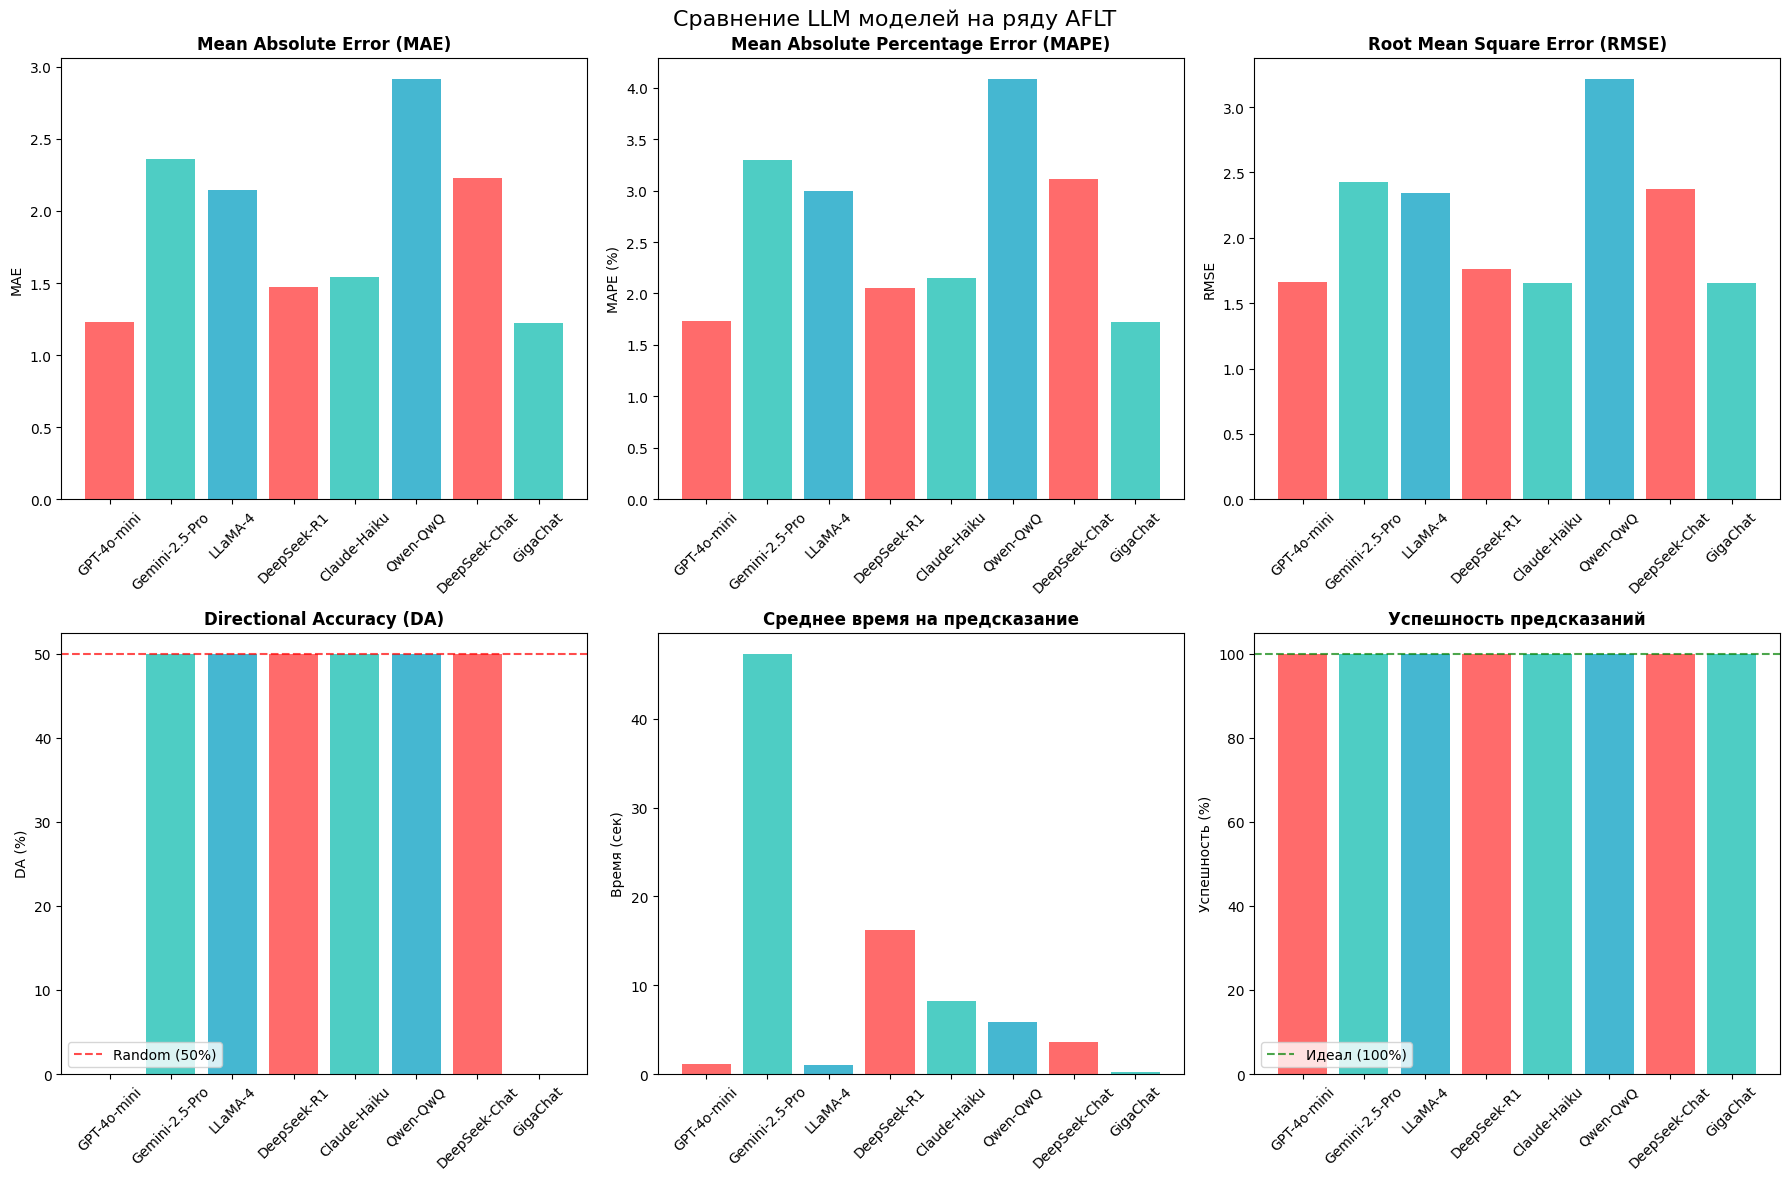

\n📈 Графики отображены!


In [203]:
# Визуализация результатов
if valid_metrics:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Сравнение LLM моделей на ряду {symbol}', fontsize=16, y=0.98)
    
    # Подготовка данных для визуализации
    model_names = list(valid_metrics.keys())
    mae_values = [valid_metrics[model]['MAE'] for model in model_names]
    mape_values = [valid_metrics[model]['MAPE'] for model in model_names]
    rmse_values = [valid_metrics[model]['RMSE'] for model in model_names]
    da_values = [valid_metrics[model]['DA'] for model in model_names]
    time_values = [valid_metrics[model]['Avg_Time'] for model in model_names]
    success_values = [valid_metrics[model]['Success_Rate'] for model in model_names]
    
    # Цвета для моделей
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # 1. MAE
    axes[0,0].bar(model_names, mae_values, color=colors[:len(model_names)])
    axes[0,0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. MAPE
    axes[0,1].bar(model_names, mape_values, color=colors[:len(model_names)])
    axes[0,1].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. RMSE
    axes[0,2].bar(model_names, rmse_values, color=colors[:len(model_names)])
    axes[0,2].set_title('Root Mean Square Error (RMSE)', fontweight='bold')
    axes[0,2].set_ylabel('RMSE')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Directional Accuracy
    axes[1,0].bar(model_names, da_values, color=colors[:len(model_names)])
    axes[1,0].set_title('Directional Accuracy (DA)', fontweight='bold')
    axes[1,0].set_ylabel('DA (%)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Random (50%)')
    axes[1,0].legend()
    
    # 5. Среднее время
    axes[1,1].bar(model_names, time_values, color=colors[:len(model_names)])
    axes[1,1].set_title('Среднее время на предсказание', fontweight='bold')
    axes[1,1].set_ylabel('Время (сек)')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # 6. Успешность
    axes[1,2].bar(model_names, success_values, color=colors[:len(model_names)])
    axes[1,2].set_title('Успешность предсказаний', fontweight='bold')
    axes[1,2].set_ylabel('Успешность (%)')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].axhline(y=100, color='green', linestyle='--', alpha=0.7, label='Идеал (100%)')
    axes[1,2].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\\n📈 Графики отображены!")
else:
    print("❌ Нет данных для визуализации")


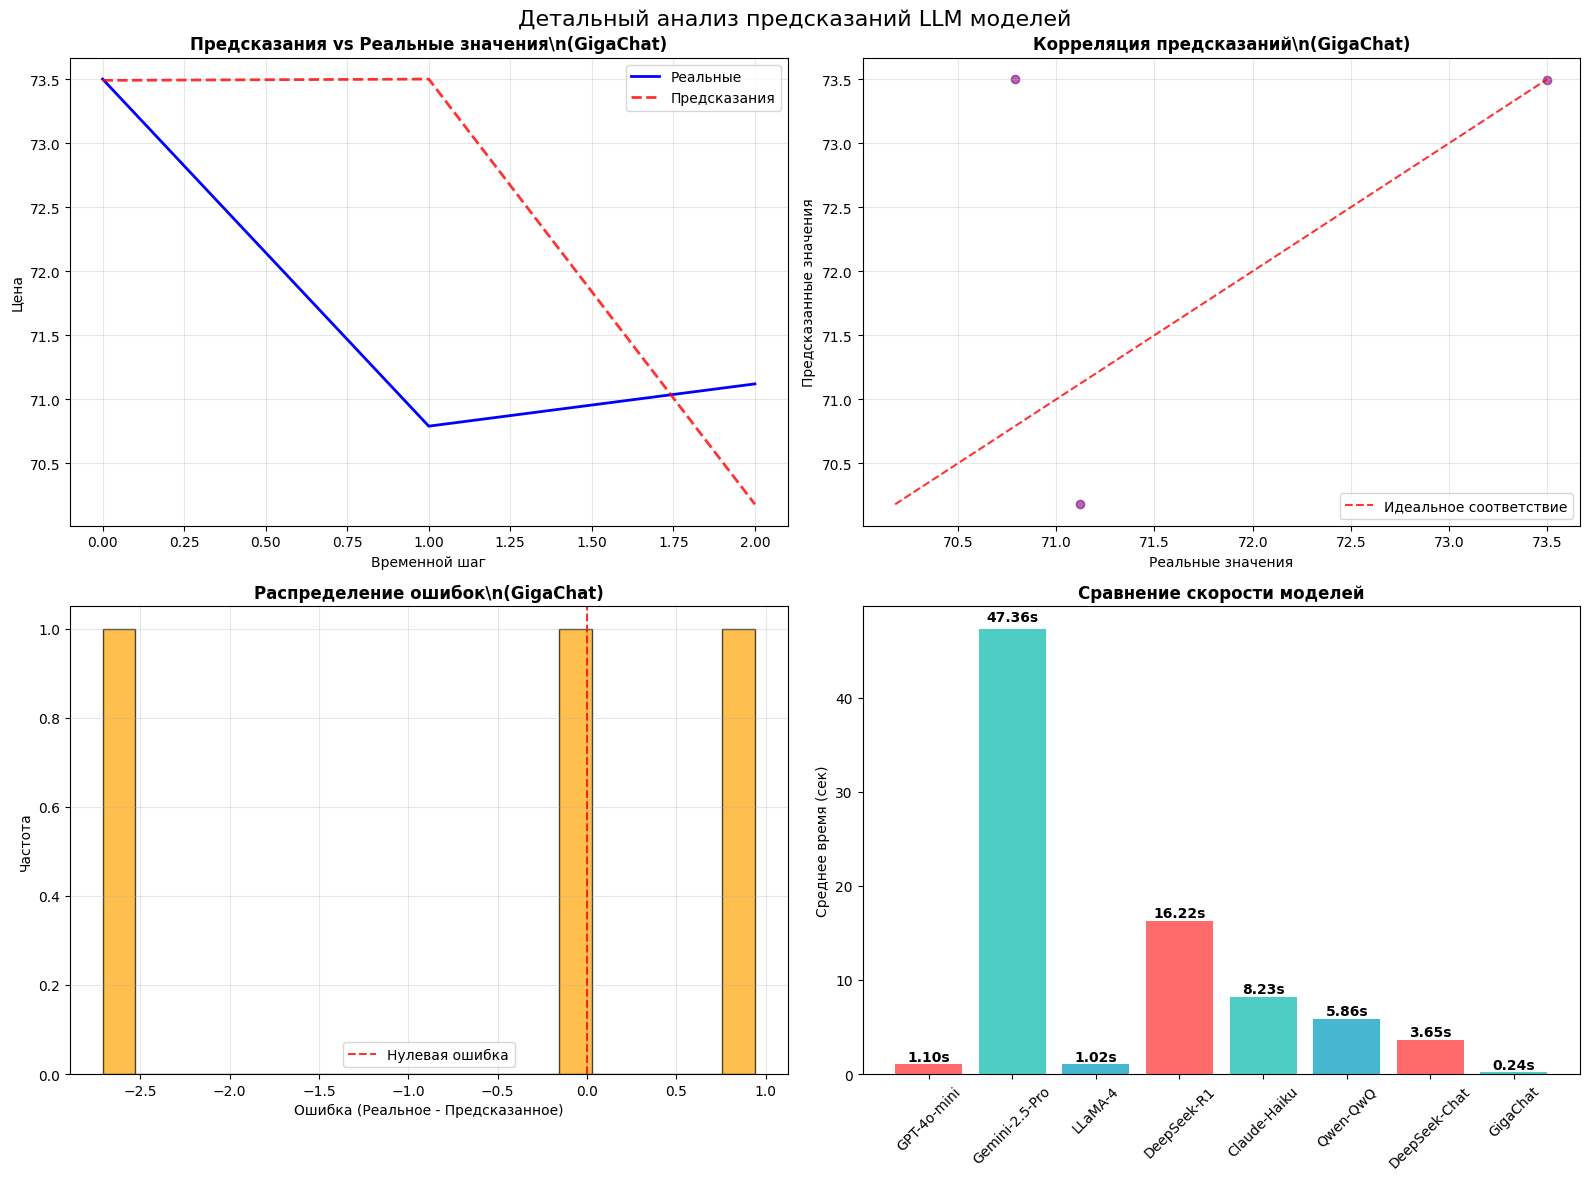

\n📊 Детальные графики отображены!


In [204]:
# Визуализация предсказаний vs реальных значений
if valid_metrics and results_dict:
    # Выберем модель с лучшим MAE для детального анализа
    best_model = min(valid_metrics.items(), key=lambda x: x[1]['MAE'])[0]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Детальный анализ предсказаний LLM моделей', fontsize=16, y=0.98)
    
    # График 1: Временной ряд с предсказаниями лучшей модели
    if best_model in results_dict:
        results = results_dict[best_model]
        true_vals = results['true_values']
        pred_vals = results['predictions']
        
        # Убираем NaN для отображения
        valid_indices = [i for i, p in enumerate(pred_vals) if not np.isnan(p)]
        valid_true = [true_vals[i] for i in valid_indices]
        valid_pred = [pred_vals[i] for i in valid_indices]
        
        axes[0,0].plot(range(len(valid_true)), valid_true, 'b-', label='Реальные', linewidth=2)
        axes[0,0].plot(range(len(valid_pred)), valid_pred, 'r--', label='Предсказания', linewidth=2, alpha=0.8)
        axes[0,0].set_title(f'Предсказания vs Реальные значения\\n({best_model})', fontweight='bold')
        axes[0,0].set_xlabel('Временной шаг')
        axes[0,0].set_ylabel('Цена')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # График 2: Scatter plot предсказания vs реальные
    if best_model in results_dict:
        axes[0,1].scatter(valid_true, valid_pred, alpha=0.6, color='purple')
        
        # Линия идеального соответствия
        min_val, max_val = min(min(valid_true), min(valid_pred)), max(max(valid_true), max(valid_pred))
        axes[0,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Идеальное соответствие')
        
        axes[0,1].set_title(f'Корреляция предсказаний\\n({best_model})', fontweight='bold')
        axes[0,1].set_xlabel('Реальные значения')
        axes[0,1].set_ylabel('Предсказанные значения')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # График 3: Распределение ошибок
    if best_model in results_dict:
        errors = [t - p for t, p in zip(valid_true, valid_pred)]
        axes[1,0].hist(errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
        axes[1,0].axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Нулевая ошибка')
        axes[1,0].set_title(f'Распределение ошибок\\n({best_model})', fontweight='bold')
        axes[1,0].set_xlabel('Ошибка (Реальное - Предсказанное)')
        axes[1,0].set_ylabel('Частота')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
    
    # График 4: Сравнение времени выполнения
    if len(valid_metrics) > 1:
        model_names = list(valid_metrics.keys())
        avg_times = [valid_metrics[model]['Avg_Time'] for model in model_names]
        
        bars = axes[1,1].bar(model_names, avg_times, color=colors[:len(model_names)])
        axes[1,1].set_title('Сравнение скорости моделей', fontweight='bold')
        axes[1,1].set_ylabel('Среднее время (сек)')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Добавляем значения на столбцы
        for bar, time_val in zip(bars, avg_times):
            height = bar.get_height()
            axes[1,1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                          f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\\n📊 Детальные графики отображены!")
else:
    print("❌ Нет данных для детального анализа")


# 🔬 МАССОВОЕ ТЕСТИРОВАНИЕ LLM МОДЕЛЕЙ НА ВСЕХ ТИКЕРАХ

In [211]:
def test_llm_models_on_all_tickers(models_to_test=None, max_models=3, test_size=0.05):
    """
    Тестирование LLM моделей на всех доступных тикерах
    
    Args:
        models_to_test: Список моделей для тестирования (None = все)
        max_models: Максимальное количество моделей для тестирования
        test_size: Размер тестовой выборки для каждого тикера
    """
    
    # Загружаем все данные
    series_dict = load_data()
    print(f"📊 Загружено тикеров: {len(series_dict)}")
    
    # Выбираем модели для тестирования
    if models_to_test is None:
        models_to_test = list(LLM_MODELS.keys())[:max_models]
    
    print(f"🤖 Тестируемые модели ({len(models_to_test)}):")
    for model in models_to_test:
        if model in LLM_MODELS:
            print(f"  • {model}: {LLM_MODELS[model]['description']}")
    
    # Результаты по всем тикерам
    all_results = {model: [] for model in models_to_test}
    ticker_results = {}
    
    print(f"\n🚀 Начинаем тестирование на {len(series_dict)} тикерах...")
    print("=" * 80)
    
    # Тестируем каждый тикер
    for ticker_idx, (symbol, df) in enumerate(series_dict.items(), 1):
        series = df['close']
        window_size = min(50, len(series) // 4)
        
        print(f"\n📈 Тикер {ticker_idx}/{len(series_dict)}: {symbol} ({len(series)} точек)")
        print(f"   Размер окна: {window_size}, тестовых шагов: {test_size}")
        print("-" * 60)
        
        ticker_results[symbol] = {}
        
        # Тестируем каждую модель на текущем тикере
        for model_name in models_to_test:
            if model_name not in LLM_MODELS:
                print(f"   ❌ {model_name}: модель не найдена")
                continue
                
            print(f"   🔄 {model_name}...", end=" ", flush=True)
            
            try:
                # Создаем предиктор
                config = LLM_MODELS[model_name]
                predictor = config['predictor_class'](config['api_key'])
                
                # Запускаем валидацию
                start_time = time.time()
                results = walk_forward_validation_llm(
                    predictor=predictor,
                    series=series,  # Ограничиваем размер для скорости
                    window_size=window_size,
                    patch_size=PATCH_SIZE
                )
                
                # Вычисляем метрики
                metrics = calculate_metrics(results)
                elapsed_time = time.time() - start_time
                
                # Сохраняем результаты
                all_results[model_name].append(metrics)
                ticker_results[symbol][model_name] = {
                    'metrics': metrics,
                    'elapsed_time': elapsed_time,
                    'predictions': results['predictions']
                }
                
                print(f"✅ MAE={metrics['MAE']:.2f}, MAPE={metrics['MAPE']:.1f}%, "
                      f"DA={metrics['DA']:.1f}%, {elapsed_time:.1f}s")
                
            except Exception as e:
                print(f"❌ Ошибка: {str(e)[:50]}...")
                all_results[model_name].append({'error': str(e)})
                ticker_results[symbol][model_name] = {'error': str(e)}
    
    return all_results, ticker_results

def create_summary_report(all_results, ticker_results):
    """Создание сводного отчета по результатам тестирования"""
    
    print("\n" + "="*80)
    print("📊 СВОДНЫЙ ОТЧЕТ ПО ВСЕМ ТИКЕРАМ")
    print("="*80)
    
    # Подготовка данных для сводной таблицы
    summary_data = []
    
    for model_name, results_list in all_results.items():
        # Фильтруем успешные результаты
        valid_results = [r for r in results_list if 'error' not in r]
        
        if valid_results:
            df_metrics = pd.DataFrame(valid_results)
            summary_data.append({
                'Модель': model_name,
                'Успешных тестов': len(valid_results),
                'Всего тестов': len(results_list),
                'Успешность (%)': len(valid_results) / len(results_list) * 100,
                'Средний MAE': df_metrics['MAE'].mean(),
                'Средний MAPE (%)': df_metrics['MAPE'].mean(),
                'Средний RMSE': df_metrics['RMSE'].mean(),
                'Средний DA (%)': df_metrics['DA'].mean(),
                'Среднее время (с)': df_metrics['Avg_Time'].mean(),
            })
        else:
            summary_data.append({
                'Модель': model_name,
                'Успешных тестов': 0,
                'Всего тестов': len(results_list),
                'Успешность (%)': 0,
                'Средний MAE': '—',
                'Средний MAPE (%)': '—',
                'Средний RMSE': '—',
                'Средний DA (%)': '—',
                'Среднее время (с)': '—',
            })
    
    # Создаем и выводим таблицу
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.round(4).to_string(index=False))
    
    # Находим лучшие модели
    valid_models = summary_df[summary_df['Успешных тестов'] > 0]
    if not valid_models.empty:
        print(f"\n🏆 ЛУЧШИЕ МОДЕЛИ:")
        print(f"📉 Лучший MAE: {valid_models.loc[valid_models['Средний MAE'].idxmin(), 'Модель']}")
        print(f"📊 Лучший MAPE: {valid_models.loc[valid_models['Средний MAPE (%)'].idxmin(), 'Модель']}")
        print(f"🎯 Лучший DA: {valid_models.loc[valid_models['Средний DA (%)'].idxmax(), 'Модель']}")
        print(f"⚡ Самая быстрая: {valid_models.loc[valid_models['Среднее время (с)'].idxmin(), 'Модель']}")
        print(f"🛡️ Самая надежная: {valid_models.loc[valid_models['Успешность (%)'].idxmax(), 'Модель']}")
    
    return summary_df

print("Функции массового тестирования готовы! 🚀")

Функции массового тестирования готовы! 🚀


In [214]:
# 🎯 ЗАПУСК ТЕСТИРОВАНИЯ НА ВЫБРАННЫХ МОДЕЛЯХ

# Выберите модели для тестирования (для экономии времени и API-запросов)
# SELECTED_MODELS = [
#     'GPT-4o-mini',        # Быстрая модель OpenAI
#     'DeepSeek-Chat',      # Прямой API DeepSeek
#     'GigaChat'            # Российская модель
# ]

# Альтернативно: можете протестировать все модели (занимает много времени!)
SELECTED_MODELS = LLM_MODELS  # Для тестирования всех моделей

print("🚀 ПАРАМЕТРЫ ТЕСТИРОВАНИЯ:")
print(f"📊 Выбранные модели: {len(SELECTED_MODELS) if SELECTED_MODELS else len(LLM_MODELS)}")
if SELECTED_MODELS:
    for model in SELECTED_MODELS:
        if model in LLM_MODELS:
            print(f"  • {model}")

# Запуск тестирования
all_results, ticker_results = test_llm_models_on_all_tickers(
    models_to_test=SELECTED_MODELS,
    max_models=3,
    test_size=0.05  # Количество тестовых шагов на каждом тикере
)

# Создание сводного отчета
summary_df = create_summary_report(all_results, ticker_results)

print(f"\n✨ Тестирование завершено! ✨")

🚀 ПАРАМЕТРЫ ТЕСТИРОВАНИЯ:
📊 Выбранные модели: 5
  • GPT-4o-mini
  • LLaMA-4
  • Claude-Haiku
  • DeepSeek-Chat
  • GigaChat
Загружен AFLT: 2375 точек
Загружен LKOH: 2375 точек
Загружен MOEX: 2375 точек
Загружен NVTK: 2373 точек
Загружен PIKK: 2375 точек
Загружен SBER: 2375 точек
Загружен VKCO: 1197 точек
Загружен VTBR: 1722 точек
Загружен X5: 1499 точек
Загружен YDEX: 2339 точек
📊 Загружено тикеров: 10
🤖 Тестируемые модели (5):
  • GPT-4o-mini: Компактная версия GPT-4o от OpenAI
  • LLaMA-4: Модель от Meta
  • Claude-Haiku: Быстрая модель от Anthropic
  • DeepSeek-Chat: Специализированная модель от DeepSeek
  • GigaChat: Российская LLM от Сбербанка

🚀 Начинаем тестирование на 10 тикерах...

📈 Тикер 1/10: AFLT (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=54.88, Pred=58.50, Time=1.75s
Шаг 2/119

Шаг 5/119: True=48.52, Pred=48.52, Time=6.00s
Шаг 6/119: True=50.15, Pred=47.21, Time=0.90s
Шаг 7/119: True=50.86, Pred=47.29, Time=0.87s
Шаг 8/119: True=51.18, Pred=51.23, Time=1.08s
Шаг 9/119: True=49.80, Pred=51.93, Time=0.92s
Шаг 10/119: True=49.97, Pred=49.21, Time=0.74s
Шаг 11/119: True=48.54, Pred=50.79, Time=0.66s
Шаг 12/119: True=48.28, Pred=47.32, Time=0.69s
Шаг 13/119: True=47.70, Pred=47.21, Time=0.96s
Шаг 14/119: True=47.67, Pred=46.21, Time=0.83s
Шаг 15/119: True=49.30, Pred=48.23, Time=1.03s
Шаг 16/119: True=50.12, Pred=49.82, Time=6.31s
Шаг 17/119: True=54.95, Pred=51.29, Time=0.87s
Шаг 18/119: True=56.09, Pred=51.23, Time=2.04s
Шаг 19/119: True=53.62, Pred=48.41, Time=0.99s
Шаг 20/119: True=54.86, Pred=51.19, Time=1.15s
Шаг 21/119: True=55.04, Pred=50.79, Time=6.35s
Шаг 22/119: True=55.65, Pred=55.23, Time=0.72s
Шаг 23/119: True=58.38, Pred=55.21, Time=0.67s
Шаг 24/119: True=59.06, Pred=59.23, Time=1.58s
Шаг 25/119: True=58.13, Pred=60.92, Time=1.03s
Шаг 26/119: True=5

Шаг 4/119: True=48.52, Pred=48.75, Time=15.07s


Шаг 5/119: True=48.52, Pred=10.00, Time=17.75s
Шаг 6/119: True=50.15, Pred=46.80, Time=3.73s
Шаг 7/119: True=50.86, Pred=49.25, Time=4.00s
Шаг 8/119: True=51.18, Pred=51.20, Time=3.24s
Шаг 9/119: True=49.80, Pred=51.85, Time=2.95s
Шаг 10/119: True=49.97, Pred=48.90, Time=3.69s
Шаг 11/119: True=48.54, Pred=49.75, Time=4.84s
Шаг 12/119: True=48.28, Pred=47.85, Time=2.86s
Шаг 13/119: True=47.70, Pred=48.10, Time=3.20s
Шаг 14/119: True=47.67, Pred=46.85, Time=4.88s
Шаг 15/119: True=49.30, Pred=47.10, Time=2.94s
Шаг 16/119: True=50.12, Pred=48.75, Time=4.05s
Шаг 17/119: True=54.95, Pred=49.35, Time=4.03s
Шаг 18/119: True=56.09, Pred=57.20, Time=2.98s


Шаг 19/119: True=53.62, Pred=10.00, Time=14.92s


Шаг 20/119: True=54.86, Pred=54.50, Time=12.97s
Шаг 21/119: True=55.04, Pred=54.50, Time=3.25s
Шаг 22/119: True=55.65, Pred=54.45, Time=5.09s


Шаг 23/119: True=58.38, Pred=56.50, Time=9.36s


Шаг 24/119: True=59.06, Pred=58.85, Time=8.64s
Шаг 25/119: True=58.13, Pred=59.80, Time=4.42s
Шаг 26/119: True=58.99, Pred=57.20, Time=4.14s
Шаг 27/119: True=59.65, Pred=58.50, Time=2.89s
Шаг 28/119: True=58.43, Pred=60.05, Time=3.06s


Шаг 29/119: True=60.99, Pred=59.25, Time=8.91s
Шаг 30/119: True=60.50, Pred=61.85, Time=4.48s
Шаг 31/119: True=61.56, Pred=60.85, Time=3.70s
Шаг 32/119: True=62.25, Pred=61.85, Time=3.82s
Шаг 33/119: True=61.36, Pred=62.98, Time=5.33s
Шаг 34/119: True=61.80, Pred=61.75, Time=3.33s
Шаг 35/119: True=61.45, Pred=62.20, Time=3.55s
Шаг 36/119: True=61.50, Pred=61.20, Time=3.34s
Шаг 37/119: True=60.37, Pred=61.20, Time=4.74s
Шаг 38/119: True=60.89, Pred=60.05, Time=3.41s
Шаг 39/119: True=61.86, Pred=60.50, Time=3.37s
Шаг 40/119: True=60.15, Pred=61.45, Time=3.34s
Шаг 41/119: True=61.11, Pred=60.75, Time=3.36s
Шаг 42/119: True=62.19, Pred=61.50, Time=3.64s
Шаг 43/119: True=64.43, Pred=61.85, Time=4.83s
Шаг 44/119: True=63.86, Pred=64.90, Time=3.59s
Шаг 45/119: True=63.96, Pred=64.50, Time=3.44s
Шаг 46/119: True=62.66, Pred=64.50, Time=3.17s
Шаг 47/119: True=64.73, Pred=62.85, Time=3.35s
Шаг 48/119: True=64.35, Pred=64.90, Time=3.47s
Шаг 49/119: True=64.25, Pred=64.85, Time=3.58s
Шаг 50/119: T

Шаг 53/119: True=67.97, Pred=10.00, Time=19.13s
Шаг 54/119: True=68.94, Pred=68.50, Time=3.70s
Шаг 55/119: True=74.51, Pred=69.50, Time=3.33s
Шаг 56/119: True=71.89, Pred=75.20, Time=2.94s
Шаг 57/119: True=75.03, Pred=72.45, Time=2.91s
Шаг 58/119: True=77.07, Pred=75.85, Time=3.96s
Шаг 59/119: True=76.22, Pred=78.50, Time=4.18s
Шаг 60/119: True=76.95, Pred=77.85, Time=4.22s
Шаг 61/119: True=77.22, Pred=78.50, Time=4.18s
Шаг 62/119: True=74.69, Pred=77.98, Time=3.38s
Шаг 63/119: True=71.51, Pred=76.50, Time=3.14s
Шаг 64/119: True=73.59, Pred=70.21, Time=5.09s
Шаг 65/119: True=73.81, Pred=75.32, Time=3.93s
Шаг 66/119: True=72.93, Pred=72.85, Time=3.78s
Шаг 67/119: True=73.98, Pred=73.50, Time=3.44s
Шаг 68/119: True=76.35, Pred=74.85, Time=4.78s


Шаг 69/119: True=74.20, Pred=77.42, Time=9.21s
Шаг 70/119: True=73.82, Pred=74.85, Time=3.77s
Шаг 71/119: True=75.10, Pred=74.85, Time=2.98s
Шаг 72/119: True=74.71, Pred=75.80, Time=4.52s
Шаг 73/119: True=74.26, Pred=75.42, Time=2.95s
Шаг 74/119: True=73.20, Pred=74.50, Time=4.15s
Шаг 75/119: True=73.87, Pred=73.50, Time=2.74s
Шаг 76/119: True=74.56, Pred=74.50, Time=3.21s
Шаг 77/119: True=74.72, Pred=74.25, Time=4.36s
Шаг 78/119: True=75.95, Pred=75.10, Time=3.95s
Шаг 79/119: True=76.35, Pred=76.50, Time=2.96s
Шаг 80/119: True=75.44, Pred=76.85, Time=3.19s
Шаг 81/119: True=76.05, Pred=75.85, Time=3.70s
Шаг 82/119: True=75.80, Pred=76.50, Time=3.11s
Шаг 83/119: True=75.48, Pred=75.70, Time=2.92s
Шаг 84/119: True=74.36, Pred=76.10, Time=3.27s
Шаг 85/119: True=74.60, Pred=74.15, Time=4.16s
Шаг 86/119: True=73.25, Pred=74.25, Time=3.10s
Шаг 87/119: True=71.00, Pred=74.10, Time=2.88s
Шаг 88/119: True=67.21, Pred=72.50, Time=2.92s


Шаг 89/119: True=66.45, Pred=10.00, Time=18.95s


Шаг 90/119: True=66.45, Pred=10.00, Time=17.55s


Шаг 91/119: True=69.63, Pred=10.00, Time=20.10s
Шаг 92/119: True=66.02, Pred=70.25, Time=5.25s
Шаг 93/119: True=67.43, Pred=68.50, Time=3.72s
Шаг 94/119: True=70.36, Pred=66.85, Time=3.56s
Шаг 95/119: True=66.46, Pred=70.85, Time=5.19s
Шаг 96/119: True=65.56, Pred=66.05, Time=3.61s
Шаг 97/119: True=66.48, Pred=72.45, Time=5.22s
Шаг 98/119: True=64.07, Pred=65.85, Time=3.22s
Шаг 99/119: True=62.33, Pred=66.50, Time=4.59s


Шаг 100/119: True=67.76, Pred=62.33, Time=10.37s
Шаг 101/119: True=66.84, Pred=66.85, Time=4.70s
Шаг 102/119: True=69.60, Pred=72.50, Time=3.70s
Шаг 103/119: True=71.14, Pred=69.80, Time=2.94s
Шаг 104/119: True=71.40, Pred=73.50, Time=4.10s
Шаг 105/119: True=68.69, Pred=70.75, Time=4.03s
Шаг 106/119: True=69.35, Pred=68.50, Time=3.41s
Шаг 107/119: True=69.35, Pred=68.50, Time=3.77s
Шаг 108/119: True=71.15, Pred=69.10, Time=3.91s
Шаг 109/119: True=70.18, Pred=70.45, Time=4.84s
Шаг 110/119: True=72.45, Pred=70.85, Time=4.55s
Шаг 111/119: True=73.49, Pred=71.88, Time=4.01s
Шаг 112/119: True=72.73, Pred=72.50, Time=2.84s
Шаг 113/119: True=72.17, Pred=72.50, Time=3.30s
Шаг 114/119: True=74.54, Pred=72.85, Time=3.41s


Шаг 115/119: True=74.31, Pred=75.20, Time=9.55s


Шаг 116/119: True=74.87, Pred=74.85, Time=14.20s
Шаг 117/119: True=73.50, Pred=75.20, Time=5.87s


Шаг 118/119: True=70.79, Pred=9.00, Time=17.84s
Шаг 119/119: True=71.12, Pred=71.50, Time=4.38s
✅ MAE=4.59, MAPE=7.2%, DA=47.5%, 612.9s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=54.88, Pred=56.93, Time=0.37s
Шаг 2/119: True=52.15, Pred=54.88, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/119: True=50.51, Pred=57.55, Time=0.17s
Шаг 4/119: True=48.52, Pred=55.33, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/119: True=48.52, Pred=55.88, Time=0.18s
Шаг 6/119: True=50.15, Pred=54.88, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/119: True=50.86, Pred=57.07, Time=0.18s
Шаг 8/119: True=51.18, Pred=57.55, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/119: True=49.80, Pred=57.55, Time=0.17s
Шаг 10/119: True=49.97, Pred=55.39, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 11/119: True=48.54, Pred=56.25, Time=0.19s
Шаг 12/119: True=48.28, Pred=57.07, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/119: True=47.70, Pred=57.55, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 14/119: True=47.67, Pred=57.56, Time=0.23s
Шаг 15/119: True=49.30, Pred=56.11, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/119: True=50.12, Pred=56.93, Time=0.20s
Шаг 17/119: True=54.95, Pred=57.13, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/119: True=56.09, Pred=54.95, Time=0.20s
Шаг 19/119: True=53.62, Pred=58.83, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/119: True=54.86, Pred=56.60, Time=0.18s
Шаг 21/119: True=55.04, Pred=54.86, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/119: True=55.65, Pred=54.88, Time=0.19s
Шаг 23/119: True=58.38, Pred=57.55, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/119: True=59.06, Pred=57.55, Time=0.19s
Шаг 25/119: True=58.13, Pred=59.06, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/119: True=58.99, Pred=57.07, Time=0.18s
Шаг 27/119: True=59.65, Pred=58.99, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=58.43, Pred=59.65, Time=0.19s
Шаг 29/119: True=60.99, Pred=57.55, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/119: True=60.50, Pred=58.13, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 31/119: True=61.56, Pred=55.33, Time=0.22s
Шаг 32/119: True=62.25, Pred=59.65, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 33/119: True=61.36, Pred=58.84, Time=0.21s
Шаг 34/119: True=61.80, Pred=59.05, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/119: True=61.45, Pred=59.02, Time=0.20s
Шаг 36/119: True=61.50, Pred=61.56, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/119: True=60.37, Pred=61.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/119: True=60.89, Pred=61.30, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 39/119: True=61.86, Pred=61.80, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/119: True=60.15, Pred=61.45, Time=0.25s
Шаг 41/119: True=61.11, Pred=61.56, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/119: True=62.19, Pred=61.50, Time=0.18s
Шаг 43/119: True=64.43, Pred=61.30, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/119: True=63.86, Pred=58.83, Time=0.18s
Шаг 45/119: True=63.96, Pred=63.86, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/119: True=62.66, Pred=63.96, Time=0.19s
Шаг 47/119: True=64.73, Pred=61.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 48/119: True=64.35, Pred=55.59, Time=0.19s
Шаг 49/119: True=64.25, Pred=56.09, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/119: True=64.81, Pred=64.35, Time=0.19s
Шаг 51/119: True=64.67, Pred=64.81, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 52/119: True=69.39, Pred=64.67, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/119: True=67.97, Pred=65.49, Time=0.21s
Шаг 54/119: True=68.94, Pred=67.97, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/119: True=74.51, Pred=68.94, Time=0.19s
Шаг 56/119: True=71.89, Pred=74.51, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/119: True=75.03, Pred=62.25, Time=0.19s
Шаг 58/119: True=77.07, Pred=75.03, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/119: True=76.22, Pred=77.07, Time=0.19s
Шаг 60/119: True=76.95, Pred=76.22, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 61/119: True=77.22, Pred=76.95, Time=0.19s
Шаг 62/119: True=74.69, Pred=71.89, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 63/119: True=71.51, Pred=75.03, Time=0.21s
Шаг 64/119: True=73.59, Pred=71.51, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 65/119: True=73.81, Pred=73.59, Time=0.19s
Шаг 66/119: True=72.93, Pred=74.51, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 67/119: True=73.98, Pred=64.56, Time=0.19s
Шаг 68/119: True=76.35, Pred=74.69, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 69/119: True=74.20, Pred=69.39, Time=0.20s
Шаг 70/119: True=73.82, Pred=64.81, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/119: True=75.10, Pred=75.03, Time=0.19s
Шаг 72/119: True=74.71, Pred=75.10, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/119: True=74.26, Pred=65.49, Time=0.19s
Шаг 74/119: True=73.20, Pred=74.30, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/119: True=73.87, Pred=64.25, Time=0.19s
Шаг 76/119: True=74.56, Pred=74.51, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 77/119: True=74.72, Pred=75.10, Time=0.18s
Шаг 78/119: True=75.95, Pred=64.35, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 79/119: True=76.35, Pred=75.95, Time=0.18s
Шаг 80/119: True=75.44, Pred=76.35, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/119: True=76.05, Pred=74.51, Time=0.18s
Шаг 82/119: True=75.80, Pred=75.03, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/119: True=75.48, Pred=75.80, Time=0.18s
Шаг 84/119: True=74.36, Pred=75.82, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/119: True=74.60, Pred=73.87, Time=0.19s
Шаг 86/119: True=73.25, Pred=74.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/119: True=71.00, Pred=75.80, Time=0.18s
Шаг 88/119: True=67.21, Pred=75.48, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 89/119: True=66.45, Pred=74.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 90/119: True=66.45, Pred=75.43, Time=0.91s
Шаг 91/119: True=69.63, Pred=74.56, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 92/119: True=66.02, Pred=75.70, Time=0.18s
Шаг 93/119: True=67.43, Pred=75.48, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 94/119: True=70.36, Pred=75.82, Time=0.18s
Шаг 95/119: True=66.46, Pred=73.87, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 96/119: True=65.56, Pred=73.82, Time=0.18s
Шаг 97/119: True=66.48, Pred=75.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 98/119: True=64.07, Pred=74.84, Time=0.18s
Шаг 99/119: True=62.33, Pred=73.82, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 100/119: True=67.76, Pred=67.16, Time=0.18s
Шаг 101/119: True=66.84, Pred=75.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 102/119: True=69.60, Pred=75.80, Time=0.18s
Шаг 103/119: True=71.14, Pred=75.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 104/119: True=71.40, Pred=75.48, Time=0.18s
Шаг 105/119: True=68.69, Pred=76.35, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 106/119: True=69.35, Pred=75.44, Time=0.18s
Шаг 107/119: True=69.35, Pred=74.12, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 108/119: True=71.15, Pred=74.12, Time=0.20s
Шаг 109/119: True=70.18, Pred=74.13, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 110/119: True=72.45, Pred=74.36, Time=0.18s
Шаг 111/119: True=73.49, Pred=74.69, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/119: True=72.73, Pred=73.49, Time=0.20s
Шаг 113/119: True=72.17, Pred=72.73, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/119: True=74.54, Pred=72.17, Time=0.19s
Шаг 115/119: True=74.31, Pred=74.54, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 116/119: True=74.87, Pred=74.31, Time=0.19s
Шаг 117/119: True=73.50, Pred=74.87, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 118/119: True=70.79, Pred=73.50, Time=0.20s
Шаг 119/119: True=71.12, Pred=72.17, Time=0.19s
✅ MAE=3.84, MAPE=6.2%, DA=42.4%, 23.3s

📈 Тикер 2/10: LKOH (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=6905.50, Pred=6885.00, Time=2.29s
Шаг 2/119: True=6860.50, Pred=6900.00, Time=0.83s
Шаг 3/119: True=6810.00, Pred=6880.00, Time=0.75s
Шаг 4/119: True=6771.00, Pred=6880.00, Time=1.63s
Шаг 5/119: True=6720.50, Pred=6880.00, Time=1.80s
Шаг 6/119: True=6841.00, Pred=6885.00, Time=1.07s
Шаг 7/119: True=6860.00, Pred=6885.00, Time=0.64s
Шаг 8/119: True=6973.00, Pred=6880.00, Time=1.04s
Шаг 9/119: True=6894.00, Pred=6840.00, Time=1.03s
Шаг 10/119: True=6895.50, Pred=6880.00, Time=0.69s
Шаг 11/119: True=6862.50, Pred=6885.00, Time=0.56s
Шаг 12/119: True=6800.00, Pred=6885.00, Time=0.87s
Шаг 13/119: True

Шаг 24/119: True=7235.00, Pred=6998.00, Time=6.06s
Шаг 25/119: True=7122.00, Pred=7141.40, Time=0.80s
Шаг 26/119: True=7088.00, Pred=7134.00, Time=0.54s
Шаг 27/119: True=7089.00, Pred=7093.40, Time=1.04s
Шаг 28/119: True=6947.50, Pred=7103.20, Time=6.40s
Шаг 29/119: True=7022.50, Pred=7093.40, Time=0.57s
Шаг 30/119: True=7010.50, Pred=7054.40, Time=1.27s
Шаг 31/119: True=7115.50, Pred=7033.40, Time=0.84s
Шаг 32/119: True=7178.50, Pred=7056.40, Time=0.82s
Шаг 33/119: True=7208.00, Pred=7093.40, Time=0.68s
Шаг 34/119: True=7342.00, Pred=7084.40, Time=0.54s
Шаг 35/119: True=7194.00, Pred=7311.40, Time=0.55s
Шаг 36/119: True=7239.50, Pred=7251.40, Time=1.23s
Шаг 37/119: True=7215.00, Pred=7314.40, Time=0.95s
Шаг 38/119: True=7215.00, Pred=7251.30, Time=1.04s
Шаг 39/119: True=7199.50, Pred=7249.40, Time=1.08s
Шаг 40/119: True=7065.50, Pred=7218.40, Time=0.96s
Шаг 41/119: True=7160.00, Pred=7134.50, Time=0.66s
Шаг 42/119: True=7192.00, Pred=7173.00, Time=0.39s


Шаг 43/119: True=7166.00, Pred=7192.00, Time=6.10s
Шаг 44/119: True=7171.00, Pred=7183.40, Time=1.08s
Шаг 45/119: True=7170.00, Pred=7183.40, Time=0.86s
Шаг 46/119: True=7093.50, Pred=7178.19, Time=6.22s
Шаг 47/119: True=7171.00, Pred=7159.25, Time=1.09s
Шаг 48/119: True=7141.00, Pred=7143.20, Time=1.85s
Шаг 49/119: True=7148.00, Pred=7143.50, Time=1.12s
Шаг 50/119: True=7147.50, Pred=7149.00, Time=0.85s
Шаг 51/119: True=7271.00, Pred=7183.30, Time=1.04s
Шаг 52/119: True=7676.00, Pred=7293.50, Time=0.55s
Шаг 53/119: True=7534.00, Pred=7278.50, Time=6.41s
Шаг 54/119: True=7492.50, Pred=7551.19, Time=0.51s
Шаг 55/119: True=7784.50, Pred=7421.40, Time=0.77s
Шаг 56/119: True=7644.50, Pred=7551.60, Time=0.88s
Шаг 57/119: True=7714.50, Pred=7623.40, Time=1.15s
Шаг 58/119: True=7720.00, Pred=7876.40, Time=0.95s
Шаг 59/119: True=7709.50, Pred=7753.40, Time=1.12s
Шаг 60/119: True=7737.50, Pred=7714.00, Time=5.96s
Шаг 61/119: True=7729.00, Pred=7751.30, Time=0.82s
Шаг 62/119: True=7555.00, Pred=

Шаг 91/119: True=7026.50, Pred=6853.00, Time=9.15s
Шаг 92/119: True=6905.00, Pred=7011.40, Time=6.37s
Шаг 93/119: True=6978.00, Pred=6911.40, Time=1.41s
Шаг 94/119: True=6802.00, Pred=6951.40, Time=0.96s
Шаг 95/119: True=6445.50, Pred=6911.40, Time=0.64s
Шаг 96/119: True=6486.00, Pred=6631.80, Time=0.75s
Шаг 97/119: True=6587.50, Pred=6721.40, Time=0.92s
Шаг 98/119: True=6349.50, Pred=6451.20, Time=1.04s
Шаг 99/119: True=6283.50, Pred=6364.80, Time=0.95s
Шаг 100/119: True=6507.00, Pred=6362.30, Time=1.24s
Шаг 101/119: True=6375.50, Pred=6643.10, Time=0.50s
Шаг 102/119: True=6508.00, Pred=6304.20, Time=0.48s
Шаг 103/119: True=6582.00, Pred=6451.80, Time=1.09s
Шаг 104/119: True=6562.00, Pred=6615.20, Time=0.69s
Шаг 105/119: True=6474.00, Pred=6629.00, Time=0.58s
Шаг 106/119: True=6466.00, Pred=6507.19, Time=0.87s
Шаг 107/119: True=6515.00, Pred=6511.20, Time=1.31s
Шаг 108/119: True=6719.00, Pred=6461.40, Time=0.99s
Шаг 109/119: True=6629.50, Pred=6583.40, Time=0.93s
Шаг 110/119: True=673

Шаг 16/119: True=6294.00, Pred=6450.00, Time=10.43s
Шаг 17/119: True=6725.00, Pred=6300.00, Time=2.85s
Шаг 18/119: True=6919.00, Pred=6750.00, Time=3.13s
Шаг 19/119: True=6833.00, Pred=6850.00, Time=4.16s


Шаг 20/119: True=6987.50, Pred=6290.50, Time=10.02s
Шаг 21/119: True=7003.00, Pred=6850.00, Time=3.73s
Шаг 22/119: True=6990.50, Pred=6928.50, Time=2.97s
Шаг 23/119: True=6998.00, Pred=6945.00, Time=3.34s
Шаг 24/119: True=7235.00, Pred=6950.00, Time=4.40s


Шаг 25/119: True=7122.00, Pred=7300.00, Time=10.35s
Шаг 26/119: True=7088.00, Pred=7100.00, Time=3.44s
Шаг 27/119: True=7089.00, Pred=7075.00, Time=3.10s
Шаг 28/119: True=6947.50, Pred=7105.00, Time=3.08s
Шаг 29/119: True=7022.50, Pred=6978.50, Time=3.77s
Шаг 30/119: True=7010.50, Pred=7025.00, Time=3.18s
Шаг 31/119: True=7115.50, Pred=7025.50, Time=2.77s
Шаг 32/119: True=7178.50, Pred=7102.50, Time=3.11s
Шаг 33/119: True=7208.00, Pred=7205.00, Time=4.39s
Шаг 34/119: True=7342.00, Pred=7135.50, Time=3.08s


Шаг 35/119: True=7194.00, Pred=7022.50, Time=17.37s
Шаг 36/119: True=7239.50, Pred=7182.50, Time=3.38s
Шаг 37/119: True=7215.00, Pred=7250.00, Time=3.21s
Шаг 38/119: True=7215.00, Pred=7250.00, Time=2.97s
Шаг 39/119: True=7199.50, Pred=7210.00, Time=2.97s
Шаг 40/119: True=7065.50, Pred=7220.50, Time=3.22s
Шаг 41/119: True=7160.00, Pred=7142.50, Time=3.82s
Шаг 42/119: True=7192.00, Pred=7150.00, Time=4.00s
Шаг 43/119: True=7166.00, Pred=7175.00, Time=3.40s
Шаг 44/119: True=7171.00, Pred=7150.50, Time=3.12s
Шаг 45/119: True=7170.00, Pred=7205.50, Time=2.80s
Шаг 46/119: True=7093.50, Pred=7165.00, Time=3.10s
Шаг 47/119: True=7171.00, Pred=7150.00, Time=3.17s
Шаг 48/119: True=7141.00, Pred=7158.00, Time=2.93s
Шаг 49/119: True=7148.00, Pred=7150.00, Time=4.04s
Шаг 50/119: True=7147.50, Pred=7156.50, Time=3.14s
Шаг 51/119: True=7271.00, Pred=7150.00, Time=3.39s
Шаг 52/119: True=7676.00, Pred=7250.00, Time=3.53s


Шаг 53/119: True=7534.00, Pred=7141.00, Time=11.99s
Шаг 54/119: True=7492.50, Pred=7458.00, Time=3.96s


Шаг 55/119: True=7784.50, Pred=7424.20, Time=10.00s


Шаг 56/119: True=7644.50, Pred=7.06, Time=17.04s
Шаг 57/119: True=7714.50, Pred=7265.00, Time=4.90s
Шаг 58/119: True=7720.00, Pred=7745.50, Time=2.85s
Шаг 59/119: True=7709.50, Pred=7745.50, Time=4.37s
Шаг 60/119: True=7737.50, Pred=7725.00, Time=3.31s
Шаг 61/119: True=7729.00, Pred=7750.00, Time=2.90s
Шаг 62/119: True=7555.00, Pred=7742.50, Time=3.01s
Шаг 63/119: True=7497.00, Pred=7682.00, Time=3.97s
Шаг 64/119: True=7546.50, Pred=7485.00, Time=3.35s
Шаг 65/119: True=7555.00, Pred=7568.50, Time=2.94s
Шаг 66/119: True=7531.00, Pred=7558.00, Time=3.11s
Шаг 67/119: True=7341.50, Pred=7542.50, Time=3.16s
Шаг 68/119: True=7393.00, Pred=7442.50, Time=3.29s
Шаг 69/119: True=7241.00, Pred=7405.00, Time=3.08s
Шаг 70/119: True=7175.00, Pred=7150.00, Time=4.38s
Шаг 71/119: True=7225.00, Pred=7100.50, Time=3.67s
Шаг 72/119: True=7185.00, Pred=7250.00, Time=3.04s


Шаг 73/119: True=7248.50, Pred=7250.00, Time=11.27s
Шаг 74/119: True=7205.00, Pred=7250.00, Time=4.18s
Шаг 75/119: True=7130.00, Pred=7212.50, Time=3.15s
Шаг 76/119: True=7149.50, Pred=7135.00, Time=3.09s
Шаг 77/119: True=7167.00, Pred=7150.00, Time=2.97s
Шаг 78/119: True=7209.50, Pred=7105.00, Time=4.32s
Шаг 79/119: True=7222.50, Pred=7218.50, Time=4.59s
Шаг 80/119: True=7183.00, Pred=7250.00, Time=3.91s
Шаг 81/119: True=7221.00, Pred=7175.00, Time=3.16s
Шаг 82/119: True=7293.50, Pred=7215.00, Time=2.97s
Шаг 83/119: True=7346.50, Pred=7256.50, Time=3.11s
Шаг 84/119: True=7291.00, Pred=7355.00, Time=3.31s
Шаг 85/119: True=7265.00, Pred=7280.50, Time=2.74s
Шаг 86/119: True=7185.00, Pred=7250.00, Time=3.74s
Шаг 87/119: True=7108.50, Pred=7175.00, Time=3.02s
Шаг 88/119: True=7064.50, Pred=7100.00, Time=3.51s
Шаг 89/119: True=7013.50, Pred=7080.00, Time=5.72s
Шаг 90/119: True=6853.00, Pred=6950.00, Time=3.82s
Шаг 91/119: True=7026.50, Pred=6940.00, Time=3.29s
Шаг 92/119: True=6905.00, Pred

Шаг 109/119: True=6629.50, Pred=9.00, Time=19.00s
Шаг 110/119: True=6732.50, Pred=6580.00, Time=3.84s


Шаг 111/119: True=6764.00, Pred=10.00, Time=15.67s
Шаг 112/119: True=6743.00, Pred=6698.50, Time=4.57s
Шаг 113/119: True=6683.50, Pred=6650.00, Time=3.05s
Шаг 114/119: True=6856.50, Pred=6655.00, Time=3.27s
Шаг 115/119: True=6904.00, Pred=6895.00, Time=3.17s
Шаг 116/119: True=6914.00, Pred=6942.50, Time=2.87s


Шаг 117/119: True=6827.00, Pred=6948.50, Time=8.79s
Шаг 118/119: True=6725.00, Pred=6805.00, Time=3.59s
Шаг 119/119: True=6684.00, Pred=6742.50, Time=3.47s
✅ MAE=282.49, MAPE=4.0%, DA=49.2%, 525.6s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=6905.50, Pred=6906.20, Time=0.37s
Шаг 2/119: True=6860.50, Pred=6931.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/119: True=6810.00, Pred=6914.50, Time=0.19s
Шаг 4/119: True=6771.00, Pred=6933.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/119: True=6720.50, Pred=6867.00, Time=0.18s
Шаг 6/119: True=6841.00, Pred=6870.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/119: True=6860.00, Pred=6956.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 8/119: True=6973.00, Pred=6956.00, Time=0.21s
Шаг 9/119: True=6894.00, Pred=6973.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/119: True=6895.50, Pred=6857.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 11/119: True=6862.50, Pred=6956.00, Time=0.23s
Шаг 12/119: True=6800.00, Pred=6934.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/119: True=6779.50, Pred=6860.50, Time=0.18s
Шаг 14/119: True=6290.50, Pred=6883.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 15/119: True=6375.00, Pred=6958.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/119: True=6294.00, Pred=6919.30, Time=0.22s
Шаг 17/119: True=6725.00, Pred=6931.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/119: True=6919.00, Pred=6978.20, Time=0.22s
Шаг 19/119: True=6833.00, Pred=6842.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/119: True=6987.50, Pred=6833.00, Time=0.21s
Шаг 21/119: True=7003.00, Pred=6841.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/119: True=6990.50, Pred=6938.50, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 23/119: True=6998.00, Pred=6973.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/119: True=7235.00, Pred=6958.50, Time=0.21s
Шаг 25/119: True=7122.00, Pred=7235.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/119: True=7088.00, Pred=6860.50, Time=0.18s
Шаг 27/119: True=7089.00, Pred=6998.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=6947.50, Pred=6883.70, Time=0.18s
Шаг 29/119: True=7022.50, Pred=6837.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/119: True=7010.50, Pred=6987.50, Time=0.19s
Шаг 31/119: True=7115.50, Pred=6873.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 32/119: True=7178.50, Pred=6860.50, Time=0.18s
Шаг 33/119: True=7208.00, Pred=7178.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 34/119: True=7342.00, Pred=7107.00, Time=0.18s
Шаг 35/119: True=7194.00, Pred=7342.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 36/119: True=7239.50, Pred=7194.00, Time=0.18s
Шаг 37/119: True=7215.00, Pred=7239.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/119: True=7215.00, Pred=7178.50, Time=0.19s
Шаг 39/119: True=7199.50, Pred=6919.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/119: True=7065.50, Pred=7342.00, Time=0.18s
Шаг 41/119: True=7160.00, Pred=7186.90, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/119: True=7192.00, Pred=7160.00, Time=0.18s
Шаг 43/119: True=7166.00, Pred=7215.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/119: True=7171.00, Pred=6833.00, Time=0.19s
Шаг 45/119: True=7170.00, Pred=7171.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/119: True=7093.50, Pred=7171.80, Time=0.18s
Шаг 47/119: True=7171.00, Pred=7171.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 48/119: True=7141.00, Pred=7171.00, Time=0.17s
Шаг 49/119: True=7148.00, Pred=6810.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/119: True=7147.50, Pred=7144.70, Time=0.18s
Шаг 51/119: True=7271.00, Pred=7171.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 52/119: True=7676.00, Pred=7175.00, Time=0.17s
Шаг 53/119: True=7534.00, Pred=7276.70, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 54/119: True=7492.50, Pred=7355.30, Time=0.18s
Шаг 55/119: True=7784.50, Pred=7147.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 56/119: True=7644.50, Pred=7194.00, Time=0.18s
Шаг 57/119: True=7714.50, Pred=7271.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 58/119: True=7720.00, Pred=7714.50, Time=0.18s
Шаг 59/119: True=7709.50, Pred=7720.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 60/119: True=7737.50, Pred=7342.00, Time=0.18s
Шаг 61/119: True=7729.00, Pred=7784.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 62/119: True=7555.00, Pred=7175.00, Time=0.17s
Шаг 63/119: True=7497.00, Pred=7690.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 64/119: True=7546.50, Pred=7147.50, Time=0.19s
Шаг 65/119: True=7555.00, Pred=7546.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 66/119: True=7531.00, Pred=7705.20, Time=0.18s
Шаг 67/119: True=7341.50, Pred=7171.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 68/119: True=7393.00, Pred=7215.00, Time=0.19s
Шаг 69/119: True=7241.00, Pred=7531.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 70/119: True=7175.00, Pred=7241.00, Time=0.18s
Шаг 71/119: True=7225.00, Pred=7175.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 72/119: True=7185.00, Pred=7239.50, Time=0.19s
Шаг 73/119: True=7248.50, Pred=7243.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 74/119: True=7205.00, Pred=7214.90, Time=0.18s
Шаг 75/119: True=7130.00, Pred=7148.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 76/119: True=7149.50, Pred=7175.00, Time=0.18s
Шаг 77/119: True=7167.00, Pred=7175.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 78/119: True=7209.50, Pred=7167.00, Time=0.18s
Шаг 79/119: True=7222.50, Pred=7209.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 80/119: True=7183.00, Pred=7144.70, Time=0.20s
Шаг 81/119: True=7221.00, Pred=7186.30, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 82/119: True=7293.50, Pred=7200.00, Time=0.17s
Шаг 83/119: True=7346.50, Pred=7225.90, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 84/119: True=7291.00, Pred=7346.50, Time=0.18s
Шаг 85/119: True=7265.00, Pred=7147.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 86/119: True=7185.00, Pred=7265.00, Time=0.18s
Шаг 87/119: True=7108.50, Pred=7215.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 88/119: True=7064.50, Pred=7185.00, Time=0.18s
Шаг 89/119: True=7013.50, Pred=7346.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 90/119: True=6853.00, Pred=7175.00, Time=0.16s
Шаг 91/119: True=7026.50, Pred=7185.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 92/119: True=6905.00, Pred=7221.00, Time=0.18s
Шаг 93/119: True=6978.00, Pred=7171.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 94/119: True=6802.00, Pred=7171.00, Time=0.18s
Шаг 95/119: True=6445.50, Pred=7175.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 96/119: True=6486.00, Pred=7171.00, Time=0.18s
Шаг 97/119: True=6587.50, Pred=7171.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 98/119: True=6349.50, Pred=7148.00, Time=0.19s
Шаг 99/119: True=6283.50, Pred=7175.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 100/119: True=6507.00, Pred=7183.00, Time=0.18s
Шаг 101/119: True=6375.50, Pred=7183.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 102/119: True=6508.00, Pred=7130.00, Time=0.18s
Шаг 103/119: True=6582.00, Pred=7205.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 104/119: True=6562.00, Pred=7346.50, Time=0.19s
Шаг 105/119: True=6474.00, Pred=7167.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 106/119: True=6466.00, Pred=6445.50, Time=0.18s
Шаг 107/119: True=6515.00, Pred=7149.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 108/119: True=6719.00, Pred=6466.00, Time=0.19s
Шаг 109/119: True=6629.50, Pred=6547.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 110/119: True=6732.50, Pred=6629.50, Time=0.18s
Шаг 111/119: True=6764.00, Pred=6445.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/119: True=6743.00, Pred=7555.00, Time=0.19s
Шаг 113/119: True=6683.50, Pred=6743.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/119: True=6856.50, Pred=6802.00, Time=0.18s
Шаг 115/119: True=6904.00, Pred=7205.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 116/119: True=6914.00, Pred=6856.50, Time=0.18s
Шаг 117/119: True=6827.00, Pred=7275.10, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 118/119: True=6725.00, Pred=6914.00, Time=0.18s
Шаг 119/119: True=6684.00, Pred=6725.00, Time=0.18s
✅ MAE=217.17, MAPE=3.2%, DA=44.9%, 22.3s

📈 Тикер 3/10: MOEX (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=183.88, Pred=192.00, Time=1.57s
Шаг 2/119: True=184.88, Pred=188.50, Time=1.36s
Шаг 3/119: True=191.76, Pred=185.50, Time=1.21s
Шаг 4/119: True=183.72, Pred=186.50, Time=0.59s
Шаг 5/119: True=179.90, Pred=185.50, Time=0.81s
Шаг 6/119: True=181.18, Pred=182.50, Time=0.58s
Шаг 7/119: True=178.20, Pred=182.50, Time=0.66s
Шаг 8/119: True=183.89, Pred=178.20, Time=1.31s
Шаг 9/119: True=179.08, Pred=181.38, Time=0.53s
Шаг 10/119: True=180.30, Pred=178.50, Time=1.43s
Шаг 11/119: True=175.71, Pred=179.00, Time=1.39s
Шаг 12/119: True=176.01, Pred=177.50, Time=0.63s
Шаг 13/119: True=171.64, Pred=

Шаг 16/119: True=179.20, Pred=175.47, Time=0.97s
Шаг 17/119: True=188.50, Pred=180.91, Time=1.06s
Шаг 18/119: True=189.67, Pred=194.23, Time=1.12s
Шаг 19/119: True=186.09, Pred=185.23, Time=1.49s
Шаг 20/119: True=196.61, Pred=182.41, Time=0.96s
Шаг 21/119: True=194.08, Pred=201.19, Time=0.91s
Шаг 22/119: True=192.45, Pred=191.19, Time=0.44s
Шаг 23/119: True=192.61, Pred=194.23, Time=1.01s
Шаг 24/119: True=199.22, Pred=192.23, Time=1.18s
Шаг 25/119: True=194.83, Pred=197.11, Time=0.66s
Шаг 26/119: True=195.00, Pred=195.19, Time=0.80s
Шаг 27/119: True=197.70, Pred=196.23, Time=0.75s
Шаг 28/119: True=191.72, Pred=198.55, Time=0.89s
Шаг 29/119: True=197.39, Pred=195.19, Time=0.60s
Шаг 30/119: True=200.54, Pred=195.19, Time=0.76s
Шаг 31/119: True=206.38, Pred=198.19, Time=0.81s
Шаг 32/119: True=207.09, Pred=201.19, Time=0.70s
Шаг 33/119: True=206.68, Pred=205.19, Time=0.46s
Шаг 34/119: True=207.40, Pred=205.19, Time=0.94s
Шаг 35/119: True=205.13, Pred=205.19, Time=0.80s
Шаг 36/119: True=206

Шаг 7/119: True=178.20, Pred=185.50, Time=10.37s
Шаг 8/119: True=183.89, Pred=175.50, Time=3.11s
Шаг 9/119: True=179.08, Pred=184.50, Time=3.04s
Шаг 10/119: True=180.30, Pred=178.50, Time=2.95s
Шаг 11/119: True=175.71, Pred=178.50, Time=3.42s
Шаг 12/119: True=176.01, Pred=173.50, Time=3.56s
Шаг 13/119: True=171.64, Pred=172.50, Time=3.73s
Шаг 14/119: True=172.00, Pred=176.55, Time=4.59s
Шаг 15/119: True=175.47, Pred=171.50, Time=2.73s
Шаг 16/119: True=179.20, Pred=173.50, Time=4.27s


Шаг 17/119: True=188.50, Pred=182.50, Time=9.71s


Шаг 18/119: True=189.67, Pred=10.00, Time=15.25s


Шаг 19/119: True=186.09, Pred=193.50, Time=12.97s
Шаг 20/119: True=196.61, Pred=185.50, Time=3.25s


Шаг 21/119: True=194.08, Pred=10.00, Time=16.55s
Шаг 22/119: True=192.45, Pred=180.50, Time=3.37s
Шаг 23/119: True=192.61, Pred=188.50, Time=4.76s
Шаг 24/119: True=199.22, Pred=193.75, Time=4.06s
Шаг 25/119: True=194.83, Pred=192.45, Time=4.48s
Шаг 26/119: True=195.00, Pred=193.50, Time=4.11s
Шаг 27/119: True=197.70, Pred=195.50, Time=2.90s
Шаг 28/119: True=191.72, Pred=197.20, Time=3.98s
Шаг 29/119: True=197.39, Pred=191.50, Time=5.00s
Шаг 30/119: True=200.54, Pred=195.50, Time=4.41s
Шаг 31/119: True=206.38, Pred=198.25, Time=4.67s
Шаг 32/119: True=207.09, Pred=209.50, Time=5.92s


Шаг 33/119: True=206.68, Pred=207.85, Time=15.22s
Шаг 34/119: True=207.40, Pred=205.50, Time=3.15s
Шаг 35/119: True=205.13, Pred=208.50, Time=2.69s
Шаг 36/119: True=206.46, Pred=204.50, Time=3.12s
Шаг 37/119: True=206.48, Pred=206.20, Time=3.10s
Шаг 38/119: True=206.34, Pred=207.25, Time=4.70s
Шаг 39/119: True=211.25, Pred=205.42, Time=3.56s
Шаг 40/119: True=206.73, Pred=210.50, Time=3.50s
Шаг 41/119: True=208.27, Pred=207.50, Time=3.06s
Шаг 42/119: True=205.13, Pred=208.75, Time=3.50s
Шаг 43/119: True=204.85, Pred=204.50, Time=2.98s
Шаг 44/119: True=205.01, Pred=206.50, Time=4.13s
Шаг 45/119: True=204.27, Pred=205.75, Time=3.79s
Шаг 46/119: True=200.08, Pred=204.05, Time=3.46s
Шаг 47/119: True=205.39, Pred=203.50, Time=3.00s
Шаг 48/119: True=204.12, Pred=205.85, Time=3.67s
Шаг 49/119: True=203.99, Pred=203.45, Time=2.80s
Шаг 50/119: True=206.10, Pred=205.50, Time=2.79s
Шаг 51/119: True=213.87, Pred=205.50, Time=2.82s
Шаг 52/119: True=226.61, Pred=212.50, Time=2.90s


Шаг 53/119: True=234.70, Pred=204.12, Time=11.76s
Шаг 54/119: True=229.95, Pred=237.50, Time=3.61s
Шаг 55/119: True=237.54, Pred=236.50, Time=3.02s
Шаг 56/119: True=237.98, Pred=241.50, Time=3.11s
Шаг 57/119: True=239.79, Pred=241.50, Time=3.18s
Шаг 58/119: True=238.79, Pred=243.50, Time=3.15s
Шаг 59/119: True=234.09, Pred=240.50, Time=3.20s
Шаг 60/119: True=234.30, Pred=237.50, Time=3.25s
Шаг 61/119: True=232.01, Pred=239.12, Time=3.69s
Шаг 62/119: True=224.00, Pred=233.50, Time=5.38s
Шаг 63/119: True=217.20, Pred=231.50, Time=4.12s
Шаг 64/119: True=219.20, Pred=215.50, Time=3.70s


Шаг 65/119: True=221.13, Pred=223.50, Time=15.44s
Шаг 66/119: True=221.24, Pred=223.50, Time=4.18s
Шаг 67/119: True=223.30, Pred=223.50, Time=2.86s
Шаг 68/119: True=224.46, Pred=226.50, Time=2.93s
Шаг 69/119: True=219.70, Pred=225.50, Time=2.95s
Шаг 70/119: True=216.27, Pred=221.50, Time=3.82s
Шаг 71/119: True=212.21, Pred=213.50, Time=2.74s
Шаг 72/119: True=209.86, Pred=209.50, Time=3.05s


Шаг 73/119: True=211.86, Pred=215.50, Time=15.83s
Шаг 74/119: True=211.60, Pred=212.45, Time=2.99s
Шаг 75/119: True=208.55, Pred=213.50, Time=3.27s
Шаг 76/119: True=212.48, Pred=207.50, Time=3.18s
Шаг 77/119: True=213.30, Pred=213.50, Time=3.06s
Шаг 78/119: True=215.69, Pred=215.50, Time=3.17s
Шаг 79/119: True=216.99, Pred=215.69, Time=3.13s
Шаг 80/119: True=214.00, Pred=217.50, Time=3.14s
Шаг 81/119: True=216.46, Pred=212.50, Time=3.26s
Шаг 82/119: True=215.24, Pred=217.85, Time=3.14s
Шаг 83/119: True=213.09, Pred=215.00, Time=2.96s
Шаг 84/119: True=209.50, Pred=213.50, Time=3.75s
Шаг 85/119: True=210.56, Pred=212.85, Time=3.30s
Шаг 86/119: True=207.53, Pred=210.20, Time=3.28s
Шаг 87/119: True=202.40, Pred=213.45, Time=3.23s


Шаг 88/119: True=198.74, Pred=215.24, Time=17.30s


Шаг 89/119: True=195.75, Pred=4.49, Time=18.66s
Шаг 90/119: True=195.75, Pred=195.20, Time=3.07s
Шаг 91/119: True=199.55, Pred=193.50, Time=4.30s
Шаг 92/119: True=193.69, Pred=201.85, Time=3.98s
Шаг 93/119: True=202.34, Pred=192.45, Time=3.29s
Шаг 94/119: True=200.49, Pred=207.50, Time=3.79s
Шаг 95/119: True=194.90, Pred=198.50, Time=2.86s
Шаг 96/119: True=193.77, Pred=192.45, Time=3.69s
Шаг 97/119: True=196.35, Pred=207.85, Time=5.36s
Шаг 98/119: True=192.95, Pred=193.50, Time=4.09s
Шаг 99/119: True=191.01, Pred=192.50, Time=3.46s
Шаг 100/119: True=195.30, Pred=192.50, Time=2.80s
Шаг 101/119: True=190.75, Pred=193.50, Time=2.96s
Шаг 102/119: True=193.72, Pred=191.50, Time=3.12s
Шаг 103/119: True=195.57, Pred=195.50, Time=3.15s
Шаг 104/119: True=197.40, Pred=195.92, Time=3.23s
Шаг 105/119: True=193.18, Pred=196.50, Time=3.08s
Шаг 106/119: True=191.81, Pred=192.45, Time=3.36s
Шаг 107/119: True=194.47, Pred=191.10, Time=3.21s
Шаг 108/119: True=195.25, Pred=193.50, Time=2.80s
Шаг 109/119:

Шаг 112/119: True=205.01, Pred=191.61, Time=9.83s
Шаг 113/119: True=209.57, Pred=204.50, Time=2.98s


Шаг 114/119: True=208.02, Pred=210.85, Time=13.74s
Шаг 115/119: True=207.16, Pred=207.50, Time=3.03s
Шаг 116/119: True=207.87, Pred=196.82, Time=2.88s
Шаг 117/119: True=203.68, Pred=208.50, Time=2.73s
Шаг 118/119: True=199.60, Pred=203.10, Time=3.15s
Шаг 119/119: True=199.17, Pred=196.12, Time=3.12s
✅ MAE=8.98, MAPE=4.5%, DA=49.2%, 547.0s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=183.88, Pred=203.47, Time=0.38s
Шаг 2/119: True=184.88, Pred=203.15, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/119: True=191.76, Pred=210.50, Time=0.19s
Шаг 4/119: True=183.72, Pred=216.82, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/119: True=179.90, Pred=203.47, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 6/119: True=181.18, Pred=197.45, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/119: True=178.20, Pred=187.66, Time=0.21s
Шаг 8/119: True=183.89, Pred=210.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/119: True=179.08, Pred=216.82, Time=0.22s
Шаг 10/119: True=180.30, Pred=180.45, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 11/119: True=175.71, Pred=180.30, Time=0.19s
Шаг 12/119: True=176.01, Pred=174.85, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/119: True=171.64, Pred=210.50, Time=0.19s
Шаг 14/119: True=172.00, Pred=171.64, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 15/119: True=175.47, Pred=172.00, Time=0.19s
Шаг 16/119: True=179.20, Pred=180.53, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 17/119: True=188.50, Pred=174.86, Time=0.20s
Шаг 18/119: True=189.67, Pred=188.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 19/119: True=186.09, Pred=189.67, Time=0.18s
Шаг 20/119: True=196.61, Pred=183.79, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 21/119: True=194.08, Pred=196.61, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/119: True=192.45, Pred=181.18, Time=0.21s
Шаг 23/119: True=192.61, Pred=188.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/119: True=199.22, Pred=190.28, Time=0.18s
Шаг 25/119: True=194.83, Pred=199.22, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/119: True=195.00, Pred=194.83, Time=0.18s
Шаг 27/119: True=197.70, Pred=195.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=191.72, Pred=192.61, Time=0.20s
Шаг 29/119: True=197.39, Pred=195.69, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/119: True=200.54, Pred=197.39, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 31/119: True=206.38, Pred=197.39, Time=0.21s
Шаг 32/119: True=207.09, Pred=194.08, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 33/119: True=206.68, Pred=207.09, Time=0.20s
Шаг 34/119: True=207.40, Pred=207.09, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/119: True=205.13, Pred=207.40, Time=0.19s
Шаг 36/119: True=206.46, Pred=205.13, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/119: True=206.48, Pred=206.46, Time=0.18s
Шаг 38/119: True=206.34, Pred=207.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 39/119: True=211.25, Pred=206.34, Time=0.18s
Шаг 40/119: True=206.73, Pred=207.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 41/119: True=208.27, Pred=206.73, Time=0.18s
Шаг 42/119: True=205.13, Pred=206.48, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 43/119: True=204.85, Pred=205.13, Time=0.18s
Шаг 44/119: True=205.01, Pred=206.36, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 45/119: True=204.27, Pred=205.01, Time=0.18s
Шаг 46/119: True=200.08, Pred=205.51, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 47/119: True=205.39, Pred=203.87, Time=0.19s
Шаг 48/119: True=204.12, Pred=205.39, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 49/119: True=203.99, Pred=204.12, Time=0.19s
Шаг 50/119: True=206.10, Pred=207.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 51/119: True=213.87, Pred=203.94, Time=0.18s
Шаг 52/119: True=226.61, Pred=205.39, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/119: True=234.70, Pred=226.61, Time=0.18s
Шаг 54/119: True=229.95, Pred=234.70, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/119: True=237.54, Pred=234.70, Time=0.18s
Шаг 56/119: True=237.98, Pred=237.54, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/119: True=239.79, Pred=207.09, Time=0.18s
Шаг 58/119: True=238.79, Pred=239.79, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/119: True=234.09, Pred=234.70, Time=0.17s
Шаг 60/119: True=234.30, Pred=234.09, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 61/119: True=232.01, Pred=234.30, Time=0.18s
Шаг 62/119: True=224.00, Pred=237.54, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 63/119: True=217.20, Pred=239.79, Time=0.18s
Шаг 64/119: True=219.20, Pred=238.79, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 65/119: True=221.13, Pred=239.79, Time=0.18s
Шаг 66/119: True=221.24, Pred=232.01, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 67/119: True=223.30, Pred=206.55, Time=0.18s
Шаг 68/119: True=224.46, Pred=229.95, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 69/119: True=219.70, Pred=239.79, Time=0.18s
Шаг 70/119: True=216.27, Pred=205.01, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/119: True=212.21, Pred=205.51, Time=0.19s
Шаг 72/119: True=209.86, Pred=213.87, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/119: True=211.86, Pred=210.00, Time=0.18s
Шаг 74/119: True=211.60, Pred=213.98, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/119: True=208.55, Pred=203.57, Time=0.18s
Шаг 76/119: True=212.48, Pred=234.30, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 77/119: True=213.30, Pred=208.55, Time=0.19s
Шаг 78/119: True=215.69, Pred=213.30, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 79/119: True=216.99, Pred=234.70, Time=0.18s
Шаг 80/119: True=214.00, Pred=207.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/119: True=216.46, Pred=214.49, Time=0.18s
Шаг 82/119: True=215.24, Pred=212.21, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/119: True=213.09, Pred=215.68, Time=0.18s
Шаг 84/119: True=209.50, Pred=215.16, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/119: True=210.56, Pred=209.50, Time=0.18s
Шаг 86/119: True=207.53, Pred=205.51, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/119: True=202.40, Pred=211.25, Time=0.19s
Шаг 88/119: True=198.74, Pred=208.62, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 89/119: True=195.75, Pred=205.01, Time=0.18s
Шаг 90/119: True=195.75, Pred=210.56, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 91/119: True=199.55, Pred=204.27, Time=0.19s
Шаг 92/119: True=193.69, Pred=215.24, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 93/119: True=202.34, Pred=215.68, Time=0.19s
Шаг 94/119: True=200.49, Pred=205.01, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 95/119: True=194.90, Pred=200.49, Time=0.19s
Шаг 96/119: True=193.77, Pred=214.49, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 97/119: True=196.35, Pred=212.21, Time=0.20s
Шаг 98/119: True=192.95, Pred=202.34, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 99/119: True=191.01, Pred=213.87, Time=0.19s
Шаг 100/119: True=195.30, Pred=200.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 101/119: True=190.75, Pred=214.49, Time=0.19s
Шаг 102/119: True=193.72, Pred=211.86, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 103/119: True=195.57, Pred=215.68, Time=0.20s
Шаг 104/119: True=197.40, Pred=205.75, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 105/119: True=193.18, Pred=203.00, Time=0.19s
Шаг 106/119: True=191.81, Pred=214.49, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 107/119: True=194.47, Pred=212.21, Time=0.20s
Шаг 108/119: True=195.25, Pred=202.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 109/119: True=191.61, Pred=216.99, Time=0.19s
Шаг 110/119: True=197.45, Pred=210.56, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 111/119: True=206.39, Pred=197.45, Time=0.20s
Шаг 112/119: True=205.01, Pred=206.39, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 113/119: True=209.57, Pred=205.01, Time=0.20s
Шаг 114/119: True=208.02, Pred=205.01, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 115/119: True=207.16, Pred=208.02, Time=0.19s
Шаг 116/119: True=207.87, Pred=210.56, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 117/119: True=203.68, Pred=207.87, Time=0.20s
Шаг 118/119: True=199.60, Pred=207.87, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 119/119: True=199.17, Pred=202.34, Time=0.20s
✅ MAE=8.86, MAPE=4.5%, DA=41.5%, 22.5s

📈 Тикер 4/10: NVTK (2373 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2254 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=807.80, Pred=846.64, Time=1.77s
Шаг 2/119: True=828.00, Pred=850.00, Time=0.89s
Шаг 3/119: True=816.60, Pred=825.00, Time=1.44s
Шаг 4/119: True=835.60, Pred=812.40, Time=1.32s
Шаг 5/119: True=846.20, Pred=815.00, Time=1.29s
Шаг 6/119: True=824.00, Pred=826.84, Time=0.65s
Шаг 7/119: True=800.00, Pred=820.00, Time=0.91s
Шаг 8/119: True=830.40, Pred=800.00, Time=0.91s
Шаг 9/119: True=833.20, Pred=820.00, Time=0.65s
Шаг 10/119: True=829.20, Pred=826.76, Time=1.94s
Шаг 11/119: True=811.60, Pred=820.00, Time=0.64s
Шаг 12/119: True=810.00, Pred=820.00, Time=1.39s
Шаг 13/119: True=791.20, Pred=810.00, Time=1.66s
Шаг 14/119: True=790.20, Pred=800.00,

Шаг 82/119: True=1302.20, Pred=1290.00, Time=9.85s
Шаг 83/119: True=1322.20, Pred=1311.00, Time=1.17s
Шаг 84/119: True=1316.00, Pred=1311.40, Time=0.90s


Шаг 85/119: True=1305.80, Pred=1316.00, Time=5.99s
Шаг 86/119: True=1283.40, Pred=1314.20, Time=1.14s
Шаг 87/119: True=1315.80, Pred=1310.60, Time=1.12s
Шаг 88/119: True=1286.80, Pred=1311.40, Time=1.56s
Шаг 89/119: True=1277.60, Pred=1305.20, Time=0.52s
Шаг 90/119: True=1240.20, Pred=1301.20, Time=5.53s
Шаг 91/119: True=1209.60, Pred=1276.20, Time=0.53s
Шаг 92/119: True=1209.60, Pred=1181.20, Time=0.57s
Шаг 93/119: True=1216.60, Pred=1181.40, Time=0.81s
Шаг 94/119: True=1160.40, Pred=1229.40, Time=1.61s
Шаг 95/119: True=1225.80, Pred=1190.80, Time=1.17s
Шаг 96/119: True=1223.80, Pred=1241.60, Time=0.47s
Шаг 97/119: True=1145.40, Pred=1229.40, Time=1.11s
Шаг 98/119: True=1157.00, Pred=1178.20, Time=0.95s
Шаг 99/119: True=1175.40, Pred=1221.40, Time=0.52s
Шаг 100/119: True=1112.60, Pred=1183.20, Time=1.05s
Шаг 101/119: True=1048.80, Pred=1181.20, Time=0.66s
Шаг 102/119: True=1102.00, Pred=1031.20, Time=1.02s
Шаг 103/119: True=1062.00, Pred=1120.28, Time=0.46s
Шаг 104/119: True=1115.00, 

Шаг 5/119: True=846.20, Pred=10.00, Time=18.11s
Шаг 6/119: True=824.00, Pred=835.20, Time=3.99s
Шаг 7/119: True=800.00, Pred=812.40, Time=4.97s
Шаг 8/119: True=830.40, Pred=788.00, Time=3.37s
Шаг 9/119: True=833.20, Pred=818.20, Time=4.55s
Шаг 10/119: True=829.20, Pred=826.40, Time=3.77s
Шаг 11/119: True=811.60, Pred=832.40, Time=5.84s
Шаг 12/119: True=810.00, Pred=819.20, Time=4.35s
Шаг 13/119: True=791.20, Pred=795.20, Time=4.41s
Шаг 14/119: True=790.20, Pred=791.20, Time=4.62s
Шаг 15/119: True=767.20, Pred=785.40, Time=5.05s
Шаг 16/119: True=771.60, Pred=755.40, Time=4.27s
Шаг 17/119: True=784.80, Pred=784.20, Time=3.37s
Шаг 18/119: True=814.40, Pred=775.40, Time=4.01s
Шаг 19/119: True=894.00, Pred=800.00, Time=4.17s


Шаг 20/119: True=944.00, Pred=10.00, Time=20.29s


Шаг 21/119: True=915.40, Pred=10.00, Time=16.72s
Шаг 22/119: True=929.40, Pred=890.00, Time=4.23s
Шаг 23/119: True=949.80, Pred=845.20, Time=4.23s
Шаг 24/119: True=949.20, Pred=830.20, Time=4.02s
Шаг 25/119: True=951.80, Pred=935.80, Time=3.97s


Шаг 26/119: True=996.00, Pred=9.00, Time=20.98s
Шаг 27/119: True=963.80, Pred=981.20, Time=5.60s
Шаг 28/119: True=965.00, Pred=945.20, Time=4.65s
Шаг 29/119: True=976.60, Pred=965.80, Time=3.88s


Шаг 30/119: True=930.80, Pred=8.00, Time=16.87s
Шаг 31/119: True=969.00, Pred=925.40, Time=3.98s


Шаг 32/119: True=1007.40, Pred=969.00, Time=16.57s


Шаг 33/119: True=1009.00, Pred=1015.20, Time=14.30s
Шаг 34/119: True=1007.80, Pred=1015.20, Time=4.36s
Шаг 35/119: True=990.20, Pred=1015.20, Time=4.94s
Шаг 36/119: True=1006.00, Pred=980.60, Time=4.57s
Шаг 37/119: True=974.40, Pred=1002.50, Time=4.16s


Шаг 38/119: True=998.80, Pred=7.00, Time=19.29s
Шаг 39/119: True=1017.60, Pred=1005.20, Time=2.85s
Шаг 40/119: True=1024.20, Pred=1012.40, Time=3.06s
Шаг 41/119: True=1029.80, Pred=1028.50, Time=3.05s
Шаг 42/119: True=1003.40, Pred=1035.20, Time=3.40s
Шаг 43/119: True=1022.40, Pred=1008.50, Time=2.76s
Шаг 44/119: True=1046.00, Pred=1025.80, Time=3.41s
Шаг 45/119: True=1085.60, Pred=1048.50, Time=3.39s
Шаг 46/119: True=1082.00, Pred=1089.20, Time=3.01s
Шаг 47/119: True=1070.20, Pred=1095.20, Time=3.25s
Шаг 48/119: True=1062.20, Pred=1075.50, Time=3.39s
Шаг 49/119: True=1100.00, Pred=1068.60, Time=3.15s
Шаг 50/119: True=1101.40, Pred=1105.20, Time=3.16s
Шаг 51/119: True=1101.80, Pred=1108.50, Time=2.95s
Шаг 52/119: True=1132.60, Pred=1108.50, Time=3.14s
Шаг 53/119: True=1167.80, Pred=1108.50, Time=3.27s
Шаг 54/119: True=1277.20, Pred=1172.50, Time=3.61s
Шаг 55/119: True=1255.80, Pred=1168.20, Time=3.20s
Шаг 56/119: True=1218.80, Pred=1268.20, Time=3.42s
Шаг 57/119: True=1292.80, Pred=122

Шаг 110/119: True=1219.80, Pred=10.00, Time=17.39s
Шаг 111/119: True=1193.00, Pred=1215.00, Time=3.17s
Шаг 112/119: True=1237.00, Pred=1178.20, Time=3.14s
Шаг 113/119: True=1244.80, Pred=1215.20, Time=3.21s
Шаг 114/119: True=1235.40, Pred=1248.50, Time=3.46s
Шаг 115/119: True=1249.00, Pred=1238.60, Time=3.32s
Шаг 116/119: True=1314.60, Pred=1258.50, Time=3.23s


Шаг 117/119: True=1266.20, Pred=10.00, Time=18.46s
Шаг 118/119: True=1214.60, Pred=1258.50, Time=3.34s
Шаг 119/119: True=1186.80, Pred=1210.00, Time=4.10s
✅ MAE=95.91, MAPE=9.2%, DA=49.2%, 573.3s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2254 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=807.80, Pred=868.40, Time=0.39s
Шаг 2/119: True=828.00, Pred=985.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/119: True=816.60, Pred=976.80, Time=0.19s
Шаг 4/119: True=835.60, Pred=895.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/119: True=846.20, Pred=858.84, Time=0.19s
Шаг 6/119: True=824.00, Pred=846.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/119: True=800.00, Pred=897.56, Time=0.20s
Шаг 8/119: True=830.40, Pred=865.76, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/119: True=833.20, Pred=893.80, Time=0.21s
Шаг 10/119: True=829.20, Pred=858.84, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 11/119: True=811.60, Pred=868.00, Time=0.19s
Шаг 12/119: True=810.00, Pred=897.56, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/119: True=791.20, Pred=810.00, Time=0.19s
Шаг 14/119: True=790.20, Pred=830.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 15/119: True=767.20, Pred=807.80, Time=0.19s
Шаг 16/119: True=771.60, Pred=846.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 17/119: True=784.80, Pred=810.00, Time=0.20s
Шаг 18/119: True=814.40, Pred=828.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 19/119: True=894.00, Pred=830.40, Time=0.19s
Шаг 20/119: True=944.00, Pred=894.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 21/119: True=915.40, Pred=944.00, Time=0.19s
Шаг 22/119: True=929.40, Pred=915.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 23/119: True=949.80, Pred=929.40, Time=0.20s
Шаг 24/119: True=949.20, Pred=814.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 25/119: True=951.80, Pred=822.80, Time=0.19s
Шаг 26/119: True=996.00, Pred=951.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 27/119: True=963.80, Pred=955.24, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=965.00, Pred=929.40, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 29/119: True=976.60, Pred=949.80, Time=0.21s
Шаг 30/119: True=930.80, Pred=835.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 31/119: True=969.00, Pred=930.80, Time=0.20s
Шаг 32/119: True=1007.40, Pred=996.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 33/119: True=1009.00, Pred=949.20, Time=0.19s
Шаг 34/119: True=1007.80, Pred=949.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/119: True=990.20, Pred=949.20, Time=0.19s
Шаг 36/119: True=1006.00, Pred=930.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/119: True=974.40, Pred=915.40, Time=0.19s
Шаг 38/119: True=998.80, Pred=969.76, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 39/119: True=1017.60, Pred=998.80, Time=0.20s
Шаг 40/119: True=1024.20, Pred=1017.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 41/119: True=1029.80, Pred=1024.20, Time=0.21s
Шаг 42/119: True=1003.40, Pred=1034.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 43/119: True=1022.40, Pred=1014.76, Time=0.19s
Шаг 44/119: True=1046.00, Pred=1022.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 45/119: True=1085.60, Pred=1046.00, Time=0.19s
Шаг 46/119: True=1082.00, Pred=1085.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 47/119: True=1070.20, Pred=1082.00, Time=0.19s
Шаг 48/119: True=1062.20, Pred=1070.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 49/119: True=1100.00, Pred=1070.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/119: True=1101.40, Pred=1085.60, Time=0.23s
Шаг 51/119: True=1101.80, Pred=1101.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 52/119: True=1132.60, Pred=1101.80, Time=0.21s
Шаг 53/119: True=1167.80, Pred=1132.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 54/119: True=1277.20, Pred=1167.80, Time=0.20s
Шаг 55/119: True=1255.80, Pred=1277.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 56/119: True=1218.80, Pred=1255.80, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/119: True=1292.80, Pred=1218.80, Time=0.24s
Шаг 58/119: True=1254.60, Pred=1292.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/119: True=1280.00, Pred=1167.80, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 60/119: True=1308.40, Pred=1280.00, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 61/119: True=1326.40, Pred=1308.40, Time=0.20s
Шаг 62/119: True=1342.80, Pred=1326.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 63/119: True=1327.80, Pred=1342.80, Time=0.25s
Шаг 64/119: True=1266.80, Pred=1342.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 65/119: True=1254.40, Pred=1308.40, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 66/119: True=1285.20, Pred=1254.40, Time=0.22s
Шаг 67/119: True=1283.20, Pred=1285.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 68/119: True=1266.60, Pred=1292.80, Time=0.24s
Шаг 69/119: True=1255.20, Pred=1167.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 70/119: True=1319.00, Pred=1280.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/119: True=1286.40, Pred=1319.00, Time=0.24s
Шаг 72/119: True=1269.60, Pred=1319.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/119: True=1287.00, Pred=1292.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 74/119: True=1285.00, Pred=1167.80, Time=0.24s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/119: True=1265.80, Pred=1285.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 76/119: True=1255.00, Pred=1254.40, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 77/119: True=1263.80, Pred=1265.80, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 78/119: True=1276.20, Pred=1263.80, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 79/119: True=1282.60, Pred=1167.80, Time=0.23s
Шаг 80/119: True=1296.00, Pred=1277.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/119: True=1290.00, Pred=1255.00, Time=0.24s
Шаг 82/119: True=1302.20, Pred=1290.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/119: True=1322.20, Pred=1302.20, Time=0.20s
Шаг 84/119: True=1316.00, Pred=1322.20, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/119: True=1305.80, Pred=1316.00, Time=0.22s
Шаг 86/119: True=1283.40, Pred=1308.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/119: True=1315.80, Pred=1290.00, Time=0.20s
Шаг 88/119: True=1286.80, Pred=1308.64, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 89/119: True=1277.60, Pred=1317.08, Time=0.20s
Шаг 90/119: True=1240.20, Pred=1277.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 91/119: True=1209.60, Pred=1285.20, Time=0.19s
Шаг 92/119: True=1209.60, Pred=1254.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 93/119: True=1216.60, Pred=1285.00, Time=0.19s
Шаг 94/119: True=1160.40, Pred=1298.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 95/119: True=1225.80, Pred=1255.80, Time=0.20s
Шаг 96/119: True=1223.80, Pred=1296.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 97/119: True=1145.40, Pred=1286.40, Time=0.21s
Шаг 98/119: True=1157.00, Pred=1255.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 99/119: True=1175.40, Pred=1283.44, Time=0.20s
Шаг 100/119: True=1112.60, Pred=1285.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 101/119: True=1048.80, Pred=1265.80, Time=0.19s
Шаг 102/119: True=1102.00, Pred=1255.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 103/119: True=1062.00, Pred=1283.20, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 104/119: True=1115.00, Pred=1268.88, Time=0.57s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 105/119: True=1139.60, Pred=1255.80, Time=0.21s
Шаг 106/119: True=1139.80, Pred=1270.92, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 107/119: True=1115.60, Pred=1281.72, Time=0.24s
Шаг 108/119: True=1159.00, Pred=1271.32, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 109/119: True=1190.20, Pred=1283.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 110/119: True=1219.80, Pred=1285.20, Time=0.23s
Шаг 111/119: True=1193.00, Pred=1225.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/119: True=1237.00, Pred=1209.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 113/119: True=1244.80, Pred=1283.20, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/119: True=1235.40, Pred=1287.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 115/119: True=1249.00, Pred=1285.20, Time=0.21s
Шаг 116/119: True=1314.60, Pred=1280.76, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 117/119: True=1266.20, Pred=1286.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 118/119: True=1214.60, Pred=1270.36, Time=0.22s
Шаг 119/119: True=1186.80, Pred=1255.20, Time=0.20s
✅ MAE=54.44, MAPE=5.1%, DA=52.5%, 24.5s

📈 Тикер 5/10: PIKK (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=394.80, Pred=400.00, Time=1.16s
Шаг 2/119: True=419.40, Pred=400.00, Time=0.82s
Шаг 3/119: True=410.30, Pred=410.00, Time=0.75s
Шаг 4/119: True=396.90, Pred=404.50, Time=1.01s
Шаг 5/119: True=382.20, Pred=400.00, Time=0.57s
Шаг 6/119: True=394.00, Pred=389.50, Time=1.63s
Шаг 7/119: True=396.30, Pred=392.00, Time=1.50s
Шаг 8/119: True=397.10, Pred=392.50, Time=0.69s
Шаг 9/119: True=386.00, Pred=393.30, Time=0.57s
Шаг 10/119: True=387.70, Pred=389.00, Time=0.92s
Шаг 11/119: True=378.00, Pred=386.50, Time=1.47s
Шаг 12/119: True=377.60, Pred=375.00, Time=0.79s
Шаг 13/119: True=361.50, Pred=3

Шаг 37/119: True=652.90, Pred=660.80, Time=0.84s
Шаг 38/119: True=695.50, Pred=679.20, Time=1.11s
Шаг 39/119: True=726.40, Pred=716.20, Time=0.83s
Шаг 40/119: True=697.90, Pred=742.10, Time=0.92s
Шаг 41/119: True=722.20, Pred=716.20, Time=0.83s
Шаг 42/119: True=705.30, Pred=719.10, Time=0.52s
Шаг 43/119: True=699.40, Pred=709.80, Time=1.88s
Шаг 44/119: True=694.10, Pred=710.30, Time=1.45s
Шаг 45/119: True=678.70, Pred=715.60, Time=0.90s
Шаг 46/119: True=672.00, Pred=669.50, Time=1.28s
Шаг 47/119: True=697.20, Pred=690.00, Time=0.74s
Шаг 48/119: True=687.50, Pred=708.30, Time=0.54s
Шаг 49/119: True=685.20, Pred=685.30, Time=0.53s
Шаг 50/119: True=681.80, Pred=690.50, Time=0.53s
Шаг 51/119: True=710.00, Pred=672.00, Time=4.66s
Шаг 52/119: True=744.00, Pred=692.54, Time=0.72s
Шаг 53/119: True=740.40, Pred=760.50, Time=1.14s
Шаг 54/119: True=742.60, Pred=716.19, Time=0.46s
Шаг 55/119: True=762.00, Pred=759.20, Time=0.99s
Шаг 56/119: True=708.30, Pred=780.40, Time=0.80s
Шаг 57/119: True=691

Шаг 37/119: True=652.90, Pred=660.80, Time=3.08s
Шаг 38/119: True=695.50, Pred=585.60, Time=1.68s
Шаг 39/119: True=726.40, Pred=585.20, Time=3.18s
Шаг 40/119: True=697.90, Pred=687.30, Time=4.02s
Шаг 41/119: True=722.20, Pred=705.30, Time=3.43s
Шаг 42/119: True=705.30, Pred=732.50, Time=4.21s
Шаг 43/119: True=699.40, Pred=681.40, Time=2.76s
Шаг 44/119: True=694.10, Pred=681.20, Time=3.44s
Шаг 45/119: True=678.70, Pred=685.20, Time=3.07s
Шаг 46/119: True=672.00, Pred=685.30, Time=1.96s
Шаг 47/119: True=697.20, Pred=685.40, Time=2.13s
Шаг 48/119: True=687.50, Pred=685.40, Time=2.70s
Шаг 49/119: True=685.20, Pred=693.20, Time=2.16s
Шаг 50/119: True=681.80, Pred=692.40, Time=1.78s
Шаг 51/119: True=710.00, Pred=688.50, Time=3.60s
Шаг 52/119: True=744.00, Pred=697.50, Time=2.26s
Шаг 53/119: True=740.40, Pred=762.50, Time=4.20s
Шаг 54/119: True=742.60, Pred=768.50, Time=3.28s
Шаг 55/119: True=762.00, Pred=755.40, Time=1.92s
Шаг 56/119: True=708.30, Pred=755.40, Time=1.85s
Шаг 57/119: True=691

Шаг 19/119: True=444.10, Pred=10.00, Time=20.54s
Шаг 20/119: True=454.00, Pred=430.50, Time=4.41s
Шаг 21/119: True=446.90, Pred=463.50, Time=4.06s


Шаг 22/119: True=457.20, Pred=10.00, Time=16.13s
Шаг 23/119: True=481.20, Pred=448.70, Time=4.35s


Шаг 24/119: True=507.80, Pred=9.00, Time=17.20s


Шаг 25/119: True=505.90, Pred=10.00, Time=19.26s


Шаг 26/119: True=485.00, Pred=10.00, Time=19.13s
Шаг 27/119: True=485.30, Pred=476.20, Time=5.19s
Шаг 28/119: True=474.50, Pred=482.50, Time=4.21s
Шаг 29/119: True=493.80, Pred=467.20, Time=3.02s
Шаг 30/119: True=483.60, Pred=488.90, Time=5.21s
Шаг 31/119: True=496.00, Pred=484.20, Time=3.15s


Шаг 32/119: True=528.20, Pred=9.00, Time=17.14s


Шаг 33/119: True=558.10, Pred=10.00, Time=20.04s


Шаг 34/119: True=645.60, Pred=10.00, Time=15.79s


Шаг 35/119: True=628.70, Pred=10.00, Time=19.41s


Шаг 36/119: True=660.80, Pred=10.00, Time=16.95s


Шаг 37/119: True=652.90, Pred=10.00, Time=17.43s
Шаг 38/119: True=695.50, Pred=678.50, Time=4.80s


Шаг 39/119: True=726.40, Pred=10.00, Time=18.75s


Шаг 40/119: True=697.90, Pred=9.00, Time=16.99s


Шаг 41/119: True=722.20, Pred=720.50, Time=15.01s
Шаг 42/119: True=705.30, Pred=732.50, Time=3.28s
Шаг 43/119: True=699.40, Pred=715.20, Time=5.04s
Шаг 44/119: True=694.10, Pred=685.20, Time=5.45s


Шаг 45/119: True=678.70, Pred=720.50, Time=10.38s
Шаг 46/119: True=672.00, Pred=675.50, Time=3.26s


Шаг 47/119: True=697.20, Pred=8.00, Time=19.25s
Шаг 48/119: True=687.50, Pred=704.50, Time=3.65s
Шаг 49/119: True=685.20, Pred=680.20, Time=4.03s
Шаг 50/119: True=681.80, Pred=690.50, Time=3.79s
Шаг 51/119: True=710.00, Pred=686.50, Time=3.41s
Шаг 52/119: True=744.00, Pred=710.50, Time=2.95s
Шаг 53/119: True=740.40, Pred=750.50, Time=3.40s


Шаг 54/119: True=742.60, Pred=10.00, Time=17.23s
Шаг 55/119: True=762.00, Pred=760.20, Time=4.00s
Шаг 56/119: True=708.30, Pred=771.50, Time=3.35s
Шаг 57/119: True=691.10, Pred=710.50, Time=3.03s
Шаг 58/119: True=682.90, Pred=678.50, Time=5.51s


Шаг 59/119: True=707.00, Pred=695.00, Time=19.55s
Шаг 60/119: True=703.70, Pred=682.90, Time=6.27s
Шаг 61/119: True=692.20, Pred=711.50, Time=4.06s
Шаг 62/119: True=664.00, Pred=698.50, Time=3.83s
Шаг 63/119: True=644.80, Pred=677.50, Time=5.82s


Шаг 64/119: True=658.60, Pred=10.00, Time=17.18s


Шаг 65/119: True=660.50, Pred=665.20, Time=9.93s
Шаг 66/119: True=658.00, Pred=670.20, Time=3.58s
Шаг 67/119: True=637.10, Pred=652.50, Time=4.38s


Шаг 68/119: True=666.20, Pred=651.80, Time=18.43s
Шаг 69/119: True=668.90, Pred=662.50, Time=2.94s
Шаг 70/119: True=665.70, Pred=678.50, Time=3.34s
Шаг 71/119: True=661.20, Pred=665.00, Time=4.21s
Шаг 72/119: True=652.10, Pred=655.50, Time=3.64s
Шаг 73/119: True=634.40, Pred=650.50, Time=3.25s
Шаг 74/119: True=608.80, Pred=634.40, Time=3.65s
Шаг 75/119: True=604.50, Pred=592.50, Time=4.19s


Шаг 76/119: True=615.00, Pred=10.00, Time=19.16s
Шаг 77/119: True=617.00, Pred=622.50, Time=4.61s
Шаг 78/119: True=629.30, Pred=608.50, Time=4.55s
Шаг 79/119: True=646.20, Pred=621.50, Time=4.96s


Шаг 80/119: True=628.40, Pred=650.50, Time=8.87s
Шаг 81/119: True=640.10, Pred=620.50, Time=4.49s
Шаг 82/119: True=626.30, Pred=637.50, Time=3.25s
Шаг 83/119: True=590.00, Pred=618.50, Time=4.91s


Шаг 84/119: True=549.30, Pred=590.00, Time=12.30s


Шаг 85/119: True=563.70, Pred=33.30, Time=18.07s
Шаг 86/119: True=549.90, Pred=576.20, Time=4.24s
Шаг 87/119: True=525.70, Pred=578.50, Time=5.18s
Шаг 88/119: True=513.60, Pred=515.50, Time=4.04s


Шаг 89/119: True=504.00, Pred=-5.50, Time=18.40s
Шаг 90/119: True=504.00, Pred=482.50, Time=4.67s
Шаг 91/119: True=534.10, Pred=492.50, Time=5.64s
Шаг 92/119: True=508.40, Pred=530.25, Time=4.10s
Шаг 93/119: True=529.80, Pred=491.20, Time=4.20s
Шаг 94/119: True=525.40, Pred=515.20, Time=2.92s
Шаг 95/119: True=493.80, Pred=515.20, Time=2.88s
Шаг 96/119: True=501.00, Pred=485.50, Time=4.59s
Шаг 97/119: True=516.70, Pred=515.20, Time=4.44s
Шаг 98/119: True=472.50, Pred=500.50, Time=3.40s
Шаг 99/119: True=444.00, Pred=470.50, Time=4.52s
Шаг 100/119: True=464.10, Pred=448.50, Time=4.78s
Шаг 101/119: True=429.00, Pred=450.00, Time=3.30s


Шаг 102/119: True=429.90, Pred=445.00, Time=15.97s
Шаг 103/119: True=439.40, Pred=415.50, Time=3.90s
Шаг 104/119: True=440.30, Pred=430.50, Time=2.96s
Шаг 105/119: True=424.10, Pred=430.50, Time=3.09s
Шаг 106/119: True=423.50, Pred=412.50, Time=4.21s
Шаг 107/119: True=428.10, Pred=415.50, Time=3.65s
Шаг 108/119: True=439.30, Pred=415.50, Time=2.94s
Шаг 109/119: True=433.20, Pred=431.50, Time=4.14s
Шаг 110/119: True=450.00, Pred=425.50, Time=4.31s
Шаг 111/119: True=478.20, Pred=450.00, Time=3.28s


Шаг 112/119: True=471.40, Pred=10.00, Time=18.95s
Шаг 113/119: True=504.60, Pred=453.20, Time=3.10s


Шаг 114/119: True=511.60, Pred=10.00, Time=14.87s


Шаг 115/119: True=514.20, Pred=10.00, Time=15.79s


Шаг 116/119: True=516.00, Pred=515.50, Time=8.75s


Шаг 117/119: True=503.70, Pred=523.50, Time=10.93s
Шаг 118/119: True=484.20, Pred=501.20, Time=3.63s
Шаг 119/119: True=477.30, Pred=470.50, Time=3.87s
✅ MAE=120.52, MAPE=21.0%, DA=48.3%, 870.7s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully


Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=394.80, Pred=469.00, Time=0.66s
Шаг 2/119: True=419.40, Pred=469.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/119: True=410.30, Pred=510.20, Time=0.44s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 4/119: True=396.90, Pred=573.20, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/119: True=382.20, Pred=527.40, Time=0.22s
Шаг 6/119: True=394.00, Pred=396.90, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/119: True=396.30, Pred=477.90, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 8/119: True=397.10, Pred=573.20, Time=0.26s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/119: True=386.00, Pred=502.20, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/119: True=387.70, Pred=407.40, Time=0.21s
Шаг 11/119: True=378.00, Pred=387.70, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 12/119: True=377.60, Pred=378.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/119: True=361.50, Pred=377.60, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 14/119: True=356.30, Pred=397.10, Time=0.22s
Шаг 15/119: True=365.80, Pred=356.30, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/119: True=371.80, Pred=365.80, Time=0.21s
Шаг 17/119: True=439.00, Pred=366.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/119: True=471.30, Pred=439.00, Time=0.18s
Шаг 19/119: True=444.10, Pred=484.30, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/119: True=454.00, Pred=444.10, Time=0.20s
Шаг 21/119: True=446.90, Pred=454.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/119: True=457.20, Pred=454.00, Time=0.19s
Шаг 23/119: True=481.20, Pred=471.30, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/119: True=507.80, Pred=481.20, Time=0.19s
Шаг 25/119: True=505.90, Pred=507.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/119: True=485.00, Pred=505.90, Time=0.19s
Шаг 27/119: True=485.30, Pred=485.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=474.50, Pred=493.04, Time=0.19s
Шаг 29/119: True=493.80, Pred=445.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/119: True=483.60, Pred=474.50, Time=0.19s
Шаг 31/119: True=496.00, Pred=483.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 32/119: True=528.20, Pred=496.50, Time=0.18s
Шаг 33/119: True=558.10, Pred=528.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 34/119: True=645.60, Pred=558.10, Time=0.19s
Шаг 35/119: True=628.70, Pred=645.60, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 36/119: True=660.80, Pred=628.70, Time=0.25s
Шаг 37/119: True=652.90, Pred=660.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/119: True=695.50, Pred=528.20, Time=0.18s
Шаг 39/119: True=726.40, Pred=481.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/119: True=697.90, Pred=726.40, Time=0.18s
Шаг 41/119: True=722.20, Pred=697.90, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/119: True=705.30, Pred=660.80, Time=0.18s
Шаг 43/119: True=699.40, Pred=474.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/119: True=694.10, Pred=699.40, Time=0.19s
Шаг 45/119: True=678.70, Pred=694.10, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/119: True=672.00, Pred=678.70, Time=0.18s
Шаг 47/119: True=697.20, Pred=672.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 48/119: True=687.50, Pred=485.30, Time=0.18s
Шаг 49/119: True=685.20, Pred=687.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/119: True=681.80, Pred=685.20, Time=0.18s
Шаг 51/119: True=710.00, Pred=681.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 52/119: True=744.00, Pred=692.34, Time=0.18s
Шаг 53/119: True=740.40, Pred=744.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 54/119: True=742.60, Pred=740.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/119: True=762.00, Pred=742.60, Time=0.21s
Шаг 56/119: True=708.30, Pred=681.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/119: True=691.10, Pred=744.00, Time=0.18s
Шаг 58/119: True=682.90, Pred=691.10, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/119: True=707.00, Pred=682.90, Time=0.20s
Шаг 60/119: True=703.70, Pred=672.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 61/119: True=692.20, Pred=703.70, Time=0.19s
Шаг 62/119: True=664.00, Pred=722.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 63/119: True=644.80, Pred=744.00, Time=0.18s
Шаг 64/119: True=658.60, Pred=695.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 65/119: True=660.50, Pred=644.80, Time=0.19s
Шаг 66/119: True=658.00, Pred=681.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 67/119: True=637.10, Pred=697.90, Time=0.18s
Шаг 68/119: True=666.20, Pred=697.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 69/119: True=668.90, Pred=685.20, Time=0.18s
Шаг 70/119: True=665.70, Pred=685.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/119: True=661.20, Pred=678.70, Time=0.18s
Шаг 72/119: True=652.10, Pred=665.70, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/119: True=634.40, Pred=695.50, Time=0.19s
Шаг 74/119: True=608.80, Pred=656.46, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/119: True=604.50, Pred=634.40, Time=0.18s
Шаг 76/119: True=615.00, Pred=604.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 77/119: True=617.00, Pred=658.00, Time=0.19s
Шаг 78/119: True=629.30, Pred=652.10, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 79/119: True=646.20, Pred=656.46, Time=0.20s
Шаг 80/119: True=628.40, Pred=685.20, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/119: True=640.10, Pred=762.00, Time=0.21s
Шаг 82/119: True=626.30, Pred=698.98, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/119: True=590.00, Pred=652.10, Time=0.20s
Шаг 84/119: True=549.30, Pred=646.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/119: True=563.70, Pred=658.14, Time=0.19s
Шаг 86/119: True=549.90, Pred=632.20, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/119: True=525.70, Pred=657.18, Time=0.18s
Шаг 88/119: True=513.60, Pred=689.96, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 89/119: True=504.00, Pred=646.20, Time=0.18s
Шаг 90/119: True=504.00, Pred=504.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 91/119: True=534.10, Pred=604.50, Time=0.18s
Шаг 92/119: True=508.40, Pred=657.18, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 93/119: True=529.80, Pred=640.10, Time=0.19s
Шаг 94/119: True=525.40, Pred=656.46, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 95/119: True=493.80, Pred=504.00, Time=0.17s
Шаг 96/119: True=501.00, Pred=604.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 97/119: True=516.70, Pred=501.00, Time=0.22s
Шаг 98/119: True=472.50, Pred=516.70, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 99/119: True=444.00, Pred=501.88, Time=0.18s
Шаг 100/119: True=464.10, Pred=504.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 101/119: True=429.00, Pred=457.56, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 102/119: True=429.90, Pred=465.26, Time=0.22s
Шаг 103/119: True=439.40, Pred=516.70, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 104/119: True=440.30, Pred=516.70, Time=0.20s
Шаг 105/119: True=424.10, Pred=440.30, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 106/119: True=423.50, Pred=504.00, Time=0.17s
Шаг 107/119: True=428.10, Pred=501.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 108/119: True=439.30, Pred=516.70, Time=0.18s
Шаг 109/119: True=433.20, Pred=439.30, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 110/119: True=450.00, Pred=433.20, Time=0.18s
Шаг 111/119: True=478.20, Pred=504.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/119: True=471.40, Pred=489.65, Time=0.21s
Шаг 113/119: True=504.60, Pred=471.40, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/119: True=511.60, Pred=504.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 115/119: True=514.20, Pred=511.60, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 116/119: True=516.00, Pred=514.20, Time=0.22s
Шаг 117/119: True=503.70, Pred=516.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 118/119: True=484.20, Pred=516.00, Time=0.21s
Шаг 119/119: True=477.30, Pred=505.94, Time=0.18s
✅ MAE=49.01, MAPE=9.4%, DA=49.2%, 23.4s

📈 Тикер 6/10: SBER (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=228.56, Pred=225.00, Time=1.71s
Шаг 2/119: True=236.49, Pred=225.00, Time=0.93s
Шаг 3/119: True=235.17, Pred=228.46, Time=0.79s
Шаг 4/119: True=230.80, Pred=229.94, Time=0.82s
Шаг 5/119: True=224.55, Pred=230.00, Time=0.58s
Шаг 6/119: True=233.48, Pred=229.00, Time=1.59s
Шаг 7/119: True=237.84, Pred=230.00, Time=0.73s
Шаг 8/119: True=237.29, Pred=232.37, Time=0.58s
Шаг 9/119: True=230.82, Pred=232.00, Time=0.56s
Шаг 10/119: True=234.19, Pred=230.00, Time=0.56s
Шаг 11/119: True=229.02, Pred=232.00, Time=1.34s
Шаг 12/119: True=228.70, Pred=231.00, Time=0.57s
Шаг 13/119: True=225.53, Pred=230.0

Шаг 8/119: True=237.29, Pred=10.00, Time=15.12s
Шаг 9/119: True=230.82, Pred=235.50, Time=3.37s
Шаг 10/119: True=234.19, Pred=228.50, Time=4.77s
Шаг 11/119: True=229.02, Pred=231.50, Time=3.37s
Шаг 12/119: True=228.70, Pred=225.50, Time=2.89s
Шаг 13/119: True=225.53, Pred=228.00, Time=4.32s
Шаг 14/119: True=226.50, Pred=227.85, Time=4.56s
Шаг 15/119: True=230.15, Pred=228.50, Time=7.01s
Шаг 16/119: True=229.00, Pred=232.50, Time=4.61s
Шаг 17/119: True=257.60, Pred=225.50, Time=3.34s
Шаг 18/119: True=264.90, Pred=245.50, Time=3.71s


Шаг 19/119: True=264.34, Pred=10.00, Time=16.65s


Шаг 20/119: True=271.69, Pred=10.00, Time=17.17s


Шаг 21/119: True=269.56, Pred=10.00, Time=17.18s
Шаг 22/119: True=271.20, Pred=230.32, Time=3.66s
Шаг 23/119: True=272.83, Pred=268.75, Time=4.12s
Шаг 24/119: True=279.43, Pred=274.50, Time=3.28s
Шаг 25/119: True=272.25, Pred=276.85, Time=4.77s
Шаг 26/119: True=274.37, Pred=274.50, Time=3.25s
Шаг 27/119: True=277.00, Pred=273.45, Time=4.47s
Шаг 28/119: True=271.80, Pred=278.50, Time=4.67s
Шаг 29/119: True=278.77, Pred=274.50, Time=2.83s
Шаг 30/119: True=279.80, Pred=278.77, Time=4.59s
Шаг 31/119: True=279.85, Pred=280.50, Time=2.90s
Шаг 32/119: True=282.77, Pred=280.50, Time=2.99s
Шаг 33/119: True=281.80, Pred=285.50, Time=3.12s
Шаг 34/119: True=283.53, Pred=282.50, Time=3.08s
Шаг 35/119: True=278.19, Pred=286.50, Time=3.05s
Шаг 36/119: True=281.85, Pred=276.50, Time=3.27s
Шаг 37/119: True=280.36, Pred=283.42, Time=3.02s
Шаг 38/119: True=280.49, Pred=283.50, Time=2.88s
Шаг 39/119: True=280.74, Pred=280.12, Time=2.86s
Шаг 40/119: True=275.23, Pred=283.50, Time=2.90s
Шаг 41/119: True=278

Шаг 51/119: True=294.06, Pred=4.52, Time=15.05s
Шаг 52/119: True=314.00, Pred=296.50, Time=3.05s
Шаг 53/119: True=310.10, Pred=315.50, Time=3.97s
Шаг 54/119: True=309.87, Pred=314.50, Time=3.20s
Шаг 55/119: True=319.50, Pred=312.45, Time=2.80s


Шаг 56/119: True=312.95, Pred=322.50, Time=17.30s
Шаг 57/119: True=315.91, Pred=314.50, Time=3.95s
Шаг 58/119: True=315.05, Pred=317.50, Time=3.11s
Шаг 59/119: True=314.74, Pred=318.50, Time=2.81s
Шаг 60/119: True=316.03, Pred=316.42, Time=5.23s
Шаг 61/119: True=316.97, Pred=317.50, Time=3.14s
Шаг 62/119: True=310.22, Pred=317.50, Time=3.70s
Шаг 63/119: True=307.10, Pred=313.50, Time=3.21s


Шаг 64/119: True=309.63, Pred=311.50, Time=18.24s
Шаг 65/119: True=310.11, Pred=311.50, Time=3.34s
Шаг 66/119: True=307.44, Pred=313.50, Time=3.33s
Шаг 67/119: True=305.50, Pred=306.50, Time=4.00s
Шаг 68/119: True=316.40, Pred=310.50, Time=4.16s
Шаг 69/119: True=313.56, Pred=314.25, Time=2.87s
Шаг 70/119: True=315.18, Pred=313.25, Time=5.04s
Шаг 71/119: True=316.92, Pred=317.50, Time=5.04s
Шаг 72/119: True=317.57, Pred=317.50, Time=3.15s
Шаг 73/119: True=319.69, Pred=317.85, Time=2.86s
Шаг 74/119: True=318.39, Pred=320.85, Time=2.99s
Шаг 75/119: True=316.37, Pred=317.85, Time=3.34s
Шаг 76/119: True=320.51, Pred=317.25, Time=3.89s
Шаг 77/119: True=320.74, Pred=320.85, Time=3.11s
Шаг 78/119: True=323.44, Pred=322.50, Time=2.90s
Шаг 79/119: True=326.02, Pred=316.58, Time=5.87s
Шаг 80/119: True=324.06, Pred=329.50, Time=3.06s
Шаг 81/119: True=325.30, Pred=324.85, Time=3.10s
Шаг 82/119: True=324.05, Pred=326.98, Time=3.43s
Шаг 83/119: True=323.26, Pred=324.70, Time=2.96s
Шаг 84/119: True=31

Шаг 89/119: True=303.89, Pred=7.00, Time=19.77s
Шаг 90/119: True=299.22, Pred=302.50, Time=2.88s


Шаг 91/119: True=309.72, Pred=10.00, Time=17.67s
Шаг 92/119: True=303.24, Pred=315.50, Time=3.42s
Шаг 93/119: True=306.11, Pred=302.50, Time=3.14s


Шаг 94/119: True=302.09, Pred=312.50, Time=9.62s
Шаг 95/119: True=285.35, Pred=307.45, Time=4.27s
Шаг 96/119: True=284.98, Pred=280.50, Time=5.98s


Шаг 97/119: True=290.35, Pred=10.00, Time=16.89s
Шаг 98/119: True=287.56, Pred=286.50, Time=3.50s
Шаг 99/119: True=282.03, Pred=284.50, Time=6.78s
Шаг 100/119: True=293.40, Pred=304.72, Time=4.48s
Шаг 101/119: True=292.46, Pred=291.50, Time=3.65s
Шаг 102/119: True=299.81, Pred=290.85, Time=2.98s


Шаг 103/119: True=300.95, Pred=10.00, Time=13.81s


Шаг 104/119: True=301.49, Pred=307.50, Time=8.09s


Шаг 105/119: True=296.50, Pred=10.00, Time=15.51s
Шаг 106/119: True=297.99, Pred=293.85, Time=5.64s
Шаг 107/119: True=300.80, Pred=298.45, Time=2.96s
Шаг 108/119: True=304.80, Pred=299.50, Time=3.21s


Шаг 109/119: True=300.01, Pred=309.50, Time=11.71s
Шаг 110/119: True=308.12, Pred=299.50, Time=3.04s
Шаг 111/119: True=312.25, Pred=306.50, Time=2.77s


Шаг 112/119: True=310.00, Pred=10.00, Time=14.76s
Шаг 113/119: True=310.16, Pred=308.50, Time=6.18s
Шаг 114/119: True=316.69, Pred=312.75, Time=4.60s
Шаг 115/119: True=317.58, Pred=318.50, Time=4.31s


Шаг 116/119: True=318.18, Pred=320.50, Time=7.35s
Шаг 117/119: True=314.23, Pred=317.45, Time=3.02s
Шаг 118/119: True=309.41, Pred=314.50, Time=4.09s
Шаг 119/119: True=307.80, Pred=308.50, Time=2.97s
✅ MAE=30.10, MAPE=10.5%, DA=45.8%, 626.6s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/119: True=228.56, Pred=256.57, Time=0.42s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 2/119: True=236.49, Pred=249.52, Time=0.21s
Шаг 3/119: True=235.17, Pred=256.57, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 4/119: True=230.80, Pred=235.17, Time=0.21s
Шаг 5/119: True=224.55, Pred=253.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 6/119: True=233.48, Pred=239.55, Time=0.21s
Шаг 7/119: True=237.84, Pred=252.64, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 8/119: True=237.29, Pred=238.03, Time=0.19s
Шаг 9/119: True=230.82, Pred=238.97, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/119: True=234.19, Pred=230.82, Time=0.19s
Шаг 11/119: True=229.02, Pred=234.19, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 12/119: True=228.70, Pred=237.84, Time=0.19s
Шаг 13/119: True=225.53, Pred=237.29, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 14/119: True=226.50, Pred=237.84, Time=0.20s
Шаг 15/119: True=230.15, Pred=230.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/119: True=229.00, Pred=230.15, Time=0.19s
Шаг 17/119: True=257.60, Pred=255.34, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/119: True=264.90, Pred=257.60, Time=0.19s
Шаг 19/119: True=264.34, Pred=264.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/119: True=271.69, Pred=264.90, Time=0.19s
Шаг 21/119: True=269.56, Pred=271.69, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/119: True=271.20, Pred=269.56, Time=0.19s
Шаг 23/119: True=272.83, Pred=237.84, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/119: True=279.43, Pred=272.83, Time=0.19s
Шаг 25/119: True=272.25, Pred=279.43, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/119: True=274.37, Pred=272.25, Time=0.20s
Шаг 27/119: True=277.00, Pred=238.03, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/119: True=271.80, Pred=275.18, Time=0.18s
Шаг 29/119: True=278.77, Pred=236.49, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/119: True=279.80, Pred=279.43, Time=0.19s
Шаг 31/119: True=279.85, Pred=279.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 32/119: True=282.77, Pred=279.85, Time=0.19s
Шаг 33/119: True=281.80, Pred=278.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 34/119: True=283.53, Pred=281.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/119: True=278.19, Pred=283.53, Time=0.22s
Шаг 36/119: True=281.85, Pred=281.23, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/119: True=280.36, Pred=274.02, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/119: True=280.49, Pred=281.15, Time=0.21s
Шаг 39/119: True=280.74, Pred=241.63, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/119: True=275.23, Pred=280.74, Time=0.19s
Шаг 41/119: True=278.35, Pred=280.74, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/119: True=280.36, Pred=278.35, Time=0.19s
Шаг 43/119: True=281.97, Pred=281.15, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/119: True=280.73, Pred=280.88, Time=0.19s
Шаг 45/119: True=279.55, Pred=280.73, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/119: True=277.40, Pred=280.19, Time=0.19s
Шаг 47/119: True=282.88, Pred=280.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 48/119: True=287.15, Pred=282.88, Time=0.19s
Шаг 49/119: True=285.81, Pred=287.15, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/119: True=289.94, Pred=287.15, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 51/119: True=294.06, Pred=289.94, Time=0.25s
Шаг 52/119: True=314.00, Pred=294.06, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/119: True=310.10, Pred=314.00, Time=0.17s
Шаг 54/119: True=309.87, Pred=310.10, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/119: True=319.50, Pred=310.10, Time=0.19s
Шаг 56/119: True=312.95, Pred=319.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/119: True=315.91, Pred=287.15, Time=0.19s
Шаг 58/119: True=315.05, Pred=315.91, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/119: True=314.74, Pred=315.91, Time=0.19s
Шаг 60/119: True=316.03, Pred=314.74, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 61/119: True=316.97, Pred=316.03, Time=0.19s
Шаг 62/119: True=310.22, Pred=282.88, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 63/119: True=307.10, Pred=315.91, Time=0.19s
Шаг 64/119: True=309.63, Pred=315.05, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 65/119: True=310.11, Pred=309.63, Time=0.19s
Шаг 66/119: True=307.44, Pred=310.11, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 67/119: True=305.50, Pred=294.06, Time=0.20s
Шаг 68/119: True=316.40, Pred=315.05, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 69/119: True=313.56, Pred=316.40, Time=0.22s
Шаг 70/119: True=315.18, Pred=313.56, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/119: True=316.92, Pred=316.97, Time=0.19s
Шаг 72/119: True=317.57, Pred=289.94, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/119: True=319.69, Pred=315.93, Time=0.19s
Шаг 74/119: True=318.39, Pred=319.69, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/119: True=316.37, Pred=318.39, Time=0.19s
Шаг 76/119: True=320.51, Pred=317.57, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 77/119: True=320.74, Pred=320.51, Time=0.19s
Шаг 78/119: True=323.44, Pred=316.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 79/119: True=326.02, Pred=323.44, Time=0.20s
Шаг 80/119: True=324.06, Pred=326.02, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/119: True=325.30, Pred=326.02, Time=0.19s
Шаг 82/119: True=324.05, Pred=325.30, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/119: True=323.26, Pred=324.57, Time=0.20s
Шаг 84/119: True=319.47, Pred=323.26, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/119: True=319.80, Pred=321.42, Time=0.19s
Шаг 86/119: True=315.23, Pred=324.05, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/119: True=311.96, Pred=325.30, Time=0.19s
Шаг 88/119: True=308.04, Pred=310.22, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 89/119: True=303.89, Pred=315.05, Time=0.20s
Шаг 90/119: True=299.22, Pred=326.02, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 91/119: True=309.72, Pred=309.87, Time=0.19s
Шаг 92/119: True=303.24, Pred=310.22, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 93/119: True=306.11, Pred=324.00, Time=0.18s
Шаг 94/119: True=302.09, Pred=315.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 95/119: True=285.35, Pred=326.02, Time=0.19s
Шаг 96/119: True=284.98, Pred=309.72, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 97/119: True=290.35, Pred=313.28, Time=0.19s
Шаг 98/119: True=287.56, Pred=316.93, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 99/119: True=282.03, Pred=319.69, Time=0.19s
Шаг 100/119: True=293.40, Pred=326.02, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 101/119: True=292.46, Pred=307.44, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 102/119: True=299.81, Pred=313.28, Time=0.22s
Шаг 103/119: True=300.95, Pred=310.22, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 104/119: True=301.49, Pred=319.89, Time=0.19s
Шаг 105/119: True=296.50, Pred=326.02, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 106/119: True=297.99, Pred=317.79, Time=0.19s
Шаг 107/119: True=300.80, Pred=314.74, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 108/119: True=304.80, Pred=315.05, Time=0.19s
Шаг 109/119: True=300.01, Pred=316.97, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 110/119: True=308.12, Pred=326.02, Time=0.19s
Шаг 111/119: True=312.25, Pred=310.11, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/119: True=310.00, Pred=312.25, Time=0.19s
Шаг 113/119: True=310.16, Pred=310.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/119: True=316.69, Pred=310.16, Time=0.19s
Шаг 115/119: True=317.58, Pred=319.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 116/119: True=318.18, Pred=317.58, Time=0.19s
Шаг 117/119: True=314.23, Pred=312.25, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 118/119: True=309.41, Pred=318.18, Time=0.20s
Шаг 119/119: True=307.80, Pred=315.22, Time=0.20s
✅ MAE=9.19, MAPE=3.3%, DA=43.2%, 23.2s

📈 Тикер 7/10: VKCO (1197 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 1137 точек
Тестовая выборка: 60 точек
Размер окна: 50, размер патча: 5
Шаг 1/60: True=340.20, Pred=328.00, Time=1.20s
Шаг 2/60: True=353.10, Pred=334.00, Time=0.75s
Шаг 3/60: True=334.90, Pred=336.00, Time=0.77s
Шаг 4/60: True=330.80, Pred=336.00, Time=1.88s
Шаг 5/60: True=333.60, Pred=335.00, Time=7.99s
Шаг 6/60: True=334.90, Pred=335.00, Time=1.67s
Шаг 7/60: True=333.50, Pred=335.00, Time=0.82s
Шаг 8/60: True=321.20, Pred=334.00, Time=0.89s
Шаг 9/60: True=336.80, Pred=328.00, Time=0.65s
Шаг 10/60: True=333.40, Pred=334.00, Time=0.61s
Шаг 11/60: True=332.10, Pred=331.00, Time=0.55s
Шаг 12/60: True=330.30, Pred=331.00, Time=1.06s
Шаг 13/60: True=326.90, Pred=331.50, Time=0.60s
Ш

Шаг 3/60: True=334.90, Pred=10.00, Time=16.01s
Шаг 4/60: True=330.80, Pred=342.50, Time=3.28s
Шаг 5/60: True=333.60, Pred=338.20, Time=2.91s
Шаг 6/60: True=334.90, Pred=332.50, Time=4.20s
Шаг 7/60: True=333.50, Pred=338.50, Time=3.93s
Шаг 8/60: True=321.20, Pred=331.50, Time=3.31s
Шаг 9/60: True=336.80, Pred=322.50, Time=3.00s
Шаг 10/60: True=333.40, Pred=332.00, Time=5.62s
Шаг 11/60: True=332.10, Pred=331.20, Time=3.99s
Шаг 12/60: True=330.30, Pred=330.50, Time=4.57s
Шаг 13/60: True=326.90, Pred=331.20, Time=2.98s
Шаг 14/60: True=327.00, Pred=323.50, Time=7.32s
Шаг 15/60: True=321.80, Pred=327.50, Time=4.04s
Шаг 16/60: True=322.60, Pred=327.62, Time=4.83s
Шаг 17/60: True=327.90, Pred=320.50, Time=3.05s
Шаг 18/60: True=327.40, Pred=327.20, Time=3.40s
Шаг 19/60: True=331.20, Pred=326.50, Time=3.45s
Шаг 20/60: True=334.00, Pred=331.80, Time=3.00s
Шаг 21/60: True=326.80, Pred=332.50, Time=3.33s
Шаг 22/60: True=328.10, Pred=328.50, Time=3.66s
Шаг 23/60: True=301.50, Pred=329.80, Time=4.70s

Шаг 25/60: True=284.50, Pred=10.00, Time=16.65s


Шаг 26/60: True=291.80, Pred=10.00, Time=18.57s
Шаг 27/60: True=286.10, Pred=295.20, Time=5.39s
Шаг 28/60: True=282.00, Pred=328.50, Time=4.43s
Шаг 29/60: True=280.40, Pred=280.50, Time=3.92s
Шаг 30/60: True=274.20, Pred=278.50, Time=4.16s
Шаг 31/60: True=273.50, Pred=270.50, Time=3.38s
Шаг 32/60: True=282.00, Pred=271.50, Time=2.98s


Шаг 33/60: True=274.50, Pred=278.42, Time=16.83s
Шаг 34/60: True=281.70, Pred=271.50, Time=4.04s
Шаг 35/60: True=279.10, Pred=275.50, Time=4.18s
Шаг 36/60: True=263.40, Pred=276.50, Time=4.01s
Шаг 37/60: True=263.10, Pred=260.50, Time=5.36s
Шаг 38/60: True=268.30, Pred=283.50, Time=3.73s
Шаг 39/60: True=257.10, Pred=267.50, Time=2.87s
Шаг 40/60: True=241.00, Pred=274.50, Time=4.08s


Шаг 41/60: True=251.70, Pred=266.50, Time=18.46s
Шаг 42/60: True=247.90, Pred=246.50, Time=2.62s


Шаг 43/60: True=252.10, Pred=245.50, Time=11.63s
Шаг 44/60: True=254.60, Pred=245.50, Time=3.79s
Шаг 45/60: True=256.80, Pred=249.80, Time=3.91s
Шаг 46/60: True=250.10, Pred=260.50, Time=3.96s
Шаг 47/60: True=246.70, Pred=245.50, Time=2.89s
Шаг 48/60: True=251.90, Pred=245.50, Time=3.18s
Шаг 49/60: True=254.10, Pred=245.50, Time=3.11s
Шаг 50/60: True=248.30, Pred=252.80, Time=3.60s
Шаг 51/60: True=255.30, Pred=245.50, Time=2.83s
Шаг 52/60: True=274.40, Pred=253.50, Time=3.05s


Шаг 53/60: True=272.50, Pred=10.00, Time=16.35s


Шаг 54/60: True=272.80, Pred=10.00, Time=14.41s


Шаг 55/60: True=283.60, Pred=10.00, Time=16.69s
Шаг 56/60: True=282.80, Pred=287.20, Time=3.87s


Шаг 57/60: True=283.60, Pred=10.00, Time=16.53s


Шаг 58/60: True=272.90, Pred=9.00, Time=18.04s
Шаг 59/60: True=263.80, Pred=267.50, Time=3.00s
Шаг 60/60: True=268.40, Pred=267.50, Time=3.11s
✅ MAE=44.43, MAPE=15.5%, DA=37.3%, 368.8s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 1137 точек
Тестовая выборка: 60 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/60: True=340.20, Pred=350.80, Time=0.40s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 2/60: True=353.10, Pred=340.20, Time=0.22s
Шаг 3/60: True=334.90, Pred=353.10, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 4/60: True=330.80, Pred=353.10, Time=0.19s
Шаг 5/60: True=333.60, Pred=330.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 6/60: True=334.90, Pred=338.52, Time=0.19s
Шаг 7/60: True=333.50, Pred=334.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 8/60: True=321.20, Pred=333.50, Time=0.22s
Шаг 9/60: True=336.80, Pred=334.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/60: True=333.40, Pred=337.60, Time=0.21s
Шаг 11/60: True=332.10, Pred=335.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 12/60: True=330.30, Pred=342.00, Time=0.21s
Шаг 13/60: True=326.90, Pred=353.10, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 14/60: True=327.00, Pred=334.90, Time=0.20s
Шаг 15/60: True=321.80, Pred=326.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/60: True=322.60, Pred=319.78, Time=0.19s
Шаг 17/60: True=327.90, Pred=325.72, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/60: True=327.40, Pred=353.10, Time=0.21s
Шаг 19/60: True=331.20, Pred=337.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/60: True=334.00, Pred=337.60, Time=0.19s
Шаг 21/60: True=326.80, Pred=328.32, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/60: True=328.10, Pred=335.88, Time=0.20s
Шаг 23/60: True=301.50, Pred=333.54, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/60: True=294.40, Pred=327.40, Time=0.23s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 25/60: True=284.50, Pred=326.80, Time=0.23s
Шаг 26/60: True=291.80, Pred=327.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 27/60: True=286.10, Pred=335.88, Time=0.20s
Шаг 28/60: True=282.00, Pred=339.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 29/60: True=280.40, Pred=330.80, Time=0.19s
Шаг 30/60: True=274.20, Pred=329.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 31/60: True=273.50, Pred=333.40, Time=0.20s
Шаг 32/60: True=282.00, Pred=329.92, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 33/60: True=274.50, Pred=334.90, Time=0.19s
Шаг 34/60: True=281.70, Pred=330.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/60: True=279.10, Pred=326.18, Time=0.20s
Шаг 36/60: True=263.40, Pred=329.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/60: True=263.10, Pred=328.10, Time=0.19s
Шаг 38/60: True=268.30, Pred=327.40, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 39/60: True=257.10, Pred=326.90, Time=0.20s
Шаг 40/60: True=241.00, Pred=333.44, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 41/60: True=251.70, Pred=321.80, Time=0.19s
Шаг 42/60: True=247.90, Pred=325.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 43/60: True=252.10, Pred=325.80, Time=0.20s
Шаг 44/60: True=254.60, Pred=327.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 45/60: True=256.80, Pred=334.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/60: True=250.10, Pred=334.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 47/60: True=246.70, Pred=327.90, Time=0.23s
Шаг 48/60: True=251.90, Pred=329.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 49/60: True=254.10, Pred=337.56, Time=0.20s
Шаг 50/60: True=248.30, Pred=254.10, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 51/60: True=255.30, Pred=246.70, Time=0.19s
Шаг 52/60: True=274.40, Pred=256.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/60: True=272.50, Pred=274.40, Time=0.19s
Шаг 54/60: True=272.80, Pred=272.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/60: True=283.60, Pred=273.50, Time=0.23s
Шаг 56/60: True=282.80, Pred=284.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/60: True=283.60, Pred=282.80, Time=0.19s
Шаг 58/60: True=272.90, Pred=274.40, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/60: True=263.80, Pred=273.50, Time=0.19s
Шаг 60/60: True=268.40, Pred=272.90, Time=0.20s
✅ MAE=32.12, MAPE=11.9%, DA=49.2%, 12.1s

📈 Тикер 8/10: VTBR (1722 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 1635 точек
Тестовая выборка: 87 точек
Размер окна: 50, размер патча: 5
Шаг 1/87: True=84.56, Pred=80.12, Time=0.77s
Шаг 2/87: True=87.00, Pred=81.39, Time=0.66s
Шаг 3/87: True=86.17, Pred=82.94, Time=0.62s
Шаг 4/87: True=87.69, Pred=84.30, Time=0.58s
Шаг 5/87: True=86.01, Pred=85.58, Time=0.55s
Шаг 6/87: True=87.80, Pred=86.29, Time=1.30s
Шаг 7/87: True=87.54, Pred=86.93, Time=0.61s
Шаг 8/87: True=83.72, Pred=87.50, Time=1.33s
Шаг 9/87: True=84.66, Pred=85.12, Time=0.68s
Шаг 10/87: True=83.95, Pred=85.50, Time=0.68s
Шаг 11/87: True=83.85, Pred=85.00, Time=1.87s
Шаг 12/87: True=83.89, Pred=84.50, Time=1.46s
Шаг 13/87: True=81.96, Pred=84.50, Time=0.90s
Шаг 14/87: True=80.35, Pred=8

Шаг 3/87: True=86.17, Pred=88.50, Time=7.64s


Шаг 4/87: True=87.69, Pred=87.50, Time=8.96s
Шаг 5/87: True=86.01, Pred=88.50, Time=3.23s
Шаг 6/87: True=87.80, Pred=87.42, Time=4.20s
Шаг 7/87: True=87.54, Pred=88.35, Time=3.02s
Шаг 8/87: True=83.72, Pred=87.95, Time=3.86s
Шаг 9/87: True=84.66, Pred=84.50, Time=3.02s
Шаг 10/87: True=83.95, Pred=85.72, Time=4.27s
Шаг 11/87: True=83.85, Pred=84.20, Time=3.04s


Шаг 12/87: True=83.89, Pred=85.20, Time=9.24s
Шаг 13/87: True=81.96, Pred=86.12, Time=3.57s
Шаг 14/87: True=80.35, Pred=83.66, Time=5.05s
Шаг 15/87: True=82.09, Pred=79.50, Time=3.78s
Шаг 16/87: True=82.40, Pred=82.50, Time=3.10s
Шаг 17/87: True=81.19, Pred=83.10, Time=3.56s
Шаг 18/87: True=80.00, Pred=81.50, Time=3.10s
Шаг 19/87: True=82.11, Pred=79.25, Time=3.30s
Шаг 20/87: True=88.14, Pred=82.50, Time=2.90s


Шаг 21/87: True=89.54, Pred=10.00, Time=16.39s
Шаг 22/87: True=87.79, Pred=90.45, Time=5.18s
Шаг 23/87: True=98.76, Pred=89.50, Time=2.87s
Шаг 24/87: True=91.73, Pred=99.50, Time=3.71s
Шаг 25/87: True=94.50, Pred=89.50, Time=3.23s
Шаг 26/87: True=92.92, Pred=92.46, Time=4.93s
Шаг 27/87: True=92.36, Pred=94.21, Time=4.10s
Шаг 28/87: True=96.22, Pred=91.45, Time=4.54s
Шаг 29/87: True=93.68, Pred=95.42, Time=4.99s
Шаг 30/87: True=90.48, Pred=94.50, Time=3.46s
Шаг 31/87: True=89.30, Pred=94.25, Time=3.93s
Шаг 32/87: True=91.70, Pred=90.45, Time=2.87s
Шаг 33/87: True=91.73, Pred=90.85, Time=4.17s
Шаг 34/87: True=90.49, Pred=92.45, Time=4.32s
Шаг 35/87: True=90.77, Pred=91.25, Time=4.49s
Шаг 36/87: True=93.18, Pred=91.50, Time=3.26s
Шаг 37/87: True=90.52, Pred=92.45, Time=5.36s
Шаг 38/87: True=91.15, Pred=89.85, Time=4.31s
Шаг 39/87: True=91.07, Pred=92.45, Time=4.72s
Шаг 40/87: True=90.99, Pred=91.50, Time=2.64s
Шаг 41/87: True=90.70, Pred=91.50, Time=3.05s
Шаг 42/87: True=90.31, Pred=90.60

Шаг 58/87: True=81.59, Pred=80.50, Time=11.94s
Шаг 59/87: True=81.96, Pred=80.92, Time=4.01s
Шаг 60/87: True=78.78, Pred=81.25, Time=4.69s
Шаг 61/87: True=79.88, Pred=77.45, Time=4.24s
Шаг 62/87: True=77.86, Pred=80.76, Time=5.62s
Шаг 63/87: True=72.25, Pred=76.50, Time=3.03s


Шаг 64/87: True=72.32, Pred=74.50, Time=9.85s


Шаг 65/87: True=73.73, Pred=72.32, Time=12.81s
Шаг 66/87: True=70.89, Pred=72.50, Time=3.13s
Шаг 67/87: True=67.76, Pred=70.50, Time=3.36s
Шаг 68/87: True=73.28, Pred=74.56, Time=2.95s
Шаг 69/87: True=73.16, Pred=71.50, Time=3.12s
Шаг 70/87: True=76.76, Pred=70.50, Time=2.90s
Шаг 71/87: True=78.17, Pred=74.50, Time=3.79s


Шаг 72/87: True=78.19, Pred=10.00, Time=15.99s
Шаг 73/87: True=75.50, Pred=76.50, Time=3.02s


Шаг 74/87: True=77.10, Pred=76.80, Time=14.20s
Шаг 75/87: True=79.73, Pred=75.85, Time=2.91s


Шаг 76/87: True=83.28, Pred=9.00, Time=17.54s
Шаг 77/87: True=83.30, Pred=83.28, Time=4.77s


Шаг 78/87: True=85.39, Pred=84.50, Time=9.26s
Шаг 79/87: True=86.32, Pred=86.50, Time=4.15s


Шаг 80/87: True=85.40, Pred=10.00, Time=16.50s
Шаг 81/87: True=85.52, Pred=84.74, Time=6.22s


Шаг 82/87: True=87.24, Pred=86.50, Time=9.04s
Шаг 83/87: True=87.84, Pred=86.50, Time=3.17s
Шаг 84/87: True=87.93, Pred=88.50, Time=2.92s
Шаг 85/87: True=98.55, Pred=88.50, Time=2.84s
Шаг 86/87: True=97.30, Pred=89.20, Time=5.62s


Шаг 87/87: True=98.10, Pred=91.77, Time=17.70s
✅ MAE=5.52, MAPE=6.5%, DA=41.9%, 445.3s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 1635 точек
Тестовая выборка: 87 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/87: True=84.56, Pred=78.64, Time=0.34s
Шаг 2/87: True=87.00, Pred=78.95, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/87: True=86.17, Pred=87.00, Time=0.15s
Шаг 4/87: True=87.69, Pred=87.00, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/87: True=86.01, Pred=88.44, Time=0.15s
Шаг 6/87: True=87.80, Pred=78.64, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/87: True=87.54, Pred=87.80, Time=0.15s
Шаг 8/87: True=83.72, Pred=87.54, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/87: True=84.66, Pred=83.72, Time=0.16s
Шаг 10/87: True=83.95, Pred=85.58, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 11/87: True=83.85, Pred=76.53, Time=0.16s
Шаг 12/87: True=83.89, Pred=84.56, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/87: True=81.96, Pred=87.54, Time=0.17s
Шаг 14/87: True=80.35, Pred=78.26, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 15/87: True=82.09, Pred=74.65, Time=0.18s
Шаг 16/87: True=82.40, Pred=83.89, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 17/87: True=81.19, Pred=78.09, Time=0.15s
Шаг 18/87: True=80.00, Pred=87.00, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 19/87: True=82.11, Pred=79.36, Time=0.15s
Шаг 20/87: True=88.14, Pred=87.69, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 21/87: True=89.54, Pred=83.89, Time=0.16s
Шаг 22/87: True=87.79, Pred=84.56, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 23/87: True=98.76, Pred=87.79, Time=0.16s
Шаг 24/87: True=91.73, Pred=98.76, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 25/87: True=94.50, Pred=87.69, Time=0.15s
Шаг 26/87: True=92.92, Pred=86.01, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 27/87: True=92.36, Pred=87.80, Time=0.15s
Шаг 28/87: True=96.22, Pred=87.00, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 29/87: True=93.68, Pred=96.22, Time=0.16s
Шаг 30/87: True=90.48, Pred=89.54, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 31/87: True=89.30, Pred=94.50, Time=0.15s
Шаг 32/87: True=91.70, Pred=83.85, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 33/87: True=91.73, Pred=83.85, Time=0.15s
Шаг 34/87: True=90.49, Pred=91.73, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 35/87: True=90.77, Pred=91.73, Time=0.15s
Шаг 36/87: True=93.18, Pred=87.80, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 37/87: True=90.52, Pred=87.54, Time=0.18s
Шаг 38/87: True=91.15, Pred=83.89, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 39/87: True=91.07, Pred=93.18, Time=0.18s
Шаг 40/87: True=90.99, Pred=91.07, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 41/87: True=90.70, Pred=80.35, Time=0.18s
Шаг 42/87: True=90.31, Pred=87.80, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 43/87: True=89.86, Pred=81.19, Time=0.18s
Шаг 44/87: True=90.99, Pred=90.86, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 45/87: True=91.02, Pred=91.07, Time=0.18s
Шаг 46/87: True=92.29, Pred=90.58, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 47/87: True=92.60, Pred=90.89, Time=0.18s
Шаг 48/87: True=90.13, Pred=81.19, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 49/87: True=90.65, Pred=90.59, Time=0.19s
Шаг 50/87: True=90.72, Pred=90.57, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 51/87: True=89.82, Pred=90.58, Time=0.18s
Шаг 52/87: True=89.05, Pred=89.82, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/87: True=90.99, Pred=90.31, Time=0.19s
Шаг 54/87: True=89.11, Pred=90.59, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/87: True=87.07, Pred=90.57, Time=0.19s
Шаг 56/87: True=82.35, Pred=90.77, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/87: True=81.59, Pred=87.07, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 58/87: True=81.59, Pred=81.59, Time=0.24s
Шаг 59/87: True=81.96, Pred=90.59, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 60/87: True=78.78, Pred=90.74, Time=0.19s
Шаг 61/87: True=79.88, Pred=89.54, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 62/87: True=77.86, Pred=81.59, Time=0.19s
Шаг 63/87: True=72.25, Pred=80.35, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 64/87: True=72.32, Pred=81.59, Time=0.20s
Шаг 65/87: True=73.73, Pred=89.94, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 66/87: True=70.89, Pred=81.25, Time=0.18s
Шаг 67/87: True=67.76, Pred=87.79, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 68/87: True=73.28, Pred=80.58, Time=0.18s
Шаг 69/87: True=73.16, Pred=81.59, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 70/87: True=76.76, Pred=90.57, Time=0.18s
Шаг 71/87: True=78.17, Pred=91.02, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 72/87: True=78.19, Pred=93.18, Time=0.18s
Шаг 73/87: True=75.50, Pred=81.59, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 74/87: True=77.10, Pred=90.99, Time=0.17s
Шаг 75/87: True=79.73, Pred=90.65, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 76/87: True=83.28, Pred=91.28, Time=0.15s
Шаг 77/87: True=83.30, Pred=83.28, Time=0.15s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 78/87: True=85.39, Pred=83.30, Time=0.16s
Шаг 79/87: True=86.32, Pred=85.39, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 80/87: True=85.40, Pred=86.32, Time=0.18s
Шаг 81/87: True=85.52, Pred=84.74, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 82/87: True=87.24, Pred=86.32, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/87: True=87.84, Pred=89.05, Time=0.21s
Шаг 84/87: True=87.93, Pred=87.84, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/87: True=98.55, Pred=87.93, Time=0.19s
Шаг 86/87: True=97.30, Pred=90.52, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 87/87: True=98.10, Pred=91.15, Time=0.18s
✅ MAE=5.19, MAPE=6.3%, DA=48.8%, 15.3s

📈 Тикер 9/10: X5 (1499 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 1424 точек
Тестовая выборка: 75 точек
Размер окна: 50, размер патча: 5
Шаг 1/75: True=2374.00, Pred=2360.00, Time=1.99s
Шаг 2/75: True=2376.50, Pred=2360.00, Time=3.46s
Шаг 3/75: True=2389.00, Pred=2360.00, Time=1.89s
Шаг 4/75: True=2379.00, Pred=2380.00, Time=1.52s
Шаг 5/75: True=2401.00, Pred=2385.00, Time=1.20s
Шаг 6/75: True=2414.50, Pred=2390.00, Time=1.46s
Шаг 7/75: True=2372.00, Pred=2405.00, Time=0.85s
Шаг 8/75: True=2366.00, Pred=2390.00, Time=1.65s
Шаг 9/75: True=2333.50, Pred=2380.00, Time=0.87s
Шаг 10/75: True=2271.50, Pred=2370.00, Time=1.16s
Шаг 11/75: True=2271.00, Pred=2360.00, Time=1.62s
Шаг 12/75: True=2293.00, Pred=2385.00, Time=0.78s
Шаг 13/75: True=2277.00, Pred=2300.00, Time=1.41s
Шаг 14/75: True=2320.50, Pred=2

Шаг 46/75: True=2019.50, Pred=2055.00, Time=9.74s
Шаг 47/75: True=1994.00, Pred=1998.50, Time=2.94s
Шаг 48/75: True=1995.00, Pred=1985.50, Time=3.12s
Шаг 49/75: True=2023.00, Pred=1963.50, Time=3.10s
Шаг 50/75: True=2019.50, Pred=2005.00, Time=3.43s
Шаг 51/75: True=2080.50, Pred=2010.20, Time=2.93s
Шаг 52/75: True=2107.00, Pred=2048.50, Time=3.41s
Шаг 53/75: True=2204.00, Pred=2102.50, Time=2.92s
Шаг 54/75: True=2222.50, Pred=2170.50, Time=3.15s
Шаг 55/75: True=2208.00, Pred=2158.50, Time=3.06s
Шаг 56/75: True=2203.00, Pred=2185.00, Time=3.26s
Шаг 57/75: True=2259.00, Pred=2155.00, Time=3.12s
Шаг 58/75: True=2235.50, Pred=2132.50, Time=3.09s
Шаг 59/75: True=2230.00, Pred=2238.50, Time=3.15s
Шаг 60/75: True=2316.50, Pred=2235.50, Time=2.90s
Шаг 61/75: True=2306.50, Pred=2335.00, Time=3.02s
Шаг 62/75: True=2326.00, Pred=2325.50, Time=3.38s
Шаг 63/75: True=2267.50, Pred=2335.00, Time=3.10s


Шаг 64/75: True=2256.50, Pred=2295.50, Time=8.95s
Шаг 65/75: True=2234.00, Pred=2245.00, Time=3.16s
Шаг 66/75: True=2209.00, Pred=2200.00, Time=2.99s
Шаг 67/75: True=2308.50, Pred=2195.00, Time=2.84s
Шаг 68/75: True=2296.00, Pred=2320.50, Time=4.01s
Шаг 69/75: True=2318.00, Pred=2305.00, Time=3.05s
Шаг 70/75: True=2272.00, Pred=2325.00, Time=3.28s
Шаг 71/75: True=2260.00, Pred=2265.50, Time=3.10s
Шаг 72/75: True=2295.50, Pred=2235.50, Time=3.02s
Шаг 73/75: True=2402.50, Pred=2312.50, Time=3.13s
Шаг 74/75: True=2379.00, Pred=2318.50, Time=3.71s
Шаг 75/75: True=2405.50, Pred=2365.50, Time=3.33s
✅ MAE=44.06, MAPE=2.0%, DA=45.9%, 256.2s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 1424 точек
Тестовая выборка: 75 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/75: True=2374.00, Pred=2385.00, Time=0.38s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 2/75: True=2376.50, Pred=2374.50, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/75: True=2389.00, Pred=2376.50, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 4/75: True=2379.00, Pred=2326.50, Time=0.21s
Шаг 5/75: True=2401.00, Pred=2379.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 6/75: True=2414.50, Pred=2344.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/75: True=2372.00, Pred=2345.90, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 8/75: True=2366.00, Pred=2372.00, Time=0.22s
Шаг 9/75: True=2333.50, Pred=2389.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/75: True=2271.50, Pred=2302.00, Time=0.22s
Шаг 11/75: True=2271.00, Pred=2344.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 12/75: True=2293.00, Pred=2392.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 13/75: True=2277.00, Pred=2372.00, Time=0.21s
Шаг 14/75: True=2320.50, Pred=2340.30, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 15/75: True=2339.50, Pred=2339.60, Time=0.20s
Шаг 16/75: True=2307.50, Pred=2344.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 17/75: True=2310.00, Pred=2321.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/75: True=2287.50, Pred=2310.00, Time=0.21s
Шаг 19/75: True=2294.50, Pred=2387.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/75: True=2237.00, Pred=2307.50, Time=0.20s
Шаг 21/75: True=2235.00, Pred=2383.90, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/75: True=2198.00, Pred=2376.50, Time=0.20s
Шаг 23/75: True=2204.50, Pred=2310.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/75: True=2223.50, Pred=2326.50, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 25/75: True=2186.00, Pred=2333.50, Time=0.21s
Шаг 26/75: True=2204.00, Pred=2383.90, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 27/75: True=2180.00, Pred=2325.50, Time=0.21s
Шаг 28/75: True=2179.00, Pred=2376.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 29/75: True=2140.50, Pred=2287.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/75: True=2151.00, Pred=2251.00, Time=0.20s
Шаг 31/75: True=2149.50, Pred=2235.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 32/75: True=2122.50, Pred=2309.00, Time=0.20s
Шаг 33/75: True=2074.00, Pred=2204.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 34/75: True=2031.50, Pred=2179.00, Time=0.20s
Шаг 35/75: True=2065.00, Pred=2286.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 36/75: True=2008.00, Pred=2252.00, Time=0.20s
Шаг 37/75: True=2012.50, Pred=2280.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/75: True=2003.00, Pred=2293.00, Time=0.19s
Шаг 39/75: True=1900.00, Pred=2003.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/75: True=1919.00, Pred=2031.50, Time=0.20s
Шаг 41/75: True=1926.50, Pred=2280.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/75: True=1892.00, Pred=2309.00, Time=0.21s
Шаг 43/75: True=1954.00, Pred=2310.90, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/75: True=2040.00, Pred=2031.50, Time=0.20s
Шаг 45/75: True=2020.50, Pred=2389.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/75: True=2019.50, Pred=2020.50, Time=0.20s
Шаг 47/75: True=1994.00, Pred=2020.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 48/75: True=1995.00, Pred=2376.50, Time=0.22s
Шаг 49/75: True=2023.00, Pred=2013.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 50/75: True=2019.50, Pred=2023.00, Time=0.20s
Шаг 51/75: True=2080.50, Pred=2019.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 52/75: True=2107.00, Pred=2080.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/75: True=2204.00, Pred=2107.00, Time=0.22s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 54/75: True=2222.50, Pred=2204.00, Time=0.22s
Шаг 55/75: True=2208.00, Pred=2222.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 56/75: True=2203.00, Pred=2019.50, Time=0.19s
Шаг 57/75: True=2259.00, Pred=2019.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 58/75: True=2235.50, Pred=2203.00, Time=0.19s
Шаг 59/75: True=2230.00, Pred=2204.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 60/75: True=2316.50, Pred=2222.50, Time=0.19s
Шаг 61/75: True=2306.50, Pred=2235.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 62/75: True=2326.00, Pred=2306.50, Time=0.20s
Шаг 63/75: True=2267.50, Pred=2326.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 64/75: True=2256.50, Pred=2204.50, Time=0.22s
Шаг 65/75: True=2234.00, Pred=2256.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 66/75: True=2209.00, Pred=2234.00, Time=0.18s
Шаг 67/75: True=2308.50, Pred=2209.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 68/75: True=2296.00, Pred=2256.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 69/75: True=2318.00, Pred=2235.00, Time=0.21s
Шаг 70/75: True=2272.00, Pred=2234.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 71/75: True=2260.00, Pred=2272.00, Time=0.22s
Шаг 72/75: True=2295.50, Pred=2019.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 73/75: True=2402.50, Pred=2148.50, Time=0.21s
Шаг 74/75: True=2379.00, Pred=2318.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 75/75: True=2405.50, Pred=2256.50, Time=0.23s
✅ MAE=107.09, MAPE=5.0%, DA=48.6%, 15.3s

📈 Тикер 10/10: YDEX (2339 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 GPT-4o-mini... Обучающая выборка: 2222 точек
Тестовая выборка: 117 точек
Размер окна: 50, размер патча: 5
Шаг 1/117: True=3365.50, Pred=3350.00, Time=1.74s
Шаг 2/117: True=3320.00, Pred=3320.00, Time=1.70s
Шаг 3/117: True=3434.00, Pred=3300.00, Time=1.29s
Шаг 4/117: True=3380.00, Pred=3350.00, Time=1.63s
Шаг 5/117: True=3252.00, Pred=3350.00, Time=1.66s
Шаг 6/117: True=3378.50, Pred=3320.00, Time=0.88s
Шаг 7/117: True=3376.00, Pred=3350.00, Time=1.56s
Шаг 8/117: True=3466.00, Pred=3350.00, Time=1.66s
Шаг 9/117: True=3379.50, Pred=3350.00, Time=1.66s
Шаг 10/117: True=3397.00, Pred=3350.00, Time=2.10s
Шаг 11/117: True=3284.00, Pred=3390.00, Time=0.73s
Шаг 12/117: True=3321.00, Pred=3350.00, Time=0.89s
Шаг 13/117: True=3232.50, Pred=3320.00, Time=1.05s
Шаг 14/1

Шаг 5/117: True=3252.00, Pred=3360.00, Time=15.97s
Шаг 6/117: True=3378.50, Pred=3350.30, Time=5.18s
Шаг 7/117: True=3376.00, Pred=3332.50, Time=3.20s
Шаг 8/117: True=3466.00, Pred=3342.00, Time=3.81s
Шаг 9/117: True=3379.50, Pred=3469.50, Time=3.05s
Шаг 10/117: True=3397.00, Pred=3335.00, Time=4.35s
Шаг 11/117: True=3284.00, Pred=3345.00, Time=3.51s
Шаг 12/117: True=3321.00, Pred=3342.50, Time=7.44s
Шаг 13/117: True=3232.50, Pred=3287.00, Time=3.75s


Шаг 14/117: True=3248.50, Pred=3275.00, Time=11.66s
Шаг 15/117: True=3255.00, Pred=3205.00, Time=2.94s
Шаг 16/117: True=3339.00, Pred=3220.00, Time=2.76s
Шаг 17/117: True=3683.50, Pred=3286.50, Time=3.88s
Шаг 18/117: True=3800.00, Pred=3542.00, Time=3.13s


Шаг 19/117: True=3702.50, Pred=10.00, Time=17.75s


Шаг 20/117: True=3790.00, Pred=10.00, Time=16.77s
Шаг 21/117: True=3785.00, Pred=3756.50, Time=4.96s
Шаг 22/117: True=3848.00, Pred=3742.50, Time=3.07s


Шаг 23/117: True=3928.50, Pred=3855.00, Time=7.68s
Шаг 24/117: True=3994.00, Pred=3945.00, Time=4.50s


Шаг 25/117: True=3872.50, Pred=9.00, Time=18.64s
Шаг 26/117: True=3891.50, Pred=3850.00, Time=4.90s
Шаг 27/117: True=3926.00, Pred=3925.00, Time=4.42s
Шаг 28/117: True=3811.50, Pred=3902.50, Time=2.99s
Шаг 29/117: True=3934.00, Pred=3850.00, Time=3.19s
Шаг 30/117: True=4014.00, Pred=3958.00, Time=3.71s
Шаг 31/117: True=4083.50, Pred=3978.50, Time=3.70s


Шаг 32/117: True=4114.50, Pred=4115.00, Time=7.48s


Шаг 33/117: True=4065.50, Pred=10.00, Time=16.29s
Шаг 34/117: True=4113.00, Pred=4062.00, Time=2.55s
Шаг 35/117: True=4020.00, Pred=4128.50, Time=3.03s
Шаг 36/117: True=4070.00, Pred=3965.00, Time=3.29s
Шаг 37/117: True=4037.50, Pred=4082.50, Time=3.55s
Шаг 38/117: True=4050.00, Pred=4032.50, Time=3.43s
Шаг 39/117: True=4037.00, Pred=4055.00, Time=3.17s
Шаг 40/117: True=3945.00, Pred=4045.00, Time=2.83s
Шаг 41/117: True=4040.00, Pred=3965.00, Time=3.02s
Шаг 42/117: True=4073.50, Pred=4035.00, Time=3.35s
Шаг 43/117: True=4117.00, Pred=4078.50, Time=3.22s
Шаг 44/117: True=4092.00, Pred=4142.50, Time=2.98s
Шаг 45/117: True=4052.50, Pred=4105.50, Time=3.16s
Шаг 46/117: True=4008.00, Pred=4056.50, Time=4.22s
Шаг 47/117: True=4105.50, Pred=4035.00, Time=3.13s
Шаг 48/117: True=4219.00, Pred=4098.50, Time=2.91s
Шаг 49/117: True=4200.00, Pred=4150.00, Time=3.06s


Шаг 50/117: True=4217.00, Pred=4150.00, Time=7.76s


Шаг 51/117: True=4287.00, Pred=10.00, Time=18.13s
Шаг 52/117: True=4519.50, Pred=4315.50, Time=3.37s
Шаг 53/117: True=4492.00, Pred=4532.00, Time=2.80s
Шаг 54/117: True=4549.00, Pred=4532.50, Time=3.00s
Шаг 55/117: True=4709.00, Pred=4563.50, Time=3.23s
Шаг 56/117: True=4550.00, Pred=4765.00, Time=4.26s
Шаг 57/117: True=4646.00, Pred=4618.50, Time=3.82s
Шаг 58/117: True=4649.00, Pred=4708.50, Time=3.02s
Шаг 59/117: True=4667.00, Pred=4705.00, Time=3.11s
Шаг 60/117: True=4671.00, Pred=4708.00, Time=3.59s
Шаг 61/117: True=4623.50, Pred=4705.00, Time=3.24s
Шаг 62/117: True=4440.00, Pred=4675.00, Time=4.09s
Шаг 63/117: True=4377.00, Pred=4582.50, Time=3.77s
Шаг 64/117: True=4423.00, Pred=4345.00, Time=3.20s
Шаг 65/117: True=4438.00, Pred=4428.00, Time=3.31s
Шаг 66/117: True=4376.00, Pred=4452.00, Time=3.46s
Шаг 67/117: True=4347.50, Pred=4405.00, Time=3.84s
Шаг 68/117: True=4586.00, Pred=4340.00, Time=2.96s
Шаг 69/117: True=4497.00, Pred=4632.00, Time=4.24s
Шаг 70/117: True=4513.50, Pred=4

Шаг 72/117: True=4562.50, Pred=10.00, Time=15.26s
Шаг 73/117: True=4564.50, Pred=4535.50, Time=2.88s
Шаг 74/117: True=4529.00, Pred=4578.50, Time=3.50s
Шаг 75/117: True=4480.00, Pred=4532.50, Time=3.05s
Шаг 76/117: True=4527.00, Pred=4530.00, Time=2.77s
Шаг 77/117: True=4527.50, Pred=4535.00, Time=3.19s
Шаг 78/117: True=4584.50, Pred=4532.50, Time=2.84s
Шаг 79/117: True=4673.50, Pred=4598.00, Time=3.76s
Шаг 80/117: True=4622.00, Pred=4678.50, Time=2.93s
Шаг 81/117: True=4641.00, Pred=4635.00, Time=3.07s
Шаг 82/117: True=4646.00, Pred=4632.50, Time=3.00s
Шаг 83/117: True=4625.00, Pred=4638.50, Time=3.10s
Шаг 84/117: True=4584.50, Pred=4632.00, Time=2.98s
Шаг 85/117: True=4646.50, Pred=4598.50, Time=3.21s
Шаг 86/117: True=4567.50, Pred=4660.00, Time=3.24s
Шаг 87/117: True=4446.00, Pred=4592.00, Time=4.16s
Шаг 88/117: True=4357.00, Pred=4532.50, Time=3.29s
Шаг 89/117: True=4293.00, Pred=4295.00, Time=4.08s
Шаг 90/117: True=4291.50, Pred=4228.00, Time=3.11s
Шаг 91/117: True=4476.00, Pred=4

Шаг 104/117: True=4286.00, Pred=10.00, Time=15.28s
Шаг 105/117: True=4119.50, Pred=4220.00, Time=2.97s
Шаг 106/117: True=4193.00, Pred=4145.00, Time=3.98s
Шаг 107/117: True=4229.50, Pred=4158.50, Time=3.18s
Шаг 108/117: True=4252.50, Pred=4185.00, Time=3.35s
Шаг 109/117: True=4200.00, Pred=4228.00, Time=3.31s
Шаг 110/117: True=4313.50, Pred=4150.00, Time=3.24s


Шаг 111/117: True=4362.50, Pred=8.00, Time=19.18s
Шаг 112/117: True=4285.00, Pred=4342.50, Time=2.93s
Шаг 113/117: True=4293.00, Pred=4268.50, Time=3.11s
Шаг 114/117: True=4371.50, Pred=4278.50, Time=4.48s
Шаг 115/117: True=4283.00, Pred=4345.50, Time=3.03s
Шаг 116/117: True=4155.00, Pred=4265.50, Time=5.26s
Шаг 117/117: True=4106.00, Pred=4208.50, Time=4.72s
✅ MAE=354.05, MAPE=8.6%, DA=51.7%, 557.6s
   🔄 GigaChat... 

INFO:__main__:GigaChat client initialized successfully
INFO:httpx:HTTP Request: POST https://ngw.devices.sberbank.ru:9443/api/v2/oauth "HTTP/1.1 200 OK"


Обучающая выборка: 2222 точек
Тестовая выборка: 117 точек
Размер окна: 50, размер патча: 5


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 1/117: True=3365.50, Pred=3983.50, Time=0.40s
Шаг 2/117: True=3320.00, Pred=3677.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 3/117: True=3434.00, Pred=3958.50, Time=0.22s
Шаг 4/117: True=3380.00, Pred=3743.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 5/117: True=3252.00, Pred=3964.50, Time=0.20s
Шаг 6/117: True=3378.50, Pred=3963.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 7/117: True=3376.00, Pred=3975.00, Time=0.19s
Шаг 8/117: True=3466.00, Pred=3888.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 9/117: True=3379.50, Pred=3885.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 10/117: True=3397.00, Pred=3946.60, Time=0.21s
Шаг 11/117: True=3284.00, Pred=3397.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 12/117: True=3321.00, Pred=3376.00, Time=0.18s
Шаг 13/117: True=3232.50, Pred=3959.80, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 14/117: True=3248.50, Pred=3698.40, Time=0.18s
Шаг 15/117: True=3255.00, Pred=3248.50, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 16/117: True=3339.00, Pred=3646.00, Time=0.19s
Шаг 17/117: True=3683.50, Pred=3339.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 18/117: True=3800.00, Pred=3712.00, Time=0.18s
Шаг 19/117: True=3702.50, Pred=3800.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 20/117: True=3790.00, Pred=3800.00, Time=0.17s
Шаг 21/117: True=3785.00, Pred=3790.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 22/117: True=3848.00, Pred=3785.00, Time=0.17s
Шаг 23/117: True=3928.50, Pred=3785.10, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 24/117: True=3994.00, Pred=3800.00, Time=0.17s
Шаг 25/117: True=3872.50, Pred=3869.10, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 26/117: True=3891.50, Pred=3790.00, Time=0.18s
Шаг 27/117: True=3926.00, Pred=3758.00, Time=0.16s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 28/117: True=3811.50, Pred=3710.30, Time=0.19s
Шаг 29/117: True=3934.00, Pred=3710.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 30/117: True=4014.00, Pred=3934.00, Time=0.17s
Шаг 31/117: True=4083.50, Pred=3934.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 32/117: True=4114.50, Pred=3953.80, Time=0.18s
Шаг 33/117: True=4065.50, Pred=3934.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 34/117: True=4113.00, Pred=3928.50, Time=0.18s
Шаг 35/117: True=4020.00, Pred=3885.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 36/117: True=4070.00, Pred=3934.00, Time=0.18s
Шаг 37/117: True=4037.50, Pred=3926.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 38/117: True=4050.00, Pred=3922.50, Time=0.17s
Шаг 39/117: True=4037.00, Pred=3800.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 40/117: True=3945.00, Pred=3702.50, Time=0.32s
Шаг 41/117: True=4040.00, Pred=3945.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 42/117: True=4073.50, Pred=3953.80, Time=0.17s
Шаг 43/117: True=4117.00, Pred=4114.50, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 44/117: True=4092.00, Pred=3811.50, Time=0.17s
Шаг 45/117: True=4052.50, Pred=3994.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 46/117: True=4008.00, Pred=3945.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 47/117: True=4105.50, Pred=3891.50, Time=0.22s
Шаг 48/117: True=4219.00, Pred=4117.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 49/117: True=4200.00, Pred=4042.50, Time=0.19s
Шаг 50/117: True=4217.00, Pred=4200.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 51/117: True=4287.00, Pred=4217.00, Time=0.18s
Шаг 52/117: True=4519.50, Pred=4083.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 53/117: True=4492.00, Pred=4287.00, Time=0.19s
Шаг 54/117: True=4549.00, Pred=4519.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 55/117: True=4709.00, Pred=4549.00, Time=0.20s
Шаг 56/117: True=4550.00, Pred=4709.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 57/117: True=4646.00, Pred=4550.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 58/117: True=4649.00, Pred=4646.00, Time=0.23s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 59/117: True=4667.00, Pred=4050.00, Time=0.21s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 60/117: True=4671.00, Pred=4644.20, Time=0.20s
Шаг 61/117: True=4623.50, Pred=4709.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 62/117: True=4440.00, Pred=4651.30, Time=0.21s
Шаг 63/117: True=4377.00, Pred=4288.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 64/117: True=4423.00, Pred=4058.10, Time=0.21s
Шаг 65/117: True=4438.00, Pred=4550.00, Time=0.17s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 66/117: True=4376.00, Pred=4709.00, Time=0.20s
Шаг 67/117: True=4347.50, Pred=4073.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 68/117: True=4586.00, Pred=4288.50, Time=0.21s
Шаг 69/117: True=4497.00, Pred=4492.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 70/117: True=4513.50, Pred=4586.00, Time=0.19s
Шаг 71/117: True=4553.00, Pred=4709.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 72/117: True=4562.50, Pred=4553.00, Time=0.20s
Шаг 73/117: True=4564.50, Pred=4553.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 74/117: True=4529.00, Pred=4649.00, Time=0.22s
Шаг 75/117: True=4480.00, Pred=4564.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 76/117: True=4527.00, Pred=4709.00, Time=0.22s
Шаг 77/117: True=4527.50, Pred=4076.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 78/117: True=4584.50, Pred=4525.60, Time=0.19s
Шаг 79/117: True=4673.50, Pred=4584.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 80/117: True=4622.00, Pred=4673.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 81/117: True=4641.00, Pred=4537.80, Time=0.22s
Шаг 82/117: True=4646.00, Pred=4673.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 83/117: True=4625.00, Pred=4646.00, Time=0.21s
Шаг 84/117: True=4584.50, Pred=4564.50, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 85/117: True=4646.50, Pred=4673.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 86/117: True=4567.50, Pred=4673.50, Time=0.21s
Шаг 87/117: True=4446.00, Pred=4613.90, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 88/117: True=4357.00, Pred=4589.20, Time=0.22s
Шаг 89/117: True=4293.00, Pred=4584.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 90/117: True=4291.50, Pred=4553.00, Time=0.26s
Шаг 91/117: True=4476.00, Pred=4537.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 92/117: True=4355.50, Pred=4553.00, Time=0.22s
Шаг 93/117: True=4409.00, Pred=4446.00, Time=0.18s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 94/117: True=4291.00, Pred=4409.00, Time=0.21s
Шаг 95/117: True=4088.00, Pred=4584.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 96/117: True=4100.00, Pred=4355.50, Time=0.22s
Шаг 97/117: True=4189.00, Pred=4217.00, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 98/117: True=4069.00, Pred=4492.00, Time=0.21s
Шаг 99/117: True=3969.50, Pred=4564.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 100/117: True=4121.00, Pred=4480.00, Time=0.20s
Шаг 101/117: True=4064.50, Pred=4537.80, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 102/117: True=4176.00, Pred=4532.60, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 103/117: True=4223.00, Pred=4525.60, Time=0.21s
Шаг 104/117: True=4286.00, Pred=4641.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 105/117: True=4119.50, Pred=4286.00, Time=0.20s
Шаг 106/117: True=4193.00, Pred=4636.60, Time=0.19s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 107/117: True=4229.50, Pred=4609.70, Time=0.19s
Шаг 108/117: True=4252.50, Pred=4229.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 109/117: True=4200.00, Pred=4252.50, Time=0.20s
Шаг 110/117: True=4313.50, Pred=4671.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 111/117: True=4362.50, Pred=4237.70, Time=0.25s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 112/117: True=4285.00, Pred=4376.00, Time=0.21s
Шаг 113/117: True=4293.00, Pred=4355.50, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 114/117: True=4371.50, Pred=4357.00, Time=0.20s
Шаг 115/117: True=4283.00, Pred=4480.00, Time=0.20s


INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://gigachat.devices.sberbank.ru/api/v1/chat/completions "HTTP/1.1 200 OK"


Шаг 116/117: True=4155.00, Pred=4567.50, Time=0.20s
Шаг 117/117: True=4106.00, Pred=4357.00, Time=0.20s
✅ MAE=205.10, MAPE=5.2%, DA=50.9%, 22.9s

📊 СВОДНЫЙ ОТЧЕТ ПО ВСЕМ ТИКЕРАМ
       Модель  Успешных тестов  Всего тестов  Успешность (%)  Средний MAE  Средний MAPE (%)  Средний RMSE  Средний DA (%)  Среднее время (с)
  GPT-4o-mini               10            10        100.0000      36.0216            3.3036       49.9188         41.8500             1.0520
      LLaMA-4               10            10        100.0000      32.5146            2.6172       44.1905         46.0396             1.3826
 Claude-Haiku               10            10        100.0000      37.7403            3.1532       54.9252         47.8722             2.4418
DeepSeek-Chat               10            10        100.0000      99.0658            8.9164      302.6287         46.5802             5.1009
     GigaChat               10            10        100.0000      69.1997            5.9977       96.1947         47.

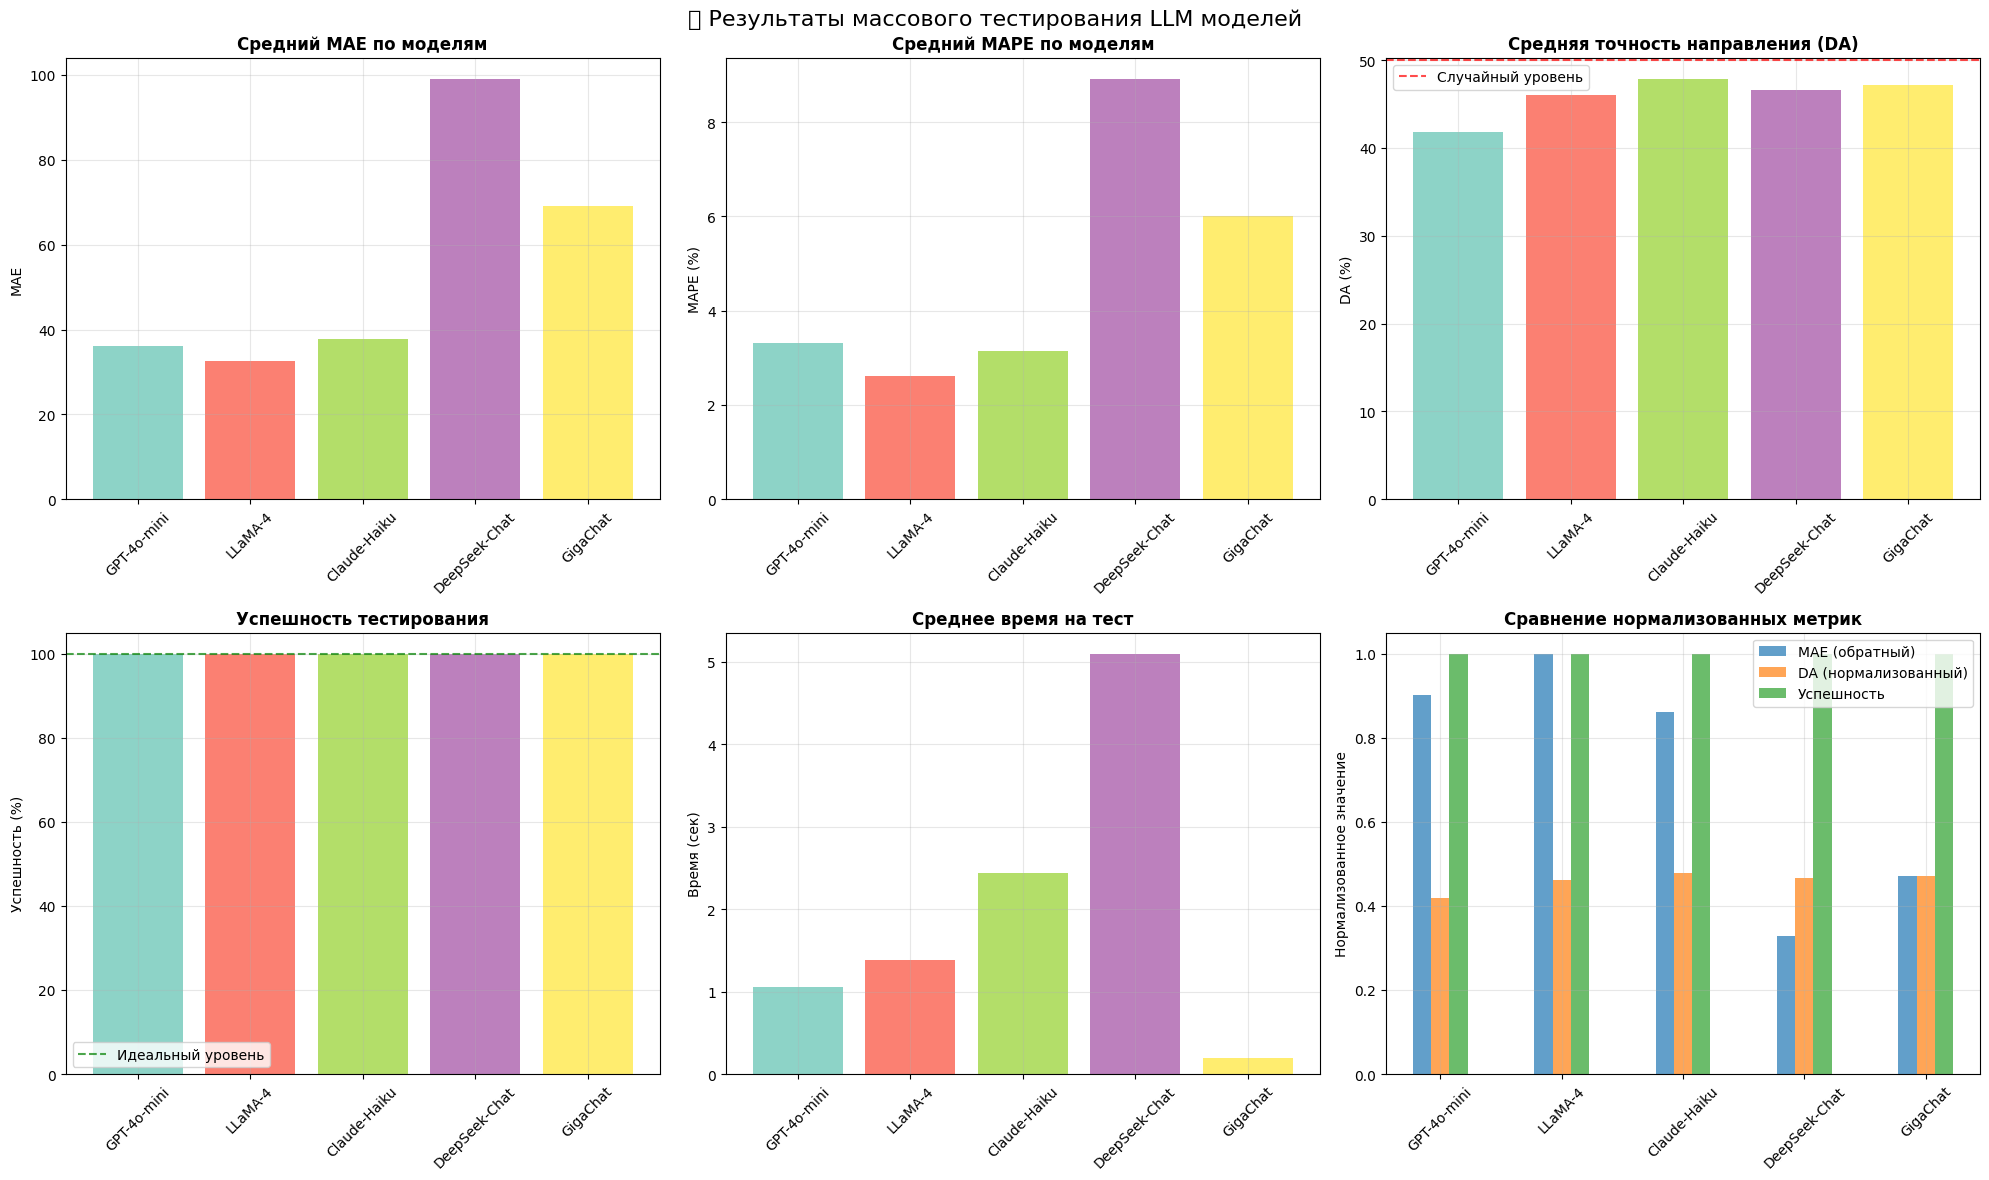


📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:
📊 Всего протестировано тикеров: 10
🤖 Протестировано моделей: 5
✅ Успешных тестов: 50/50 (100.0%)

🏆 ТОП-3 МОДЕЛИ:
📉 MAE: ['LLaMA-4', 'GPT-4o-mini', 'Claude-Haiku']
📊 MAPE: ['LLaMA-4', 'Claude-Haiku', 'GPT-4o-mini']
🎯 DA: ['Claude-Haiku', 'GigaChat', 'DeepSeek-Chat']
⚡ Скорость: ['GigaChat', 'GPT-4o-mini', 'LLaMA-4']


In [215]:
# 📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ МАССОВОГО ТЕСТИРОВАНИЯ

def visualize_mass_testing_results(summary_df, ticker_results):
    """Создание визуализаций для результатов массового тестирования"""
    
    # Фильтруем модели с успешными результатами
    valid_models = summary_df[summary_df['Успешных тестов'] > 0].copy()
    
    if valid_models.empty:
        print("❌ Нет данных для визуализации")
        return
    
    # Создаем фигуру с подграфиками
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('🔬 Результаты массового тестирования LLM моделей', fontsize=16, y=0.98)
    
    model_names = valid_models['Модель'].tolist()
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
    
    # 1. MAE по моделям
    axes[0,0].bar(model_names, valid_models['Средний MAE'], color=colors)
    axes[0,0].set_title('Средний MAE по моделям', fontweight='bold')
    axes[0,0].set_ylabel('MAE')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. MAPE по моделям
    axes[0,1].bar(model_names, valid_models['Средний MAPE (%)'], color=colors)
    axes[0,1].set_title('Средний MAPE по моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Directional Accuracy
    axes[0,2].bar(model_names, valid_models['Средний DA (%)'], color=colors)
    axes[0,2].set_title('Средняя точность направления (DA)', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Случайный уровень')
    axes[0,2].tick_params(axis='x', rotation=45)
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # 4. Успешность тестов
    axes[1,0].bar(model_names, valid_models['Успешность (%)'], color=colors)
    axes[1,0].set_title('Успешность тестирования', fontweight='bold')
    axes[1,0].set_ylabel('Успешность (%)')
    axes[1,0].axhline(y=100, color='green', linestyle='--', alpha=0.7, label='Идеальный уровень')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # 5. Среднее время выполнения
    axes[1,1].bar(model_names, valid_models['Среднее время (с)'], color=colors)
    axes[1,1].set_title('Среднее время на тест', fontweight='bold')
    axes[1,1].set_ylabel('Время (сек)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # 6. Радарная диаграмма сравнения моделей
    ax = axes[1,2]
    ax.clear()
    
    # Нормализация метрик для радарной диаграммы
    metrics_to_plot = ['Средний MAE', 'Средний MAPE (%)', 'Средний DA (%)', 'Успешность (%)', 'Среднее время (с)']
    
    # Создаем простую сравнительную диаграмму вместо радарной
    x_pos = np.arange(len(model_names))
    width = 0.15
    
    # Нормализуем метрики (MAE и MAPE - чем меньше, тем лучше; DA и Успешность - чем больше, тем лучше)
    mae_norm = 1 / (valid_models['Средний MAE'] / valid_models['Средний MAE'].min())
    da_norm = valid_models['Средний DA (%)'] / 100
    success_norm = valid_models['Успешность (%)'] / 100
    
    ax.bar(x_pos - width, mae_norm, width, label='MAE (обратный)', alpha=0.7)
    ax.bar(x_pos, da_norm, width, label='DA (нормализованный)', alpha=0.7)
    ax.bar(x_pos + width, success_norm, width, label='Успешность', alpha=0.7)
    
    ax.set_title('Сравнение нормализованных метрик', fontweight='bold')
    ax.set_ylabel('Нормализованное значение')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Дополнительная статистика
    print(f"\n📈 ДОПОЛНИТЕЛЬНАЯ СТАТИСТИКА:")
    print(f"📊 Всего протестировано тикеров: {len(ticker_results)}")
    print(f"🤖 Протестировано моделей: {len(valid_models)}")
    total_tests = valid_models['Всего тестов'].sum()
    successful_tests = valid_models['Успешных тестов'].sum()
    print(f"✅ Успешных тестов: {successful_tests}/{total_tests} ({successful_tests/total_tests*100:.1f}%)")
    
    # Топ-3 модели по каждой метрике
    if len(valid_models) >= 3:
        print(f"\n🏆 ТОП-3 МОДЕЛИ:")
        print(f"📉 MAE: {valid_models.nsmallest(3, 'Средний MAE')['Модель'].tolist()}")
        print(f"📊 MAPE: {valid_models.nsmallest(3, 'Средний MAPE (%)')['Модель'].tolist()}")
        print(f"🎯 DA: {valid_models.nlargest(3, 'Средний DA (%)')['Модель'].tolist()}")
        print(f"⚡ Скорость: {valid_models.nsmallest(3, 'Среднее время (с)')['Модель'].tolist()}")

# Создаем визуализацию если есть результаты
if 'summary_df' in locals() and not summary_df.empty:
    visualize_mass_testing_results(summary_df, ticker_results)
else:
    print("⚠️ Нет результатов для визуализации. Сначала запустите тестирование.")

## 📋 Выводы и рекомендации

### Особенности LLM в прогнозировании временных рядов:

#### ✅ **Преимущества LLM подхода:**
1. **Zero-shot прогнозирование** - модели работают без дообучения
2. **Понимание контекста** - анализ статистических паттернов через естественный язык
3. **Гибкость** - легкая адаптация под разные типы данных
4. **Интерпретируемость** - можно получить объяснение предсказаний

#### ⚠️ **Ограничения LLM подхода:**
1. **Скорость** - медленнее традиционных ML моделей
2. **Стабильность** - возможны сбои API и парсинга ответов
3. **Стоимость** - затраты на API вызовы
4. **Детерминизм** - результаты могут варьироваться между запросами

### Сравнение с другими подходами:

| Аспект | Traditional ML | Deep Learning | AutoML | **LLM** |
|--------|---------------|---------------|--------|---------|
| Скорость обучения | ⭐⭐⭐ | ⭐ | ⭐⭐ | **⭐⭐⭐** |
| Скорость инференса | ⭐⭐⭐ | ⭐⭐ | ⭐⭐ | **⭐** |
| Настройка гиперпараметров | ⭐ | ⭐ | ⭐⭐⭐ | **⭐⭐⭐** |
| Интерпретируемость | ⭐⭐ | ⭐ | ⭐ | **⭐⭐⭐** |
| Обобщающая способность | ⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ | **⭐⭐** |

### Рекомендации по использованию:

1. **Для исследований и прототипирования** - LLM отлично подходят
2. **Для продакшена** - стоит рассмотреть гибридные подходы
3. **Для объяснимости** - LLM предоставляют лучшие возможности
4. **Для масштабирования** - традиционные ML модели более эффективны


In [216]:
# 💾 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ И ИТОГОВЫЕ ВЫВОДЫ

def save_experiment_results(summary_df, ticker_results, all_results):
    """Сохранение результатов эксперимента"""
    
    from datetime import datetime
    import pickle
    import json
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Подготовка данных для сохранения
    experiment_data = {
        'metadata': {
            'timestamp': datetime.now().isoformat(),
            'experiment_type': 'mass_llm_testing',
            'models_tested': summary_df['Модель'].tolist() if not summary_df.empty else [],
            'tickers_tested': list(ticker_results.keys()),
            'window_size': 50,  # Адаптивный размер окна
            'patch_size': PATCH_SIZE,
            'test_size': 3,
            'total_models': len(LLM_MODELS)
        },
        'summary_metrics': summary_df.to_dict('records') if not summary_df.empty else [],
        'detailed_results': ticker_results,
        'raw_results': all_results,
        'config': {
            'available_models': {k: v['description'] for k, v in LLM_MODELS.items()},
            'api_endpoints': {
                'openrouter': 'https://openrouter.ai/api/v1/chat/completions',
                'deepseek': 'https://api.deepseek.com/chat/completions',
                'gigachat': 'Sberbank GigaChat API'
            }
        }
    }
    
    # Сохранение в разных форматах
    try:
        # Pickle для полных данных
        pickle_file = f"llm_mass_testing_results_{timestamp}.pkl"
        with open(pickle_file, 'wb') as f:
            pickle.dump(experiment_data, f)
        print(f"💾 Полные результаты сохранены: {pickle_file}")
        
        # JSON для метаданных и сводки (без сложных объектов)
        json_data = {
            'metadata': experiment_data['metadata'],
            'summary_metrics': experiment_data['summary_metrics']
        }
        json_file = f"llm_testing_summary_{timestamp}.json"
        with open(json_file, 'w', encoding='utf-8') as f:
            json.dump(json_data, f, ensure_ascii=False, indent=2)
        print(f"📋 Сводка сохранена: {json_file}")
        
        # CSV для удобного анализа
        if not summary_df.empty:
            csv_file = f"llm_metrics_summary_{timestamp}.csv"
            summary_df.to_csv(csv_file, index=False, encoding='utf-8')
            print(f"📊 CSV таблица сохранена: {csv_file}")
            
    except Exception as e:
        print(f"❌ Ошибка сохранения: {e}")

def generate_final_conclusions(summary_df, ticker_results):
    """Генерация итоговых выводов эксперимента"""
    
    print("\n" + "="*80)
    print("🎯 ИТОГОВЫЕ ВЫВОДЫ ИССЛЕДОВАНИЯ LLM В ПРОГНОЗИРОВАНИИ ВРЕМЕННЫХ РЯДОВ")
    print("="*80)
    
    if summary_df.empty:
        print("❌ Нет результатов для анализа")
        return
    
    valid_models = summary_df[summary_df['Успешных тестов'] > 0]
    
    print(f"\n📊 ОБЩАЯ СТАТИСТИКА:")
    print(f"   • Протестировано моделей: {len(summary_df)}")
    print(f"   • Успешных моделей: {len(valid_models)}")
    print(f"   • Протестировано тикеров: {len(ticker_results)}")
    print(f"   • Общий объем тестов: {summary_df['Всего тестов'].sum()}")
    print(f"   • Успешных тестов: {summary_df['Успешных тестов'].sum()}")
    
    if not valid_models.empty:
        print(f"\n🏆 ЛИДЕРЫ ПО КАТЕГОРИЯМ:")
        
        # Лучшие модели
        best_mae = valid_models.loc[valid_models['Средний MAE'].idxmin()]
        best_speed = valid_models.loc[valid_models['Среднее время (с)'].idxmin()]
        best_reliability = valid_models.loc[valid_models['Успешность (%)'].idxmax()]
        
        print(f"   📉 Лучшая точность (MAE): {best_mae['Модель']} ({best_mae['Средний MAE']:.3f})")
        print(f"   ⚡ Самая быстрая: {best_speed['Модель']} ({best_speed['Среднее время (с)']:.1f}с)")
        print(f"   🛡️ Самая надежная: {best_reliability['Модель']} ({best_reliability['Успешность (%)']:.1f}%)")
        
        print(f"\n💡 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ:")
        
        # Анализ соотношения точность/скорость
        valid_models['efficiency_score'] = (1 / valid_models['Средний MAE']) / valid_models['Среднее время (с)']
        best_efficiency = valid_models.loc[valid_models['efficiency_score'].idxmax()]
        
        print(f"   🎯 Для продакшена: {best_efficiency['Модель']} (лучшее соотношение точность/скорость)")
        print(f"   🔬 Для исследований: {best_mae['Модель']} (максимальная точность)")
        print(f"   ⚡ Для быстрого прототипирования: {best_speed['Модель']} (максимальная скорость)")
        
        # Анализ стабильности
        if len(valid_models) > 1:
            mae_std = valid_models['Средний MAE'].std()
            da_std = valid_models['Средний DA (%)'].std()
            print(f"\n📈 АНАЛИЗ СТАБИЛЬНОСТИ:")
            print(f"   • Разброс MAE между моделями: {mae_std:.3f}")
            print(f"   • Разброс DA между моделями: {da_std:.1f}%")
            
            if mae_std < 1.0:
                print("   ✅ Модели показывают схожую точность")
            else:
                print("   ⚠️ Значительные различия в точности между моделями")
    
    print(f"\n🔮 ПЕРСПЕКТИВЫ РАЗВИТИЯ:")
    print("   • Тестирование на больших горизонтах прогнозирования")
    print("   • Комбинирование предсказаний нескольких LLM (ансамбли)")
    print("   • Оптимизация промптов для каждого типа временных рядов")
    print("   • Интеграция внешних данных (новости, макроэкономика)")
    
    print("\n" + "="*80)

# Выполняем сохранение и выводы, если есть результаты
if 'summary_df' in locals() and 'ticker_results' in locals():
    save_experiment_results(summary_df, ticker_results, all_results)
    generate_final_conclusions(summary_df, ticker_results)
    print("\n✨ Исследование завершено! Все результаты сохранены. ✨")
else:
    print("⚠️ Нет результатов для сохранения. Сначала запустите тестирование в предыдущих ячейках.")


💾 Полные результаты сохранены: llm_mass_testing_results_20250618_211821.pkl
📋 Сводка сохранена: llm_testing_summary_20250618_211821.json
📊 CSV таблица сохранена: llm_metrics_summary_20250618_211821.csv

🎯 ИТОГОВЫЕ ВЫВОДЫ ИССЛЕДОВАНИЯ LLM В ПРОГНОЗИРОВАНИИ ВРЕМЕННЫХ РЯДОВ

📊 ОБЩАЯ СТАТИСТИКА:
   • Протестировано моделей: 5
   • Успешных моделей: 5
   • Протестировано тикеров: 10
   • Общий объем тестов: 50
   • Успешных тестов: 50

🏆 ЛИДЕРЫ ПО КАТЕГОРИЯМ:
   📉 Лучшая точность (MAE): LLaMA-4 (32.515)
   ⚡ Самая быстрая: GigaChat (0.2с)
   🛡️ Самая надежная: GPT-4o-mini (100.0%)

💡 РЕКОМЕНДАЦИИ ПО ИСПОЛЬЗОВАНИЮ:
   🎯 Для продакшена: GigaChat (лучшее соотношение точность/скорость)
   🔬 Для исследований: LLaMA-4 (максимальная точность)
   ⚡ Для быстрого прототипирования: GigaChat (максимальная скорость)

📈 АНАЛИЗ СТАБИЛЬНОСТИ:
   • Разброс MAE между моделями: 28.754
   • Разброс DA между моделями: 2.4%
   ⚠️ Значительные различия в точности между моделями

🔮 ПЕРСПЕКТИВЫ РАЗВИТИЯ:
   • Тести

In [230]:
SELECTED_MODELS = {
    'DeepSeek-Chat': {
        'predictor_class': DeepSeekPredictor,
        'api_key': API_KEYS['deepseek'],
        'description': 'Специализированная модель от DeepSeek'
    }
}

print("🚀 ПАРАМЕТРЫ ТЕСТИРОВАНИЯ:")
print(f"📊 Выбранные модели: {len(SELECTED_MODELS) if SELECTED_MODELS else len(LLM_MODELS)}")
if SELECTED_MODELS:
    for model in SELECTED_MODELS:
        if model in LLM_MODELS:
            print(f"  • {model}")

# Запуск тестирования
deep_results, deep_ticker_results = test_llm_models_on_all_tickers(
    models_to_test=SELECTED_MODELS,
    max_models=3,
    test_size=0.05  # Количество тестовых шагов на каждом тикере
)

# Создание сводного отчета
summary_df = create_summary_report(deep_results, deep_ticker_results)

print(f"\n✨ Тестирование завершено! ✨")

🚀 ПАРАМЕТРЫ ТЕСТИРОВАНИЯ:
📊 Выбранные модели: 1
  • DeepSeek-Chat
Загружен AFLT: 2375 точек
Загружен LKOH: 2375 точек
Загружен MOEX: 2375 точек
Загружен NVTK: 2373 точек
Загружен PIKK: 2375 точек
Загружен SBER: 2375 точек
Загружен VKCO: 1197 точек
Загружен VTBR: 1722 точек
Загружен X5: 1499 точек
Загружен YDEX: 2339 точек
📊 Загружено тикеров: 10
🤖 Тестируемые модели (1):
  • DeepSeek-Chat: Специализированная модель от DeepSeek

🚀 Начинаем тестирование на 10 тикерах...

📈 Тикер 1/10: AFLT (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=54.88, Pred=56.10, Time=5.10s
Шаг 2/119: True=52.15, Pred=54.50, Time=2.87s
Шаг 3/119: True=50.51, Pred=53.50, Time=3.44s
Шаг 4/119: True=48.52, Pred=48.50, Time=3.29s


Шаг 5/119: True=48.52, Pred=47.25, Time=10.68s
Шаг 6/119: True=50.15, Pred=47.20, Time=4.13s
Шаг 7/119: True=50.86, Pred=48.90, Time=4.60s
Шаг 8/119: True=51.18, Pred=51.20, Time=3.31s
Шаг 9/119: True=49.80, Pred=51.85, Time=3.36s
Шаг 10/119: True=49.97, Pred=49.50, Time=3.13s
Шаг 11/119: True=48.54, Pred=49.50, Time=2.98s
Шаг 12/119: True=48.28, Pred=47.85, Time=2.73s
Шаг 13/119: True=47.70, Pred=47.85, Time=2.90s
Шаг 14/119: True=47.67, Pred=47.10, Time=5.32s
Шаг 15/119: True=49.30, Pred=47.20, Time=3.28s
Шаг 16/119: True=50.12, Pred=48.90, Time=4.26s
Шаг 17/119: True=54.95, Pred=48.90, Time=2.97s


Шаг 18/119: True=56.09, Pred=54.95, Time=15.02s


Шаг 19/119: True=53.62, Pred=56.09, Time=14.68s
Шаг 20/119: True=54.86, Pred=53.50, Time=3.25s
Шаг 21/119: True=55.04, Pred=54.50, Time=3.47s
Шаг 22/119: True=55.65, Pred=54.25, Time=4.73s


Шаг 23/119: True=58.38, Pred=56.50, Time=8.22s


Шаг 24/119: True=59.06, Pred=58.80, Time=7.47s


Шаг 25/119: True=58.13, Pred=58.50, Time=10.30s


Шаг 26/119: True=58.99, Pred=59.20, Time=9.80s
Шаг 27/119: True=59.65, Pred=58.50, Time=4.49s
Шаг 28/119: True=58.43, Pred=59.98, Time=4.36s
Шаг 29/119: True=60.99, Pred=58.12, Time=2.79s
Шаг 30/119: True=60.50, Pred=61.50, Time=2.84s
Шаг 31/119: True=61.56, Pred=61.20, Time=2.97s
Шаг 32/119: True=62.25, Pred=61.90, Time=3.09s
Шаг 33/119: True=61.36, Pred=62.85, Time=4.34s
Шаг 34/119: True=61.80, Pred=61.75, Time=3.17s
Шаг 35/119: True=61.45, Pred=62.50, Time=3.30s
Шаг 36/119: True=61.50, Pred=61.20, Time=3.08s
Шаг 37/119: True=60.37, Pred=61.30, Time=3.52s
Шаг 38/119: True=60.89, Pred=60.05, Time=2.75s
Шаг 39/119: True=61.86, Pred=60.45, Time=2.61s
Шаг 40/119: True=60.15, Pred=61.95, Time=2.83s
Шаг 41/119: True=61.11, Pred=60.75, Time=2.84s
Шаг 42/119: True=62.19, Pred=61.50, Time=3.13s
Шаг 43/119: True=64.43, Pred=61.85, Time=2.50s


Шаг 44/119: True=63.86, Pred=64.85, Time=12.55s
Шаг 45/119: True=63.96, Pred=64.50, Time=2.88s
Шаг 46/119: True=62.66, Pred=64.50, Time=2.64s
Шаг 47/119: True=64.73, Pred=63.50, Time=2.97s
Шаг 48/119: True=64.35, Pred=64.90, Time=2.90s
Шаг 49/119: True=64.25, Pred=64.75, Time=3.27s
Шаг 50/119: True=64.81, Pred=64.75, Time=2.95s
Шаг 51/119: True=64.67, Pred=64.90, Time=3.07s
Шаг 52/119: True=69.39, Pred=64.75, Time=3.35s
Шаг 53/119: True=67.97, Pred=70.50, Time=2.87s
Шаг 54/119: True=68.94, Pred=68.50, Time=3.26s
Шаг 55/119: True=74.51, Pred=68.50, Time=2.36s


Шаг 56/119: True=71.89, Pred=75.80, Time=8.02s
Шаг 57/119: True=75.03, Pred=72.45, Time=3.41s
Шаг 58/119: True=77.07, Pred=76.50, Time=4.31s
Шаг 59/119: True=76.22, Pred=78.50, Time=4.77s
Шаг 60/119: True=76.95, Pred=77.85, Time=4.37s


Шаг 61/119: True=77.22, Pred=75.43, Time=10.48s
Шаг 62/119: True=74.69, Pred=77.85, Time=2.74s
Шаг 63/119: True=71.51, Pred=76.50, Time=3.15s


Шаг 64/119: True=73.59, Pred=73.85, Time=9.60s
Шаг 65/119: True=73.81, Pred=74.85, Time=5.16s
Шаг 66/119: True=72.93, Pred=75.20, Time=3.95s
Шаг 67/119: True=73.98, Pred=73.85, Time=3.07s
Шаг 68/119: True=76.35, Pred=74.85, Time=4.59s
Шаг 69/119: True=74.20, Pred=76.85, Time=4.28s
Шаг 70/119: True=73.82, Pred=75.32, Time=3.29s
Шаг 71/119: True=75.10, Pred=74.85, Time=3.92s
Шаг 72/119: True=74.71, Pred=76.50, Time=2.89s
Шаг 73/119: True=74.26, Pred=75.20, Time=3.13s
Шаг 74/119: True=73.20, Pred=75.10, Time=4.17s
Шаг 75/119: True=73.87, Pred=74.05, Time=2.78s
Шаг 76/119: True=74.56, Pred=74.50, Time=2.94s
Шаг 77/119: True=74.72, Pred=74.30, Time=3.14s
Шаг 78/119: True=75.95, Pred=75.10, Time=3.02s
Шаг 79/119: True=76.35, Pred=76.42, Time=4.12s
Шаг 80/119: True=75.44, Pred=76.85, Time=4.47s


Шаг 81/119: True=76.05, Pred=76.20, Time=16.54s
Шаг 82/119: True=75.80, Pred=76.35, Time=3.25s
Шаг 83/119: True=75.48, Pred=76.10, Time=2.73s
Шаг 84/119: True=74.36, Pred=75.10, Time=3.07s
Шаг 85/119: True=74.60, Pred=74.85, Time=3.69s
Шаг 86/119: True=73.25, Pred=74.10, Time=2.68s
Шаг 87/119: True=71.00, Pred=74.10, Time=2.95s
Шаг 88/119: True=67.21, Pred=72.50, Time=3.25s


Шаг 89/119: True=66.45, Pred=67.21, Time=16.74s


Шаг 90/119: True=66.45, Pred=66.45, Time=17.74s


Шаг 91/119: True=69.63, Pred=66.45, Time=18.16s


Шаг 92/119: True=66.02, Pred=66.45, Time=11.43s
Шаг 93/119: True=67.43, Pred=65.50, Time=3.69s
Шаг 94/119: True=70.36, Pred=66.85, Time=4.87s
Шаг 95/119: True=66.46, Pred=69.85, Time=5.32s
Шаг 96/119: True=65.56, Pred=65.50, Time=2.85s
Шаг 97/119: True=66.48, Pred=69.85, Time=3.94s
Шаг 98/119: True=64.07, Pred=66.10, Time=3.07s
Шаг 99/119: True=62.33, Pred=65.50, Time=4.49s


Шаг 100/119: True=67.76, Pred=64.50, Time=9.14s
Шаг 101/119: True=66.84, Pred=66.85, Time=4.23s
Шаг 102/119: True=69.60, Pred=67.50, Time=4.41s
Шаг 103/119: True=71.14, Pred=68.50, Time=5.09s
Шаг 104/119: True=71.40, Pred=72.50, Time=2.87s


Шаг 105/119: True=68.69, Pred=72.50, Time=13.88s
Шаг 106/119: True=69.35, Pred=68.20, Time=4.03s
Шаг 107/119: True=69.35, Pred=68.72, Time=5.60s
Шаг 108/119: True=71.15, Pred=68.42, Time=3.76s
Шаг 109/119: True=70.18, Pred=70.85, Time=4.13s
Шаг 110/119: True=72.45, Pred=70.85, Time=3.16s
Шаг 111/119: True=73.49, Pred=71.50, Time=4.11s


Шаг 112/119: True=72.73, Pred=73.49, Time=16.93s
Шаг 113/119: True=72.17, Pred=72.90, Time=3.88s
Шаг 114/119: True=74.54, Pred=72.85, Time=2.52s
Шаг 115/119: True=74.31, Pred=74.85, Time=3.90s
Шаг 116/119: True=74.87, Pred=74.85, Time=3.03s


Шаг 117/119: True=73.50, Pred=75.50, Time=7.42s
Шаг 118/119: True=70.79, Pred=73.85, Time=5.77s
Шаг 119/119: True=71.12, Pred=72.50, Time=2.80s
✅ MAE=1.49, MAPE=2.3%, DA=39.0%, 595.9s

📈 Тикер 2/10: LKOH (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=6905.50, Pred=6905.00, Time=2.71s
Шаг 2/119: True=6860.50, Pred=6902.50, Time=3.68s
Шаг 3/119: True=6810.00, Pred=6865.00, Time=3.25s
Шаг 4/119: True=6771.00, Pred=6865.00, Time=2.86s
Шаг 5/119: True=6720.50, Pred=6895.00, Time=2.99s
Шаг 6/119: True=6841.00, Pred=6750.00, Time=3.41s
Шаг 7/119: True=6860.00, Pred=6895.50, Time=3.23s
Шаг 8/119: True=6973.00, Pred=6895.00, Time=3.73s


Шаг 9/119: True=6894.00, Pred=6945.50, Time=17.31s
Шаг 10/119: True=6895.50, Pred=6898.50, Time=3.69s
Шаг 11/119: True=6862.50, Pred=6890.00, Time=4.38s
Шаг 12/119: True=6800.00, Pred=6868.50, Time=2.41s
Шаг 13/119: True=6779.50, Pred=6855.00, Time=2.55s
Шаг 14/119: True=6290.50, Pred=6865.50, Time=4.18s
Шаг 15/119: True=6375.00, Pred=6779.50, Time=7.08s
Шаг 16/119: True=6294.00, Pred=6305.00, Time=3.80s
Шаг 17/119: True=6725.00, Pred=6750.00, Time=4.15s
Шаг 18/119: True=6919.00, Pred=6742.50, Time=2.80s
Шаг 19/119: True=6833.00, Pred=6942.50, Time=3.01s


Шаг 20/119: True=6987.50, Pred=6900.00, Time=13.78s
Шаг 21/119: True=7003.00, Pred=6902.50, Time=5.48s
Шаг 22/119: True=6990.50, Pred=6865.00, Time=3.98s
Шаг 23/119: True=6998.00, Pred=6925.50, Time=2.66s
Шаг 24/119: True=7235.00, Pred=6945.00, Time=3.97s


Шаг 25/119: True=7122.00, Pred=7235.00, Time=17.99s
Шаг 26/119: True=7088.00, Pred=7050.00, Time=3.88s
Шаг 27/119: True=7089.00, Pred=7055.50, Time=3.35s
Шаг 28/119: True=6947.50, Pred=7108.50, Time=2.89s
Шаг 29/119: True=7022.50, Pred=6975.00, Time=3.08s
Шаг 30/119: True=7010.50, Pred=7028.50, Time=3.24s
Шаг 31/119: True=7115.50, Pred=7018.50, Time=2.85s
Шаг 32/119: True=7178.50, Pred=7082.50, Time=3.41s
Шаг 33/119: True=7208.00, Pred=7156.50, Time=4.42s
Шаг 34/119: True=7342.00, Pred=7150.50, Time=3.27s
Шаг 35/119: True=7194.00, Pred=7150.00, Time=3.93s
Шаг 36/119: True=7239.50, Pred=7175.50, Time=2.98s
Шаг 37/119: True=7215.00, Pred=7250.00, Time=3.22s
Шаг 38/119: True=7215.00, Pred=7218.50, Time=4.29s
Шаг 39/119: True=7199.50, Pred=7210.00, Time=2.71s
Шаг 40/119: True=7065.50, Pred=7208.50, Time=3.40s
Шаг 41/119: True=7160.00, Pred=7112.50, Time=3.15s
Шаг 42/119: True=7192.00, Pred=7150.50, Time=3.31s
Шаг 43/119: True=7166.00, Pred=7180.50, Time=4.69s
Шаг 44/119: True=7171.00, Pred

Шаг 52/119: True=7676.00, Pred=7250.00, Time=14.59s
Шаг 53/119: True=7534.00, Pred=7270.00, Time=2.94s


Шаг 54/119: True=7492.50, Pred=7534.00, Time=17.64s
Шаг 55/119: True=7784.50, Pred=7548.50, Time=8.04s


Шаг 56/119: True=7644.50, Pred=7784.50, Time=18.41s
Шаг 57/119: True=7714.50, Pred=7265.00, Time=4.43s
Шаг 58/119: True=7720.00, Pred=7750.00, Time=3.90s
Шаг 59/119: True=7709.50, Pred=7742.50, Time=3.71s
Шаг 60/119: True=7737.50, Pred=7648.50, Time=5.17s
Шаг 61/119: True=7729.00, Pred=7752.50, Time=3.07s
Шаг 62/119: True=7555.00, Pred=7735.00, Time=2.91s
Шаг 63/119: True=7497.00, Pred=7555.00, Time=6.30s
Шаг 64/119: True=7546.50, Pred=7505.50, Time=3.29s
Шаг 65/119: True=7555.00, Pred=7632.50, Time=7.18s
Шаг 66/119: True=7531.00, Pred=7542.50, Time=3.76s
Шаг 67/119: True=7341.50, Pred=7548.50, Time=3.26s
Шаг 68/119: True=7393.00, Pred=7425.00, Time=3.49s
Шаг 69/119: True=7241.00, Pred=7385.00, Time=2.78s


Шаг 70/119: True=7175.00, Pred=7375.00, Time=15.33s
Шаг 71/119: True=7225.00, Pred=7150.00, Time=3.95s
Шаг 72/119: True=7185.00, Pred=7228.00, Time=4.06s
Шаг 73/119: True=7248.50, Pred=7150.00, Time=3.15s
Шаг 74/119: True=7205.00, Pred=7228.50, Time=4.25s
Шаг 75/119: True=7130.00, Pred=7240.00, Time=3.62s
Шаг 76/119: True=7149.50, Pred=7105.00, Time=2.52s
Шаг 77/119: True=7167.00, Pred=7150.00, Time=4.41s
Шаг 78/119: True=7209.50, Pred=7158.00, Time=3.21s
Шаг 79/119: True=7222.50, Pred=7225.00, Time=5.15s
Шаг 80/119: True=7183.00, Pred=7228.50, Time=3.48s
Шаг 81/119: True=7221.00, Pred=7175.00, Time=4.70s
Шаг 82/119: True=7293.50, Pred=7235.00, Time=4.62s
Шаг 83/119: True=7346.50, Pred=7250.00, Time=3.52s
Шаг 84/119: True=7291.00, Pred=7378.50, Time=3.53s
Шаг 85/119: True=7265.00, Pred=7285.50, Time=3.69s
Шаг 86/119: True=7185.00, Pred=7250.00, Time=6.44s
Шаг 87/119: True=7108.50, Pred=7158.00, Time=3.47s
Шаг 88/119: True=7064.50, Pred=7100.00, Time=3.32s
Шаг 89/119: True=7013.50, Pred

Шаг 101/119: True=6375.50, Pred=6507.00, Time=18.66s
Шаг 102/119: True=6508.00, Pred=6370.00, Time=2.87s
Шаг 103/119: True=6582.00, Pred=6506.50, Time=3.01s
Шаг 104/119: True=6562.00, Pred=6650.00, Time=3.92s


Шаг 105/119: True=6474.00, Pred=6562.00, Time=19.45s
Шаг 106/119: True=6466.00, Pred=6432.50, Time=5.45s
Шаг 107/119: True=6515.00, Pred=6372.50, Time=3.33s
Шаг 108/119: True=6719.00, Pred=6425.00, Time=3.36s
Шаг 109/119: True=6629.50, Pred=6685.00, Time=5.08s
Шаг 110/119: True=6732.50, Pred=6608.50, Time=3.44s
Шаг 111/119: True=6764.00, Pred=6758.00, Time=3.06s


Шаг 112/119: True=6743.00, Pred=6764.00, Time=16.28s
Шаг 113/119: True=6683.50, Pred=6650.00, Time=3.96s
Шаг 114/119: True=6856.50, Pred=6705.00, Time=2.92s
Шаг 115/119: True=6904.00, Pred=6865.00, Time=21.60s
Шаг 116/119: True=6914.00, Pred=6948.50, Time=2.83s


Шаг 117/119: True=6827.00, Pred=6948.50, Time=17.03s
Шаг 118/119: True=6725.00, Pred=6865.00, Time=3.08s
Шаг 119/119: True=6684.00, Pred=6712.50, Time=3.07s
✅ MAE=101.53, MAPE=1.5%, DA=48.3%, 611.8s

📈 Тикер 3/10: MOEX (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=183.88, Pred=185.25, Time=2.94s
Шаг 2/119: True=184.88, Pred=182.50, Time=3.91s
Шаг 3/119: True=191.76, Pred=180.50, Time=3.30s
Шаг 4/119: True=183.72, Pred=187.50, Time=2.97s
Шаг 5/119: True=179.90, Pred=185.45, Time=2.99s
Шаг 6/119: True=181.18, Pred=178.50, Time=3.23s
Шаг 7/119: True=178.20, Pred=178.50, Time=6.41s
Шаг 8/119: True=183.89, Pred=175.50, Time=3.02s
Шаг 9/119: True=179.08, Pred=182.50, Time=3.06s
Шаг 10/119: True=180.30, Pred=178.50, Time=2.96s
Шаг 11/119: True=175.71, Pred=178.50, Time=3.28s
Шаг 12/119: True=176.01

Шаг 18/119: True=189.67, Pred=188.50, Time=16.93s
Шаг 19/119: True=186.09, Pred=186.45, Time=3.24s
Шаг 20/119: True=196.61, Pred=184.50, Time=4.34s


Шаг 21/119: True=194.08, Pred=196.61, Time=15.59s
Шаг 22/119: True=192.45, Pred=181.50, Time=2.75s
Шаг 23/119: True=192.61, Pred=186.25, Time=4.15s
Шаг 24/119: True=199.22, Pred=191.42, Time=4.11s
Шаг 25/119: True=194.83, Pred=193.72, Time=3.88s
Шаг 26/119: True=195.00, Pred=192.50, Time=2.88s
Шаг 27/119: True=197.70, Pred=196.50, Time=3.96s
Шаг 28/119: True=191.72, Pred=195.50, Time=3.93s
Шаг 29/119: True=197.39, Pred=189.45, Time=3.05s
Шаг 30/119: True=200.54, Pred=196.50, Time=3.16s


Шаг 31/119: True=206.38, Pred=203.50, Time=16.17s


Шаг 32/119: True=207.09, Pred=207.50, Time=8.30s


Шаг 33/119: True=206.68, Pred=207.85, Time=8.27s


Шаг 34/119: True=207.40, Pred=206.68, Time=17.18s
Шаг 35/119: True=205.13, Pred=207.90, Time=3.12s
Шаг 36/119: True=206.46, Pred=205.85, Time=4.10s
Шаг 37/119: True=206.48, Pred=206.20, Time=5.49s
Шаг 38/119: True=206.34, Pred=205.90, Time=4.22s
Шаг 39/119: True=211.25, Pred=206.10, Time=3.34s
Шаг 40/119: True=206.73, Pred=208.50, Time=2.68s
Шаг 41/119: True=208.27, Pred=206.50, Time=3.78s
Шаг 42/119: True=205.13, Pred=208.90, Time=3.40s
Шаг 43/119: True=204.85, Pred=205.85, Time=2.62s
Шаг 44/119: True=205.01, Pred=203.50, Time=4.52s
Шаг 45/119: True=204.27, Pred=205.75, Time=4.28s
Шаг 46/119: True=200.08, Pred=204.05, Time=2.86s
Шаг 47/119: True=205.39, Pred=204.50, Time=3.77s
Шаг 48/119: True=204.12, Pred=205.85, Time=3.24s
Шаг 49/119: True=203.99, Pred=204.50, Time=2.93s
Шаг 50/119: True=206.10, Pred=204.50, Time=3.00s


Шаг 51/119: True=213.87, Pred=207.50, Time=9.13s
Шаг 52/119: True=226.61, Pred=214.50, Time=3.35s


Шаг 53/119: True=234.70, Pred=226.61, Time=16.94s
Шаг 54/119: True=229.95, Pred=240.50, Time=2.70s
Шаг 55/119: True=237.54, Pred=234.70, Time=3.27s
Шаг 56/119: True=237.98, Pred=245.00, Time=3.01s
Шаг 57/119: True=239.79, Pred=241.50, Time=3.14s
Шаг 58/119: True=238.79, Pred=245.50, Time=3.10s
Шаг 59/119: True=234.09, Pred=239.50, Time=2.92s
Шаг 60/119: True=234.30, Pred=236.50, Time=2.39s
Шаг 61/119: True=232.01, Pred=239.42, Time=4.15s
Шаг 62/119: True=224.00, Pred=234.50, Time=4.61s
Шаг 63/119: True=217.20, Pred=220.45, Time=3.34s


Шаг 64/119: True=219.20, Pred=220.50, Time=9.18s


Шаг 65/119: True=221.13, Pred=223.50, Time=15.36s
Шаг 66/119: True=221.24, Pred=223.50, Time=3.01s
Шаг 67/119: True=223.30, Pred=221.85, Time=3.05s
Шаг 68/119: True=224.46, Pred=225.50, Time=3.91s
Шаг 69/119: True=219.70, Pred=223.85, Time=3.79s
Шаг 70/119: True=216.27, Pred=221.45, Time=3.50s
Шаг 71/119: True=212.21, Pred=214.50, Time=2.89s
Шаг 72/119: True=209.86, Pred=210.45, Time=3.52s
Шаг 73/119: True=211.86, Pred=216.50, Time=3.34s
Шаг 74/119: True=211.60, Pred=212.50, Time=3.32s
Шаг 75/119: True=208.55, Pred=213.50, Time=3.09s
Шаг 76/119: True=212.48, Pred=207.50, Time=3.07s
Шаг 77/119: True=213.30, Pred=213.50, Time=3.25s
Шаг 78/119: True=215.69, Pred=214.50, Time=4.11s
Шаг 79/119: True=216.99, Pred=215.80, Time=3.06s


Шаг 80/119: True=214.00, Pred=217.50, Time=7.58s
Шаг 81/119: True=216.46, Pred=213.50, Time=3.17s
Шаг 82/119: True=215.24, Pred=216.98, Time=3.23s
Шаг 83/119: True=213.09, Pred=214.85, Time=3.09s


Шаг 84/119: True=209.50, Pred=215.50, Time=8.69s
Шаг 85/119: True=210.56, Pred=213.20, Time=2.98s
Шаг 86/119: True=207.53, Pred=210.12, Time=3.10s
Шаг 87/119: True=202.40, Pred=210.50, Time=3.22s
Шаг 88/119: True=198.74, Pred=207.50, Time=2.98s
Шаг 89/119: True=195.75, Pred=207.50, Time=3.67s
Шаг 90/119: True=195.75, Pred=192.50, Time=3.35s


Шаг 91/119: True=199.55, Pred=200.00, Time=17.10s


Шаг 92/119: True=193.69, Pred=205.50, Time=13.03s
Шаг 93/119: True=202.34, Pred=192.50, Time=2.83s
Шаг 94/119: True=200.49, Pred=207.50, Time=2.97s
Шаг 95/119: True=194.90, Pred=198.75, Time=4.34s
Шаг 96/119: True=193.77, Pred=193.50, Time=2.94s
Шаг 97/119: True=196.35, Pred=207.85, Time=4.28s
Шаг 98/119: True=192.95, Pred=196.10, Time=2.48s
Шаг 99/119: True=191.01, Pred=195.50, Time=2.74s
Шаг 100/119: True=195.30, Pred=188.50, Time=4.16s
Шаг 101/119: True=190.75, Pred=193.50, Time=3.25s
Шаг 102/119: True=193.72, Pred=189.50, Time=2.77s
Шаг 103/119: True=195.57, Pred=193.50, Time=3.19s


Шаг 104/119: True=197.40, Pred=195.57, Time=17.28s
Шаг 105/119: True=193.18, Pred=195.50, Time=3.76s
Шаг 106/119: True=191.81, Pred=192.50, Time=3.87s
Шаг 107/119: True=194.47, Pred=191.00, Time=3.18s
Шаг 108/119: True=195.25, Pred=193.50, Time=2.90s
Шаг 109/119: True=191.61, Pred=194.85, Time=3.63s
Шаг 110/119: True=197.45, Pred=191.20, Time=4.30s
Шаг 111/119: True=206.39, Pred=195.50, Time=3.35s
Шаг 112/119: True=205.01, Pred=203.72, Time=4.15s


Шаг 113/119: True=209.57, Pred=205.01, Time=16.53s
Шаг 114/119: True=208.02, Pred=208.50, Time=4.33s
Шаг 115/119: True=207.16, Pred=207.50, Time=4.51s
Шаг 116/119: True=207.87, Pred=207.23, Time=4.96s
Шаг 117/119: True=203.68, Pred=207.87, Time=3.48s
Шаг 118/119: True=199.60, Pred=201.45, Time=4.02s
Шаг 119/119: True=199.17, Pred=196.25, Time=3.16s
✅ MAE=3.84, MAPE=1.9%, DA=49.2%, 570.2s

📈 Тикер 4/10: NVTK (2373 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 2254 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=807.80, Pred=842.20, Time=4.24s
Шаг 2/119: True=828.00, Pred=802.40, Time=5.61s
Шаг 3/119: True=816.60, Pred=812.40, Time=7.27s
Шаг 4/119: True=835.60, Pred=810.20, Time=4.61s
Шаг 5/119: True=846.20, Pred=812.40, Time=5.52s
Шаг 6/119: True=824.00, Pred=833.20, Time=4.85s
Шаг 7/119: True=800.00, Pred=812.40, Time=6.02s
Шаг 8/119: True=830.40, P

Шаг 20/119: True=944.00, Pred=894.00, Time=15.77s


Шаг 21/119: True=915.40, Pred=944.00, Time=16.29s
Шаг 22/119: True=929.40, Pred=890.00, Time=4.24s
Шаг 23/119: True=949.80, Pred=850.00, Time=4.72s


Шаг 24/119: True=949.20, Pred=949.80, Time=18.84s
Шаг 25/119: True=951.80, Pred=841.20, Time=5.02s


Шаг 26/119: True=996.00, Pred=951.80, Time=18.93s


Шаг 27/119: True=963.80, Pred=996.00, Time=18.90s
Шаг 28/119: True=965.00, Pred=957.20, Time=4.44s
Шаг 29/119: True=976.60, Pred=961.40, Time=5.29s


Шаг 30/119: True=930.80, Pred=976.60, Time=41.98s
Шаг 31/119: True=969.00, Pred=930.00, Time=4.62s
Шаг 32/119: True=1007.40, Pred=975.20, Time=4.25s


Шаг 33/119: True=1009.00, Pred=1015.20, Time=9.28s


Шаг 34/119: True=1007.80, Pred=976.60, Time=11.59s


Шаг 35/119: True=990.20, Pred=1015.20, Time=10.70s
Шаг 36/119: True=1006.00, Pred=975.40, Time=4.38s
Шаг 37/119: True=974.40, Pred=1002.20, Time=3.25s
Шаг 38/119: True=998.80, Pred=985.20, Time=4.71s
Шаг 39/119: True=1017.60, Pred=1004.20, Time=3.50s
Шаг 40/119: True=1024.20, Pred=1019.80, Time=3.54s


Шаг 41/119: True=1029.80, Pred=1032.50, Time=10.34s
Шаг 42/119: True=1003.40, Pred=1035.20, Time=5.19s
Шаг 43/119: True=1022.40, Pred=1008.50, Time=3.33s
Шаг 44/119: True=1046.00, Pred=1025.20, Time=4.71s
Шаг 45/119: True=1085.60, Pred=1048.50, Time=3.94s
Шаг 46/119: True=1082.00, Pred=1095.80, Time=3.30s
Шаг 47/119: True=1070.20, Pred=1089.80, Time=4.00s
Шаг 48/119: True=1062.20, Pred=1078.50, Time=3.22s
Шаг 49/119: True=1100.00, Pred=1068.40, Time=3.04s
Шаг 50/119: True=1101.40, Pred=1050.20, Time=2.86s
Шаг 51/119: True=1101.80, Pred=1108.50, Time=3.17s
Шаг 52/119: True=1132.60, Pred=1108.50, Time=3.07s
Шаг 53/119: True=1167.80, Pred=1098.40, Time=3.13s
Шаг 54/119: True=1277.20, Pred=1168.50, Time=3.14s
Шаг 55/119: True=1255.80, Pred=1160.00, Time=4.80s
Шаг 56/119: True=1218.80, Pred=1278.50, Time=3.02s
Шаг 57/119: True=1292.80, Pred=1230.00, Time=24.42s
Шаг 58/119: True=1254.60, Pred=1320.50, Time=3.30s
Шаг 59/119: True=1280.00, Pred=1238.40, Time=2.77s
Шаг 60/119: True=1308.40, Pre

Шаг 101/119: True=1048.80, Pred=1178.20, Time=16.20s
Шаг 102/119: True=1102.00, Pred=1042.20, Time=4.76s
Шаг 103/119: True=1062.00, Pred=1098.20, Time=4.58s
Шаг 104/119: True=1115.00, Pred=1148.20, Time=4.27s
Шаг 105/119: True=1139.60, Pred=1142.50, Time=3.32s
Шаг 106/119: True=1139.80, Pred=1135.20, Time=3.10s
Шаг 107/119: True=1115.60, Pred=1125.60, Time=3.62s
Шаг 108/119: True=1159.00, Pred=1098.20, Time=3.34s
Шаг 109/119: True=1190.20, Pred=1145.20, Time=3.14s
Шаг 110/119: True=1219.80, Pred=1155.00, Time=3.60s
Шаг 111/119: True=1193.00, Pred=1215.20, Time=4.76s
Шаг 112/119: True=1237.00, Pred=1178.40, Time=3.09s
Шаг 113/119: True=1244.80, Pred=1215.60, Time=3.21s
Шаг 114/119: True=1235.40, Pred=1248.50, Time=4.20s
Шаг 115/119: True=1249.00, Pred=1228.50, Time=3.37s
Шаг 116/119: True=1314.60, Pred=1258.40, Time=3.46s
Шаг 117/119: True=1266.20, Pred=1318.20, Time=2.77s
Шаг 118/119: True=1214.60, Pred=1260.50, Time=3.23s
Шаг 119/119: True=1186.80, Pred=1228.00, Time=3.06s
✅ MAE=31.77

Шаг 14/119: True=356.30, Pred=370.50, Time=12.71s
Шаг 15/119: True=365.80, Pred=350.20, Time=2.96s
Шаг 16/119: True=371.80, Pred=361.20, Time=3.37s
Шаг 17/119: True=439.00, Pred=364.20, Time=3.81s
Шаг 18/119: True=471.30, Pred=375.20, Time=3.88s


Шаг 19/119: True=444.10, Pred=471.30, Time=17.46s


Шаг 20/119: True=454.00, Pred=444.10, Time=19.51s
Шаг 21/119: True=446.90, Pred=447.50, Time=6.12s
Шаг 22/119: True=457.20, Pred=440.50, Time=6.66s
Шаг 23/119: True=481.20, Pred=450.20, Time=3.45s


Шаг 24/119: True=507.80, Pred=481.20, Time=26.18s


Шаг 25/119: True=505.90, Pred=507.80, Time=18.65s
Шаг 26/119: True=485.00, Pred=485.50, Time=3.46s
Шаг 27/119: True=485.30, Pred=475.50, Time=5.42s
Шаг 28/119: True=474.50, Pred=483.70, Time=3.82s


Шаг 29/119: True=493.80, Pred=474.50, Time=17.47s
Шаг 30/119: True=483.60, Pred=484.50, Time=3.75s
Шаг 31/119: True=496.00, Pred=480.50, Time=5.25s
Шаг 32/119: True=528.20, Pred=486.64, Time=4.74s


Шаг 33/119: True=558.10, Pred=528.20, Time=16.56s
Шаг 34/119: True=645.60, Pred=538.20, Time=4.46s


Шаг 35/119: True=628.70, Pred=645.60, Time=16.78s


Шаг 36/119: True=660.80, Pred=628.70, Time=16.66s


Шаг 37/119: True=652.90, Pred=660.80, Time=37.00s


Шаг 38/119: True=695.50, Pred=558.10, Time=12.04s
Шаг 39/119: True=726.40, Pred=710.20, Time=4.00s


Шаг 40/119: True=697.90, Pred=726.40, Time=17.89s
Шаг 41/119: True=722.20, Pred=712.50, Time=4.06s


Шаг 42/119: True=705.30, Pred=722.20, Time=17.66s
Шаг 43/119: True=699.40, Pred=715.20, Time=4.20s
Шаг 44/119: True=694.10, Pred=682.50, Time=4.26s


Шаг 45/119: True=678.70, Pred=694.10, Time=17.86s
Шаг 46/119: True=672.00, Pred=680.50, Time=3.10s
Шаг 47/119: True=697.20, Pred=665.00, Time=5.89s
Шаг 48/119: True=687.50, Pred=710.50, Time=3.48s
Шаг 49/119: True=685.20, Pred=693.20, Time=3.23s
Шаг 50/119: True=681.80, Pred=693.50, Time=2.96s
Шаг 51/119: True=710.00, Pred=675.50, Time=3.94s
Шаг 52/119: True=744.00, Pred=715.50, Time=2.98s


Шаг 53/119: True=740.40, Pred=744.00, Time=15.62s
Шаг 54/119: True=742.60, Pred=746.80, Time=2.92s
Шаг 55/119: True=762.00, Pred=758.20, Time=2.95s
Шаг 56/119: True=708.30, Pred=768.50, Time=3.89s
Шаг 57/119: True=691.10, Pred=710.50, Time=3.31s
Шаг 58/119: True=682.90, Pred=715.50, Time=4.92s
Шаг 59/119: True=707.00, Pred=698.50, Time=3.79s
Шаг 60/119: True=703.70, Pred=712.50, Time=3.77s
Шаг 61/119: True=692.20, Pred=720.50, Time=2.68s
Шаг 62/119: True=664.00, Pred=700.50, Time=4.80s
Шаг 63/119: True=644.80, Pred=674.50, Time=4.64s


Шаг 64/119: True=658.60, Pred=644.80, Time=18.86s
Шаг 65/119: True=660.50, Pred=672.50, Time=4.04s
Шаг 66/119: True=658.00, Pred=665.20, Time=3.09s
Шаг 67/119: True=637.10, Pred=665.50, Time=3.88s
Шаг 68/119: True=666.20, Pred=623.50, Time=3.79s
Шаг 69/119: True=668.90, Pred=655.30, Time=3.90s
Шаг 70/119: True=665.70, Pred=676.50, Time=4.21s
Шаг 71/119: True=661.20, Pred=665.50, Time=4.40s
Шаг 72/119: True=652.10, Pred=665.50, Time=4.68s
Шаг 73/119: True=634.40, Pred=652.00, Time=3.19s


Шаг 74/119: True=608.80, Pred=634.40, Time=16.36s
Шаг 75/119: True=604.50, Pred=610.20, Time=4.01s


Шаг 76/119: True=615.00, Pred=604.50, Time=20.67s
Шаг 77/119: True=617.00, Pred=620.50, Time=3.72s
Шаг 78/119: True=629.30, Pred=610.50, Time=3.71s
Шаг 79/119: True=646.20, Pred=622.50, Time=4.14s


Шаг 80/119: True=628.40, Pred=646.20, Time=16.25s
Шаг 81/119: True=640.10, Pred=621.50, Time=3.00s
Шаг 82/119: True=626.30, Pred=635.50, Time=4.00s
Шаг 83/119: True=590.00, Pred=634.06, Time=4.45s


Шаг 84/119: True=549.30, Pred=620.50, Time=15.02s
Шаг 85/119: True=563.70, Pred=570.20, Time=4.45s
Шаг 86/119: True=549.90, Pred=580.50, Time=4.28s
Шаг 87/119: True=525.70, Pred=587.50, Time=4.21s
Шаг 88/119: True=513.60, Pred=510.50, Time=4.76s
Шаг 89/119: True=504.00, Pred=505.20, Time=4.95s
Шаг 90/119: True=504.00, Pred=486.20, Time=5.37s
Шаг 91/119: True=534.10, Pred=492.50, Time=4.31s
Шаг 92/119: True=508.40, Pred=527.50, Time=3.78s


Шаг 93/119: True=529.80, Pred=508.40, Time=11.97s
Шаг 94/119: True=525.40, Pred=529.80, Time=4.69s
Шаг 95/119: True=493.80, Pred=515.80, Time=3.43s
Шаг 96/119: True=501.00, Pred=485.50, Time=4.97s
Шаг 97/119: True=516.70, Pred=505.50, Time=3.40s
Шаг 98/119: True=472.50, Pred=504.20, Time=4.55s
Шаг 99/119: True=444.00, Pred=460.50, Time=4.67s
Шаг 100/119: True=464.10, Pred=430.50, Time=3.65s
Шаг 101/119: True=429.00, Pred=460.00, Time=3.19s
Шаг 102/119: True=429.90, Pred=425.50, Time=5.68s
Шаг 103/119: True=439.40, Pred=410.50, Time=4.50s
Шаг 104/119: True=440.30, Pred=426.50, Time=3.98s
Шаг 105/119: True=424.10, Pred=425.50, Time=3.09s
Шаг 106/119: True=423.50, Pred=410.50, Time=4.98s
Шаг 107/119: True=428.10, Pred=415.20, Time=4.60s
Шаг 108/119: True=439.30, Pred=415.50, Time=2.94s
Шаг 109/119: True=433.20, Pred=428.50, Time=4.09s
Шаг 110/119: True=450.00, Pred=426.50, Time=4.86s


Шаг 111/119: True=478.20, Pred=450.00, Time=15.31s


Шаг 112/119: True=471.40, Pred=478.20, Time=15.85s
Шаг 113/119: True=504.60, Pred=460.50, Time=5.71s


Шаг 114/119: True=511.60, Pred=504.60, Time=15.74s


Шаг 115/119: True=514.20, Pred=511.60, Time=18.51s


Шаг 116/119: True=516.00, Pred=514.20, Time=15.09s
Шаг 117/119: True=503.70, Pred=515.50, Time=2.92s
Шаг 118/119: True=484.20, Pred=498.20, Time=4.38s


Шаг 119/119: True=477.30, Pred=484.20, Time=16.80s
✅ MAE=20.46, MAPE=3.8%, DA=45.8%, 842.3s

📈 Тикер 6/10: SBER (2375 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 2256 точек
Тестовая выборка: 119 точек
Размер окна: 50, размер патча: 5
Шаг 1/119: True=228.56, Pred=226.30, Time=7.32s
Шаг 2/119: True=236.49, Pred=225.42, Time=3.08s
Шаг 3/119: True=235.17, Pred=234.25, Time=3.62s


Шаг 4/119: True=230.80, Pred=235.17, Time=16.13s
Шаг 5/119: True=224.55, Pred=228.50, Time=5.01s
Шаг 6/119: True=233.48, Pred=222.50, Time=5.54s
Шаг 7/119: True=237.84, Pred=230.12, Time=3.20s
Шаг 8/119: True=237.29, Pred=234.50, Time=3.21s
Шаг 9/119: True=230.82, Pred=234.72, Time=3.41s


Шаг 10/119: True=234.19, Pred=232.80, Time=17.15s
Шаг 11/119: True=229.02, Pred=232.50, Time=2.74s
Шаг 12/119: True=228.70, Pred=225.50, Time=3.02s


Шаг 13/119: True=225.53, Pred=232.00, Time=10.74s
Шаг 14/119: True=226.50, Pred=225.00, Time=2.94s
Шаг 15/119: True=230.15, Pred=225.85, Time=3.33s
Шаг 16/119: True=229.00, Pred=228.50, Time=4.34s
Шаг 17/119: True=257.60, Pred=226.50, Time=2.74s
Шаг 18/119: True=264.90, Pred=232.45, Time=5.85s


Шаг 19/119: True=264.34, Pred=264.90, Time=15.75s
Шаг 20/119: True=271.69, Pred=225.50, Time=4.54s


Шаг 21/119: True=269.56, Pred=271.69, Time=16.71s
Шаг 22/119: True=271.20, Pred=267.42, Time=3.91s


Шаг 23/119: True=272.83, Pred=274.50, Time=10.32s
Шаг 24/119: True=279.43, Pred=274.50, Time=2.78s


Шаг 25/119: True=272.25, Pred=279.43, Time=19.18s
Шаг 26/119: True=274.37, Pred=274.50, Time=3.54s
Шаг 27/119: True=277.00, Pred=273.45, Time=4.08s
Шаг 28/119: True=271.80, Pred=276.45, Time=3.24s
Шаг 29/119: True=278.77, Pred=274.50, Time=3.43s


Шаг 30/119: True=279.80, Pred=280.50, Time=9.35s
Шаг 31/119: True=279.85, Pred=279.80, Time=4.66s
Шаг 32/119: True=282.77, Pred=280.42, Time=3.41s
Шаг 33/119: True=281.80, Pred=286.50, Time=3.04s
Шаг 34/119: True=283.53, Pred=283.50, Time=3.91s
Шаг 35/119: True=278.19, Pred=286.50, Time=3.08s
Шаг 36/119: True=281.85, Pred=276.50, Time=3.01s
Шаг 37/119: True=280.36, Pred=281.50, Time=2.93s
Шаг 38/119: True=280.49, Pred=283.50, Time=3.07s


Шаг 39/119: True=280.74, Pred=283.50, Time=17.79s
Шаг 40/119: True=275.23, Pred=283.50, Time=2.98s
Шаг 41/119: True=278.35, Pred=276.50, Time=2.90s
Шаг 42/119: True=280.36, Pred=276.50, Time=3.36s
Шаг 43/119: True=281.97, Pred=280.50, Time=3.21s
Шаг 44/119: True=280.73, Pred=283.50, Time=3.06s
Шаг 45/119: True=279.55, Pred=283.50, Time=3.47s
Шаг 46/119: True=277.40, Pred=280.50, Time=3.20s
Шаг 47/119: True=282.88, Pred=276.50, Time=3.06s
Шаг 48/119: True=287.15, Pred=283.50, Time=2.92s
Шаг 49/119: True=285.81, Pred=289.50, Time=4.30s
Шаг 50/119: True=289.94, Pred=286.50, Time=2.96s


Шаг 51/119: True=294.06, Pred=289.94, Time=16.82s
Шаг 52/119: True=314.00, Pred=295.50, Time=3.01s


Шаг 53/119: True=310.10, Pred=282.88, Time=9.45s
Шаг 54/119: True=309.87, Pred=314.50, Time=3.04s
Шаг 55/119: True=319.50, Pred=311.45, Time=3.05s


Шаг 56/119: True=312.95, Pred=319.50, Time=18.90s
Шаг 57/119: True=315.91, Pred=315.42, Time=3.22s
Шаг 58/119: True=315.05, Pred=320.50, Time=3.11s
Шаг 59/119: True=314.74, Pred=317.50, Time=3.16s
Шаг 60/119: True=316.03, Pred=316.50, Time=3.17s
Шаг 61/119: True=316.97, Pred=317.50, Time=2.96s
Шаг 62/119: True=310.22, Pred=317.50, Time=3.44s
Шаг 63/119: True=307.10, Pred=312.50, Time=3.58s
Шаг 64/119: True=309.63, Pred=312.50, Time=4.39s
Шаг 65/119: True=310.11, Pred=310.50, Time=3.80s
Шаг 66/119: True=307.44, Pred=314.50, Time=3.25s
Шаг 67/119: True=305.50, Pred=310.50, Time=2.95s
Шаг 68/119: True=316.40, Pred=308.50, Time=4.12s
Шаг 69/119: True=313.56, Pred=317.50, Time=2.89s
Шаг 70/119: True=315.18, Pred=314.50, Time=3.07s
Шаг 71/119: True=316.92, Pred=317.25, Time=4.60s
Шаг 72/119: True=317.57, Pred=317.50, Time=2.70s
Шаг 73/119: True=319.69, Pred=317.84, Time=2.81s
Шаг 74/119: True=318.39, Pred=321.50, Time=3.90s
Шаг 75/119: True=316.37, Pred=317.85, Time=3.74s
Шаг 76/119: True=32

Шаг 88/119: True=308.04, Pred=312.50, Time=15.95s
Шаг 89/119: True=303.89, Pred=305.50, Time=5.58s
Шаг 90/119: True=299.22, Pred=307.32, Time=3.40s


Шаг 91/119: True=309.72, Pred=299.22, Time=16.78s
Шаг 92/119: True=303.24, Pred=317.56, Time=3.46s
Шаг 93/119: True=306.11, Pred=308.50, Time=4.19s
Шаг 94/119: True=302.09, Pred=308.50, Time=4.41s
Шаг 95/119: True=285.35, Pred=304.50, Time=5.65s
Шаг 96/119: True=284.98, Pred=293.50, Time=3.32s


Шаг 97/119: True=290.35, Pred=284.98, Time=18.77s
Шаг 98/119: True=287.56, Pred=287.50, Time=3.87s
Шаг 99/119: True=282.03, Pred=286.50, Time=6.42s
Шаг 100/119: True=293.40, Pred=280.50, Time=5.15s
Шаг 101/119: True=292.46, Pred=290.75, Time=6.62s
Шаг 102/119: True=299.81, Pred=290.50, Time=3.70s


Шаг 103/119: True=300.95, Pred=299.81, Time=15.09s


Шаг 104/119: True=301.49, Pred=300.95, Time=15.99s
Шаг 105/119: True=296.50, Pred=302.50, Time=2.92s


Шаг 106/119: True=297.99, Pred=296.50, Time=18.09s
Шаг 107/119: True=300.80, Pred=299.85, Time=4.08s
Шаг 108/119: True=304.80, Pred=298.75, Time=3.53s


Шаг 109/119: True=300.01, Pred=308.50, Time=9.67s
Шаг 110/119: True=308.12, Pred=300.85, Time=4.34s
Шаг 111/119: True=312.25, Pred=310.25, Time=12.91s


Шаг 112/119: True=310.00, Pred=315.50, Time=9.09s
Шаг 113/119: True=310.16, Pred=310.50, Time=3.30s
Шаг 114/119: True=316.69, Pred=311.50, Time=3.49s
Шаг 115/119: True=317.58, Pred=317.50, Time=4.11s
Шаг 116/119: True=318.18, Pred=315.50, Time=3.67s


Шаг 117/119: True=314.23, Pred=320.50, Time=9.59s
Шаг 118/119: True=309.41, Pred=311.50, Time=3.25s
Шаг 119/119: True=307.80, Pred=307.82, Time=2.82s
✅ MAE=5.08, MAPE=1.8%, DA=37.3%, 675.5s

📈 Тикер 7/10: VKCO (1197 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 1137 точек
Тестовая выборка: 60 точек
Размер окна: 50, размер патча: 5
Шаг 1/60: True=340.20, Pred=326.80, Time=3.82s
Шаг 2/60: True=353.10, Pred=344.80, Time=6.26s


Шаг 3/60: True=334.90, Pred=353.10, Time=15.07s
Шаг 4/60: True=330.80, Pred=336.20, Time=3.09s
Шаг 5/60: True=333.60, Pred=335.20, Time=3.55s
Шаг 6/60: True=334.90, Pred=331.20, Time=3.75s
Шаг 7/60: True=333.50, Pred=332.50, Time=4.14s
Шаг 8/60: True=321.20, Pred=333.00, Time=2.94s
Шаг 9/60: True=336.80, Pred=326.50, Time=12.94s
Шаг 10/60: True=333.40, Pred=334.20, Time=5.76s
Шаг 11/60: True=332.10, Pred=331.50, Time=4.17s


Шаг 12/60: True=330.30, Pred=335.50, Time=8.79s
Шаг 13/60: True=326.90, Pred=331.20, Time=2.98s
Шаг 14/60: True=327.00, Pred=331.90, Time=4.65s
Шаг 15/60: True=321.80, Pred=328.50, Time=5.55s
Шаг 16/60: True=322.60, Pred=320.50, Time=4.32s
Шаг 17/60: True=327.90, Pred=322.20, Time=3.13s
Шаг 18/60: True=327.40, Pred=327.50, Time=3.63s
Шаг 19/60: True=331.20, Pred=326.50, Time=4.26s
Шаг 20/60: True=334.00, Pred=332.50, Time=4.35s
Шаг 21/60: True=326.80, Pred=332.50, Time=4.05s
Шаг 22/60: True=328.10, Pred=330.50, Time=4.26s
Шаг 23/60: True=301.50, Pred=327.50, Time=3.52s


Шаг 24/60: True=294.40, Pred=301.50, Time=19.47s
Шаг 25/60: True=284.50, Pred=292.50, Time=5.94s


Шаг 26/60: True=291.80, Pred=284.50, Time=19.06s


Шаг 27/60: True=286.10, Pred=291.80, Time=20.10s
Шаг 28/60: True=282.00, Pred=325.20, Time=4.36s


Шаг 29/60: True=280.40, Pred=285.50, Time=10.85s
Шаг 30/60: True=274.20, Pred=277.50, Time=5.44s
Шаг 31/60: True=273.50, Pred=269.50, Time=3.32s
Шаг 32/60: True=282.00, Pred=270.50, Time=3.06s


Шаг 33/60: True=274.50, Pred=273.50, Time=24.42s
Шаг 34/60: True=281.70, Pred=270.50, Time=4.85s
Шаг 35/60: True=279.10, Pred=278.50, Time=3.65s
Шаг 36/60: True=263.40, Pred=273.50, Time=3.30s
Шаг 37/60: True=263.10, Pred=265.50, Time=3.72s
Шаг 38/60: True=268.30, Pred=265.50, Time=4.33s
Шаг 39/60: True=257.10, Pred=265.50, Time=5.97s
Шаг 40/60: True=241.00, Pred=256.50, Time=5.00s
Шаг 41/60: True=251.70, Pred=270.50, Time=3.35s
Шаг 42/60: True=247.90, Pred=245.50, Time=2.96s
Шаг 43/60: True=252.10, Pred=245.50, Time=5.03s
Шаг 44/60: True=254.60, Pred=260.50, Time=2.86s
Шаг 45/60: True=256.80, Pred=252.80, Time=4.18s
Шаг 46/60: True=250.10, Pred=254.50, Time=2.76s
Шаг 47/60: True=246.70, Pred=245.50, Time=3.16s
Шаг 48/60: True=251.90, Pred=245.30, Time=2.70s
Шаг 49/60: True=254.10, Pred=245.50, Time=3.34s
Шаг 50/60: True=248.30, Pred=252.50, Time=4.45s
Шаг 51/60: True=255.30, Pred=245.50, Time=2.74s


Шаг 52/60: True=274.40, Pred=255.30, Time=16.83s


Шаг 53/60: True=272.50, Pred=274.40, Time=16.31s
Шаг 54/60: True=272.80, Pred=270.80, Time=2.97s


Шаг 55/60: True=283.60, Pred=272.80, Time=20.11s


Шаг 56/60: True=282.80, Pred=283.60, Time=18.74s
Шаг 57/60: True=283.60, Pred=258.20, Time=3.72s


Шаг 58/60: True=272.90, Pred=283.60, Time=19.02s
Шаг 59/60: True=263.80, Pred=270.50, Time=3.22s
Шаг 60/60: True=268.40, Pred=267.50, Time=2.96s
✅ MAE=7.37, MAPE=2.6%, DA=44.1%, 407.3s

📈 Тикер 8/10: VTBR (1722 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 1635 точек
Тестовая выборка: 87 точек
Размер окна: 50, размер патча: 5
Шаг 1/87: True=84.56, Pred=83.20, Time=3.37s


Шаг 2/87: True=87.00, Pred=85.50, Time=9.00s


Шаг 3/87: True=86.17, Pred=87.00, Time=16.38s
Шаг 4/87: True=87.69, Pred=87.85, Time=5.37s


Шаг 5/87: True=86.01, Pred=88.50, Time=7.71s
Шаг 6/87: True=87.80, Pred=86.75, Time=4.42s
Шаг 7/87: True=87.54, Pred=88.50, Time=3.06s
Шаг 8/87: True=83.72, Pred=88.32, Time=2.98s
Шаг 9/87: True=84.66, Pred=85.42, Time=4.28s
Шаг 10/87: True=83.95, Pred=85.32, Time=2.52s


Шаг 11/87: True=83.85, Pred=85.50, Time=9.40s
Шаг 12/87: True=83.89, Pred=83.20, Time=4.12s
Шаг 13/87: True=81.96, Pred=85.10, Time=4.10s
Шаг 14/87: True=80.35, Pred=83.50, Time=3.23s


Шаг 15/87: True=82.09, Pred=83.50, Time=7.51s
Шаг 16/87: True=82.40, Pred=82.50, Time=3.16s
Шаг 17/87: True=81.19, Pred=82.90, Time=3.12s
Шаг 18/87: True=80.00, Pred=82.50, Time=3.62s
Шаг 19/87: True=82.11, Pred=79.25, Time=3.78s
Шаг 20/87: True=88.14, Pred=82.50, Time=3.17s


Шаг 21/87: True=89.54, Pred=88.14, Time=16.35s
Шаг 22/87: True=87.79, Pred=89.54, Time=3.76s


Шаг 23/87: True=98.76, Pred=88.50, Time=10.27s
Шаг 24/87: True=91.73, Pred=95.42, Time=4.26s


Шаг 25/87: True=94.50, Pred=92.50, Time=10.06s
Шаг 26/87: True=92.92, Pred=95.20, Time=6.03s
Шаг 27/87: True=92.36, Pred=93.50, Time=3.03s
Шаг 28/87: True=96.22, Pred=90.25, Time=5.35s


Шаг 29/87: True=93.68, Pred=93.55, Time=12.11s
Шаг 30/87: True=90.48, Pred=94.32, Time=4.86s
Шаг 31/87: True=89.30, Pred=93.75, Time=4.92s
Шаг 32/87: True=91.70, Pred=91.45, Time=3.98s


Шаг 33/87: True=91.73, Pred=92.28, Time=11.58s
Шаг 34/87: True=90.49, Pred=93.15, Time=4.23s
Шаг 35/87: True=90.77, Pred=91.50, Time=3.78s


Шаг 36/87: True=93.18, Pred=92.50, Time=14.03s
Шаг 37/87: True=90.52, Pred=92.45, Time=4.24s
Шаг 38/87: True=91.15, Pred=90.15, Time=3.30s
Шаг 39/87: True=91.07, Pred=92.45, Time=2.90s
Шаг 40/87: True=90.99, Pred=91.50, Time=4.03s
Шаг 41/87: True=90.70, Pred=91.50, Time=3.38s
Шаг 42/87: True=90.31, Pred=90.65, Time=3.72s
Шаг 43/87: True=89.86, Pred=90.05, Time=3.10s
Шаг 44/87: True=90.99, Pred=90.20, Time=2.87s
Шаг 45/87: True=91.02, Pred=90.60, Time=2.79s
Шаг 46/87: True=92.29, Pred=90.85, Time=2.91s
Шаг 47/87: True=92.60, Pred=92.80, Time=3.30s
Шаг 48/87: True=90.13, Pred=91.75, Time=3.32s
Шаг 49/87: True=90.65, Pred=90.50, Time=3.16s
Шаг 50/87: True=90.72, Pred=91.10, Time=3.22s
Шаг 51/87: True=89.82, Pred=90.50, Time=4.26s
Шаг 52/87: True=89.05, Pred=90.50, Time=3.41s
Шаг 53/87: True=90.99, Pred=89.50, Time=3.07s
Шаг 54/87: True=89.11, Pred=90.50, Time=3.68s
Шаг 55/87: True=87.07, Pred=89.11, Time=3.19s
Шаг 56/87: True=82.35, Pred=89.50, Time=4.32s


Шаг 57/87: True=81.59, Pred=82.35, Time=18.97s


Шаг 58/87: True=81.59, Pred=90.99, Time=21.32s


Шаг 59/87: True=81.96, Pred=81.59, Time=17.85s
Шаг 60/87: True=78.78, Pred=81.45, Time=4.49s


Шаг 61/87: True=79.88, Pred=77.50, Time=11.90s
Шаг 62/87: True=77.86, Pred=78.50, Time=3.20s
Шаг 63/87: True=72.25, Pred=76.50, Time=4.16s
Шаг 64/87: True=72.32, Pred=71.50, Time=2.89s


Шаг 65/87: True=73.73, Pred=76.22, Time=18.63s
Шаг 66/87: True=70.89, Pred=75.21, Time=7.96s
Шаг 67/87: True=67.76, Pred=69.50, Time=2.98s
Шаг 68/87: True=73.28, Pred=75.50, Time=2.60s
Шаг 69/87: True=73.16, Pred=72.50, Time=3.07s
Шаг 70/87: True=76.76, Pred=70.50, Time=4.53s
Шаг 71/87: True=78.17, Pred=74.85, Time=4.90s
Шаг 72/87: True=78.19, Pred=67.76, Time=5.46s
Шаг 73/87: True=75.50, Pred=76.50, Time=3.28s
Шаг 74/87: True=77.10, Pred=76.80, Time=4.57s
Шаг 75/87: True=79.73, Pred=76.50, Time=3.00s


Шаг 76/87: True=83.28, Pred=79.73, Time=15.35s


Шаг 77/87: True=83.30, Pred=83.28, Time=18.66s


Шаг 78/87: True=85.39, Pred=83.30, Time=10.29s


Шаг 79/87: True=86.32, Pred=85.39, Time=18.79s


Шаг 80/87: True=85.40, Pred=86.32, Time=18.64s


Шаг 81/87: True=85.52, Pred=86.50, Time=8.36s
Шаг 82/87: True=87.24, Pred=86.20, Time=3.31s
Шаг 83/87: True=87.84, Pred=86.50, Time=2.92s
Шаг 84/87: True=87.93, Pred=88.50, Time=3.46s
Шаг 85/87: True=98.55, Pred=87.50, Time=3.13s
Шаг 86/87: True=97.30, Pred=87.93, Time=5.26s


Шаг 87/87: True=98.10, Pred=96.45, Time=16.88s
✅ MAE=2.25, MAPE=2.6%, DA=48.8%, 561.9s

📈 Тикер 9/10: X5 (1499 точек)
   Размер окна: 50, тестовых шагов: 0.05
------------------------------------------------------------
   🔄 DeepSeek-Chat... Обучающая выборка: 1424 точек
Тестовая выборка: 75 точек
Размер окна: 50, размер патча: 5
Шаг 1/75: True=2374.00, Pred=2372.50, Time=2.96s
Шаг 2/75: True=2376.50, Pred=2368.50, Time=3.20s
Шаг 3/75: True=2389.00, Pred=2379.50, Time=3.34s
Шаг 4/75: True=2379.00, Pred=2335.50, Time=3.28s
Шаг 5/75: True=2401.00, Pred=2374.50, Time=2.95s
Шаг 6/75: True=2414.50, Pred=2408.50, Time=3.00s
Шаг 7/75: True=2372.00, Pred=2418.50, Time=2.98s
Шаг 8/75: True=2366.00, Pred=2368.50, Time=3.39s
Шаг 9/75: True=2333.50, Pred=2358.50, Time=3.38s
Шаг 10/75: True=2271.50, Pred=2362.50, Time=3.26s
Шаг 11/75: True=2271.00, Pred=2368.50, Time=4.18s
Шаг 12/75: True=2293.00, Pred=2345.50, Time=4.83s
Шаг 13/75: True=2277.00, Pred=2298.50, Time=4.48s
Шаг 14/75: True=2320.50, Pr

Шаг 52/75: True=2107.00, Pred=2075.00, Time=8.27s
Шаг 53/75: True=2204.00, Pred=2085.00, Time=3.37s
Шаг 54/75: True=2222.50, Pred=2186.50, Time=3.29s
Шаг 55/75: True=2208.00, Pred=2135.50, Time=3.30s
Шаг 56/75: True=2203.00, Pred=2150.50, Time=3.74s
Шаг 57/75: True=2259.00, Pred=2215.50, Time=2.68s
Шаг 58/75: True=2235.50, Pred=2268.50, Time=3.09s
Шаг 59/75: True=2230.00, Pred=2238.00, Time=3.53s
Шаг 60/75: True=2316.50, Pred=2235.50, Time=3.12s
Шаг 61/75: True=2306.50, Pred=2345.50, Time=2.84s
Шаг 62/75: True=2326.00, Pred=2320.50, Time=2.77s
Шаг 63/75: True=2267.50, Pred=2348.50, Time=3.76s
Шаг 64/75: True=2256.50, Pred=2263.50, Time=3.06s
Шаг 65/75: True=2234.00, Pred=2235.00, Time=2.95s
Шаг 66/75: True=2209.00, Pred=2218.50, Time=5.71s
Шаг 67/75: True=2308.50, Pred=2185.00, Time=3.05s
Шаг 68/75: True=2296.00, Pred=2320.50, Time=4.42s
Шаг 69/75: True=2318.00, Pred=2285.00, Time=2.98s
Шаг 70/75: True=2272.00, Pred=2325.50, Time=3.14s
Шаг 71/75: True=2260.00, Pred=2260.50, Time=3.38s


Шаг 4/117: True=3380.00, Pred=3434.00, Time=17.94s
Шаг 5/117: True=3252.00, Pred=3365.00, Time=2.98s
Шаг 6/117: True=3378.50, Pred=3205.00, Time=3.61s
Шаг 7/117: True=3376.00, Pred=3335.00, Time=3.04s
Шаг 8/117: True=3466.00, Pred=3360.00, Time=3.27s
Шаг 9/117: True=3379.50, Pred=3478.50, Time=3.22s
Шаг 10/117: True=3397.00, Pred=3342.50, Time=4.63s
Шаг 11/117: True=3284.00, Pred=3385.00, Time=3.12s
Шаг 12/117: True=3321.00, Pred=3335.00, Time=3.12s
Шаг 13/117: True=3232.50, Pred=3235.50, Time=3.29s
Шаг 14/117: True=3248.50, Pred=3185.00, Time=5.51s
Шаг 15/117: True=3255.00, Pred=3230.50, Time=3.19s
Шаг 16/117: True=3339.00, Pred=3230.00, Time=2.76s
Шаг 17/117: True=3683.50, Pred=3312.50, Time=3.78s
Шаг 18/117: True=3800.00, Pred=3542.00, Time=3.14s


Шаг 19/117: True=3702.50, Pred=3800.00, Time=17.16s
Шаг 20/117: True=3790.00, Pred=3635.00, Time=4.76s


Шаг 21/117: True=3785.00, Pred=3790.00, Time=18.76s
Шаг 22/117: True=3848.00, Pred=3742.00, Time=3.55s
Шаг 23/117: True=3928.50, Pred=3752.00, Time=4.73s


Шаг 24/117: True=3994.00, Pred=3935.50, Time=8.00s


Шаг 25/117: True=3872.50, Pred=3994.00, Time=17.88s
Шаг 26/117: True=3891.50, Pred=3875.00, Time=2.86s
Шаг 27/117: True=3926.00, Pred=3905.00, Time=5.07s
Шаг 28/117: True=3811.50, Pred=3920.50, Time=3.93s
Шаг 29/117: True=3934.00, Pred=3852.50, Time=5.12s
Шаг 30/117: True=4014.00, Pred=3938.50, Time=3.02s
Шаг 31/117: True=4083.50, Pred=4055.00, Time=4.30s


Шаг 32/117: True=4114.50, Pred=4105.00, Time=14.81s
Шаг 33/117: True=4065.50, Pred=4128.50, Time=22.76s
Шаг 34/117: True=4113.00, Pred=4089.00, Time=3.11s
Шаг 35/117: True=4020.00, Pred=4128.50, Time=3.58s
Шаг 36/117: True=4070.00, Pred=3975.00, Time=3.09s
Шаг 37/117: True=4037.50, Pred=4052.50, Time=3.32s
Шаг 38/117: True=4050.00, Pred=4035.00, Time=3.02s
Шаг 39/117: True=4037.00, Pred=4048.50, Time=3.53s
Шаг 40/117: True=3945.00, Pred=4045.00, Time=2.99s
Шаг 41/117: True=4040.00, Pred=3925.00, Time=3.45s
Шаг 42/117: True=4073.50, Pred=4052.50, Time=3.68s
Шаг 43/117: True=4117.00, Pred=4078.50, Time=2.51s
Шаг 44/117: True=4092.00, Pred=4128.50, Time=4.21s
Шаг 45/117: True=4052.50, Pred=4085.50, Time=3.40s
Шаг 46/117: True=4008.00, Pred=4058.50, Time=3.79s
Шаг 47/117: True=4105.50, Pred=4055.00, Time=5.02s
Шаг 48/117: True=4219.00, Pred=4123.50, Time=3.30s
Шаг 49/117: True=4200.00, Pred=4150.50, Time=2.70s
Шаг 50/117: True=4217.00, Pred=4215.50, Time=3.14s
Шаг 51/117: True=4287.00, Pre

Шаг 53/117: True=4492.00, Pred=4287.00, Time=9.92s
Шаг 54/117: True=4549.00, Pred=4530.50, Time=3.48s
Шаг 55/117: True=4709.00, Pred=4576.50, Time=3.13s
Шаг 56/117: True=4550.00, Pred=4798.50, Time=3.29s
Шаг 57/117: True=4646.00, Pred=4618.50, Time=4.56s
Шаг 58/117: True=4649.00, Pred=4708.50, Time=2.94s
Шаг 59/117: True=4667.00, Pred=4725.50, Time=2.91s
Шаг 60/117: True=4671.00, Pred=4682.50, Time=3.45s
Шаг 61/117: True=4623.50, Pred=4705.50, Time=3.10s
Шаг 62/117: True=4440.00, Pred=4665.50, Time=3.56s


Шаг 63/117: True=4377.00, Pred=4585.00, Time=12.07s


Шаг 64/117: True=4423.00, Pred=4555.70, Time=11.98s
Шаг 65/117: True=4438.00, Pred=4478.50, Time=3.49s
Шаг 66/117: True=4376.00, Pred=4456.50, Time=3.05s
Шаг 67/117: True=4347.50, Pred=4392.00, Time=4.76s
Шаг 68/117: True=4586.00, Pred=4325.00, Time=4.43s
Шаг 69/117: True=4497.00, Pred=4662.00, Time=5.16s
Шаг 70/117: True=4513.50, Pred=4532.50, Time=3.32s
Шаг 71/117: True=4553.00, Pred=4538.00, Time=3.17s
Шаг 72/117: True=4562.50, Pred=4605.00, Time=3.48s
Шаг 73/117: True=4564.50, Pred=4568.50, Time=3.36s
Шаг 74/117: True=4529.00, Pred=4572.00, Time=3.70s
Шаг 75/117: True=4480.00, Pred=4572.50, Time=3.80s
Шаг 76/117: True=4527.00, Pred=4532.50, Time=3.28s
Шаг 77/117: True=4527.50, Pred=4538.00, Time=3.10s
Шаг 78/117: True=4584.50, Pred=4532.00, Time=3.17s
Шаг 79/117: True=4673.50, Pred=4592.00, Time=4.04s
Шаг 80/117: True=4622.00, Pred=4698.50, Time=2.88s
Шаг 81/117: True=4641.00, Pred=4645.00, Time=3.05s
Шаг 82/117: True=4646.00, Pred=4648.50, Time=3.74s
Шаг 83/117: True=4625.00, Pred